![Sales Image](https://www.cosmetic-business.com/media/mandant/globale-verfuegbare-Medien/News-Upload/CosmeticBusiness/2015/rossmann-schriftzug.jpg)
<h1><b>Store sales prediction Project by Pedro Henrique Franco Fratucci</b></h1>

# <font color=green size= 6> <b>0. BUSINESS KNOWLEDGE AND PLANNING </font></b>
***

## <font color=green size= 5>0.1 OBJECTIVE </font>
***


**<font color = red> Predict the next 6 weeks total sales for each Rossmann store and its daily sales at this period.</font>**

## <font color=green size= 5>0.2 ABOUT THE COMPANY AND ITS ACTUAL PREDICTION METHOD </font>
***

**Data source:** <a href="https://www.kaggle.com/c/rossmann-store-sales">Here</a></font>

**Business problem source:** <a href="https://www.kaggle.com/c/rossmann-store-sales">Here</a></font>

- The company is a drug store with over 3000 operation stores distributed in 7 European countries
- The stores sales are influenced by many factors, including promotions, competition, school / state holidays, seasonality and location.
- With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of the results can vary widely.
- Currently, Rossmann stores managers are tasked only with the next day's forecast sales, for their managed store.

## <font color=green size= 5>0.3 SOLUTION PROPOSAL </font>
***

**Create a regression algorithm which incorporate all Rossmanns stores and predicts their daily sales for the next 6 weeks, with the lower RMSE possible value, over all daily sales.**

## <font color=green size= 5>0.4 RESULTS REPORTS </font>
***

- **Create a graph with the predicted daily sales evolution for the next 6 weeks, for each store.**
- **Calculate the expected, worst and best total sales scenario for the next 6 weeks, for each store.**
- **Create a Telegram Chatbot to report the results**.

# <font color=green size= 6> <b>1. IMPORTS </font></b>
***


## <font color=green size= 5>1.1 LIBRARIES </font>
***

In [1]:
import inflection
import json
import pickle
import random
import requests
import warnings
import math
import random
import datetime

import pandas                       as pd
import numpy                        as np
import matplotlib.pyplot            as plt
import seaborn                      as sns
import xgboost                      as xgb

from catboost                       import CatBoostRegressor
from scipy.stats                    import randint
from scipy                          import stats as ss
from boruta                         import BorutaPy
from matplotlib                     import pyplot as plt
from IPython.display                import Image
from IPython.core.display           import HTML
from sklearn.metrics                import mean_absolute_error, mean_squared_error
from sklearn.ensemble               import RandomForestRegressor
from sklearn.linear_model           import LinearRegression, Lasso
from sklearn.preprocessing          import RobustScaler, MinMaxScaler, LabelEncoder
from scipy.stats                    import chi2_contingency
from category_encoders              import OneHotEncoder
%matplotlib inline

# hide warning messages
warnings.filterwarnings('ignore')

## <font color=green size= 5>1.2 HELPER FUNCTIONS </font>
***

In [2]:
# creating a function that calcultes the correlation between categorical features
def cramer_v(var_x, var_y):
    
    # building a contigency matrix (or confusion matrix)
    confusion_matrix = pd.crosstab(var_x, var_y).values
    
    # getting the sum of all values in the matrix
    n = confusion_matrix.sum()
    
    # getting the rows, cols
    r, k = confusion_matrix.shape
    
    # getting the chi-squared
    chi2 = chi2_contingency(confusion_matrix)[0]
    
    # making the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))
   
    
    
# creating a function that calculates the mean absolute percentage error
def mean_absolute_percentage_error(y_test, y_pred):
    
    return np.mean(np.abs((y_test - y_pred) / y_test))



# creating a function which return a metrics dataset for each model in 'models' argument based on train and test datasets arguments
def get_models_performance(x_train, x_test, y_train, y_test, models):

    # creating an empty dataframe
    df_performance = pd.DataFrame()

    # iterating over each model analyzed
    for model in models:
        
        # printing the real model name
        print("Training " + type(model).__name__ + "...")
        
        # fitting the model to training data
        model.fit(x_train, y_train)

        # predicting the test dataset
        y_pred = model.predict(x_test)
        
        # calculating all evaluated metrics
        MAE = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
        MAPE = mean_absolute_percentage_error(np.expm1(y_test), np.expm1(y_pred))
        RMSE = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
        RMSPE = np.sqrt(np.mean(np.square((np.expm1(y_test) - np.expm1(y_pred)) / np.expm1(y_test))))
    
        # creating a dict with all the calculated metrics
        model_dict = {
                    'model': [type(model).__name__, '---'],
                    'MAE':   [MAE, np.nan],
                    'MAPE':  [MAPE, np.nan],
                    'RMSE':  [RMSE, np.nan],
                    'RMSPE': [RMSPE, np.nan]}

        # combining the 'model_dict' as a dataframe in the initially empty 'df_performance' dataframe
        df_performance = pd.concat([df_performance, pd.DataFrame(model_dict)])

    # resetting and drop 'df_performance' dataframe index
    df_performance.reset_index(drop= True, inplace= True)

    # getting only the odd numbered rows
    rows_to_drop = np.arange(1, len(models)*2, 2)

    # droping unwanted rows that have no data
    df_performance.drop(rows_to_drop, inplace= True)

    return df_performance



# creating a function which return a metrics dataset for each model crossvalidation in 'models' argument based on train and test datasets arguments
def cross_validation_models(x_train_test_cross, kfold, models, verbose= False):
    
    # creating an empty dataframe
    df_performance = pd.DataFrame()
    
    # iterating over each model analyzed
    for model in models: 
            
        if verbose:
            # printing the real model name
            print("\nValidating " + type(model).__name__ + "...")

        # creating an empty list for each evaluated metrics
        MAE_list   = []
        MAPE_list  = []
        RMSE_list  = []
        RMSPE_list = []
    
        # iterating over each k-fold analyzed
        for k in reversed(range(1, kfold+1)):

            if verbose:
                
                # priting the k-fold number evaluated
                print(f'\n KFold Number: {k}')

            # creating the Start and End Date for Validation arrays
            validation_start_date = x_train_test_cross['date'].max() - datetime.timedelta( days=k*6*7)
            validation_end_date   = x_train_test_cross['date'].max() - datetime.timedelta( days=(k-1)*6*7)

            # filtering dataset
            train_array      = x_train_test_cross[x_train_test_cross['date'] < validation_start_date]
            validation_array = x_train_test_cross[(x_train_test_cross['date'] >= validation_start_date) & (x_train_test_cross['date'] <= validation_end_date)]

            # setting the training arrays
            x_train = train_array.drop(columns= ['date', 'sales']) 
            y_train = train_array['sales']

            # setting the validation arrays
            x_validation = validation_array.drop(columns= ['date', 'sales'])
            y_validation = validation_array['sales']

            # fitting the model
            m = model.fit(x_train, y_train)

            # predicting the time series
            y_pred = model.predict(x_validation)

            # calculating all evaluated metrics
            MAE   = mean_absolute_error(np.expm1(y_validation), np.expm1(y_pred))
            MAPE  = mean_absolute_percentage_error(np.expm1(y_validation), np.expm1(y_pred))
            RMSE  = np.sqrt(mean_squared_error(np.expm1(y_validation), np.expm1(y_pred)))
            RMSPE = np.sqrt(np.mean(np.square((np.expm1(y_validation) - np.expm1(y_pred)) / np.expm1(y_validation))))

            # saving each metrics evaluated for the model and k-fold evaluateds in its respective list
            MAE_list.append(MAE)
            MAPE_list.append(MAPE)
            RMSE_list.append(RMSE)  
            RMSPE_list.append(RMSPE) 
            
        # creating a dict with all the calculated metrics average value and its deviation
        model_dict = {'Model Name': [type(model).__name__, '---'],
        'MAE CV':   [np.round(np.mean(MAE_list), 2).astype( str ) + ' +/- ' + (2 * np.round(np.std(MAE_list), 2)).astype(str), np.nan],
        'MAPE CV':  [np.round(np.mean(MAPE_list), 2).astype( str ) + ' +/- ' + (2* np.round(np.std(MAPE_list), 2)).astype(str), np.nan],
        'RMSE CV':  [np.round(np.mean(RMSE_list), 2).astype( str ) + ' +/- ' + (2 * np.round(np.std(RMSE_list), 2)).astype(str), np.nan],
        'RMSPE CV': [np.round(np.mean(RMSPE_list), 2).astype( str ) + ' +/- ' + (2 * np.round(np.std(RMSPE_list), 2)).astype(str), np.nan]}   
            
        # combining the 'model_dict' as a dataframe in the initially empty 'df_performance' dataframe
        df_performance = pd.concat([df_performance, pd.DataFrame(model_dict)])
 
    # resetting and drop 'df_performance' dataframe index
    df_performance.reset_index(drop= True, inplace= True)

    # getting only the odd numbered rows
    rows_to_drop = np.arange(1, len(models)*2, 2)

    # droping unwanted rows that have no data
    df_performance.drop(rows_to_drop, inplace= True)

    return df_performance

## <font color=green size= 5>1.3 DATA LOAD </font>
***

In [3]:
# loading train dataset
df_train_raw = pd.read_csv('../data/rossmann_sales_train.csv', sep= ',')

# loading a supplemental dataset
df_supplemental_raw = pd.read_csv('../data/rossmann_sales_supplemental.csv', sep= ',')

# merging both datasets into a new one by 'Store' column
df_merge_raw= pd.merge(df_train_raw, df_supplemental_raw, how= "left", on= "Store")

# displaying the first 5 dataframe's registers 
df_merge_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# <font color=green size= 6> <b>2. DESCRIPTIVE ANALYSIS </font></b>
***

In [4]:
# creating a dataframe's copy to work, from the original 'df_merge_raw' dataframe
df1 = df_merge_raw.copy()

# displaying the first 5 dataframe's registers 
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## <font color=green size= 5>2.1 DATASET SUMMARY  </font>
***

- **`Store`** - [int]: Its indicates an unique Id for each store.
- **`DayOfWeek`** - [int/date]: Its indicates the day of the week which that registers was captured.
- **`Day`** - [date]: Its indicates the day which that registers was captured.
- **`Sales`** - [int]: It indicates the turnover for any given day (this is what you are predicting).
- **`Customers`** - [int]: It indicates the number of customers on a given day.
- **`Open`** - [binary]: Its an indicator for whether the store was open: 0 = closed, 1 = open.
- **`StateHoliday`** - [categorical]: It indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None.
- **`SchoolHoliday`** - [binary]: It indicates if the (Store, Date) was affected by the closure of public schools.
- **`StoreType`** - [categorical]: It indicates the stores models. Differenced between 4 different store models: a, b, c, d.
- **`Assortment`**  - [categorical]: Its describes an assortment level: a = basic, b = extra, c = extended.
- **`CompetitionDistance`** - [int]: It indicates the distance in meters to the nearest competitor store.
- **`CompetitionOpenSince`** - [int/date]: - It indicates the approximate year and month of the time the nearest competitor was opened.
- **`Promo`** - [binary]: It indicates whether a store is running a promo on that day.
- **`Promo2`** - [binary]: Is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating.
- **`Promo2Since`** - [int/date]: - It describes the year and calendar week when the store started participating in **`Promo2`**.
- **`PromoInterval`** - [str/date]: It describes the consecutive intervals **`Promo2`** is started, naming the months the promotion is started a new. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.
***

## <font color=green size= 5>2.2 DIMENSIONS CHECK </font>
***

In [5]:
# printing the dataset's registers amounts
print(f"The dataframe 'df1' has {df1.shape[0]} registers.")

# printing the dataset's columns amounts
print(f"The dataframe 'df1' has {df1.shape[1]} columns.")

The dataframe 'df1' has 1017209 registers.
The dataframe 'df1' has 18 columns.


## <font color=green size= 5>2.3 COLUMNS RENAME </font>
***

In [6]:
# checking the dataset's columns names
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
# creating the dataset's new columns names
columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# changing the dataset's columns names for the 'new_columns' list values       
snakecase = lambda x: inflection.underscore(x)
new_columns = list(map(snakecase, columns))
df1.columns = new_columns

# displaying the first 5 dataframe's registers
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## <font color=green size= 5>2.4 ORIGINAL DATA TYPES CHECK </font>
***

In [8]:
df1.state_holiday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [9]:
# checking the dataset's columns registers type values
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

***
**As seen above:**

**`date`** is a 'object' type, and we should change it to type 'datetime' type.

In [10]:
# converting dataset's 'date' feature type to 'datatime'
df1['date'] = pd.to_datetime(df1['date'])

# cheking again the features types
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## <font color=green size= 5>2.5 MISSING DATA CHECK </font>
***

In [11]:
# checking the dataset's columns NaN values 
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [12]:
# creating an empty dataframe
df = pd.DataFrame()

# creating a list with all boolean values for 'competition_distance' feature
T_F_list = list(df1['competition_distance'].isna())

# looping for checking which stores ID are the ones with no 'competition_distance' feature values
for i in range(len(T_F_list)):
    if T_F_list[i] == True:
        df_T = df1.iloc[[i]]
        df = pd.DataFrame.append(df, df_T)

# returning the amount of stores with no 'competition_distance' feature information
print(f"There are {len(df['store'].unique())} stores which don't have the 'competition_distance' information.")

There are 3 stores which don't have the 'competition_distance' information.


In [13]:
# creating an empty dataframe
loc_list = []

# creating a list with all boolean values for 'competition_open_since_month' feature
T_F_list = list(df1['competition_open_since_month'].isna())

# looping for checking which stores ID are the ones with no 'competition_open_since_month' feature values
for i in range(len(T_F_list)):
    if T_F_list[i] == True:
        loc_list.append(i)
        
# locating only the register's with no 'competition_open_since_month' feature information     
df = df1.iloc[loc_list]

# returning the amount of stores with no 'competition_open_since_month' feature information
print(f"There are {len(df['store'].unique())} stores which don't have the 'competition_open_since_month' information")

There are 354 stores which don't have the 'competition_open_since_month' information


In [14]:
print(f"There are {df1[df1['promo2'] == 0]['promo2'].count()} registers which the store don't participate on 'promo2'.")

There are 508031 registers which the store don't participate on 'promo2'.


***
**As seen above:**

- There are 2642 missing registers about the competitor's store distance. All these registers belongs to 3 different stores: **`store` ID 291**, **`store` ID 622** and **`store` ID 879**. 

Our objective is to predict all stores sales, so we can't delete these registers. Then, we will assume that these 3 stores don't have a closer competitor store, for that we will consider their **`competition_distance`** 3 times higher than the feature's maximum value, because this feature the higher its value, the less it affects the label, **`sales`**.

- There are 323348 missing registers about the competitor's store inaugural date, affecting the **`competition_open_since_month`** and **`competition_open_since_year`**. **All these registers belongs to 354 different stores**, which is a significant part of our dataset because a competitor store influences in the Rossmann store's sales, by splitting the population between them. so we can't delete these registers. 

Then, the best we can do is to assume that, for these registers, the competitor opened in the same register's day. This, because we will create a feature that indicates the competition time, so for these registers the competition time will be zero.

- There are 508031 missing registers about the Promotion 2 date start, affecting the **`promo2_since_week`**, **`promo2_since_year`** and **`promo2_interval`**. **These registers are missing, because the register's store aren't adept of Promotion 2**.

Then, to not delete these features and registers and keep the information that those stores don't participate in Promotion 2, we will fill the **`promo2_since_week`** and **`promo2_since_year`** with the week and year from **`date`**. This, because we will create a feature that indicates the Promotion 2 running time, so for these registers the promotion running time will be zero.

Then we will fill **`promo2_interval`** with zeros for the these registers, create a new column **`month`** with the sale register's month and finally create a column **`is_promo2_active`** which indicates if the Promotion 2 was active during that register's date.

In [15]:
# filling the 'competition_distance' column
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 
                                                                3.0 * df1['competition_distance'].max() if math.isnan(x) 
                                                                else x)

# filling the 'competition_open_since_month' column
df1['competition_open_since_month'] = df1.apply(lambda x:
                                    x['date'].month if math.isnan(x['competition_open_since_month'])
                                    else x['competition_open_since_month'], axis= 1)

# filling the 'competition_open_since_month' column
df1['competition_open_since_year'] = df1.apply(lambda x:
                                    x['date'].year if math.isnan(x['competition_open_since_year'])
                                    else x['competition_open_since_year'], axis= 1)

# filling the 'promo2_since_week' column
df1['promo2_since_week'] = df1.apply(lambda x:
                                    x['date'].week if math.isnan(x['promo2_since_week'])
                                    else x['promo2_since_week'], axis= 1)

# filling the 'promo2_since_year' column
df1['promo2_since_year'] = df1.apply(lambda x:
                                    x['date'].year if math.isnan(x['promo2_since_year'])
                                    else x['promo2_since_year'], axis= 1)

# filling the 'promo_interval' column
df1['promo_interval'].fillna(0, inplace = True)

# creating a dictionary with the months names             
month_map = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

# creating a 'month' column with the 'date' column's month
df1['month'] = df1['date'].dt.month.map(month_map)

# creating a 'is_promo2_active' column
df1['is_promo2_active'] = df1.apply(lambda x:
                                   0 if x['promo_interval'] == 0 else
                                   1 if x['month'] in x['promo_interval'].split(',') else
                                   0, axis= 1)

# displaying the first 5 dataframe's registers
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month,is_promo2_active
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


In [16]:
# checking the dataset's columns NaN values 
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month                           0
is_promo2_active                0
dtype: int64

***
**As seen above:**
    
There are no more NaN values in the dataset.

## <font color=green size= 5>2.6 DATA TYPES CHANGE </font>
***

In [17]:
# cheking again the features types
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

In [18]:
# changing the 'competition_open_since_month' column type from 'float' to 'int'
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

# changing the 'competition_open_since_year' column type from 'float' to 'int'
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# changing the 'promo2_since_week' column type from 'float' to 'int'
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

# changing the 'promo2_since_year' column type from 'float' to 'int'
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [19]:
# cheking again the features types
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## <font color=green size= 5>2.7 DATA STATISTICAL DESCRIPTION </font>
***

In [20]:
# creating a dataset with only numerical features from the 'df1' dataset
num_attributes = df1.select_dtypes(include = ['int32', 'int64', 'float64'])

# creating a dataset with only categorical features from the 'df1' dataset
cat_attributes = df1.select_dtypes(exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'])

### <font color=green size= 4>2.7.1 NUMERICAL FEATURES </font>
***

In [21]:
# calculating the central tendency value - mean
ct1 = pd.DataFrame(np.round(num_attributes.apply(np.mean), 2)).T

# calcultating the central tendency value - median
ct2 = pd.DataFrame(np.round(num_attributes.apply(np.median), 2)).T


# calcultating the dispersion value - std
d1 = pd.DataFrame(np.round(num_attributes.apply(np.std))).T

# calcultating the dispersion value - min
d2 = pd.DataFrame(np.round(num_attributes.apply(min))).T

# calcultating the dispersion value - max
d3 = pd.DataFrame(np.round(num_attributes.apply(max))).T

# calcultating the dispersion value - range
d4 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.max() - x.min()))).T

# calcultating the dispersion value - kurtosis
d5 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.skew()),2)).T

# calcultating the dispersion value - std
d6 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.kurtosis()),2)).T


# concatenating the calculated values above in a dataset named 'df1_statistical'
df1_statistical = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

# inserting the 'df1_statistical' columns names
df1_statistical.columns = ['column', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

# displaying the 'df1_statistical' dataset
df1_statistical

,column,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.43,558.0,322.0,-0.00,-1.20
1,day_of_week,1.0,7.0,6.0,4.00,4.0,2.0,0.00,-1.25
2,sales,0.0,41551.0,41551.0,5773.82,5744.0,3850.0,0.64,1.78
3,customers,0.0,7388.0,7388.0,633.15,609.0,464.0,1.60,7.09
4,open,0.0,1.0,1.0,0.83,1.0,0.0,-1.76,1.09
5,promo,0.0,1.0,1.0,0.38,0.0,0.0,0.49,-1.76
6,school_holiday,0.0,1.0,1.0,0.18,0.0,0.0,1.68,0.82
7,competition_distance,20.0,227580.0,227560.0,6007.08,2330.0,13683.0,11.51,177.14
8,competition_open_since_month,1.0,12.0,11.0,6.79,7.0,3.0,-0.04,-1.23
9,competition_open_since_year,1900.0,2015.0,115.0,2010.32,2012.0,6.0,-7.24,124.07


***
**As seen above:**

- **`Sales`** column has a range of \$ 41551, with median and mean values \\$ ~5700. Indicating that its distribution isn't a normal, confirmed by its skew and kurtosis values.
- **`Customers`** columns has a range of 7388 customers, with median and mean values ~600. Indicating that its distribution isn't a normal, confirmed by its skew and kurtosis values. 
- 38% of the registers were participating in a promotion at its date.
- Half of the dataset's registers were participating on **`promo2`**.
- The **`promo2`** started in 2009 and its been running till 2015.
- Only 17% of the registers were participating on **`promo2`** at the register's date.

### <font color=green size= 4>2.7.2 CATEGORICAL FEATURES </font>
***

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month             12
dtype: int64

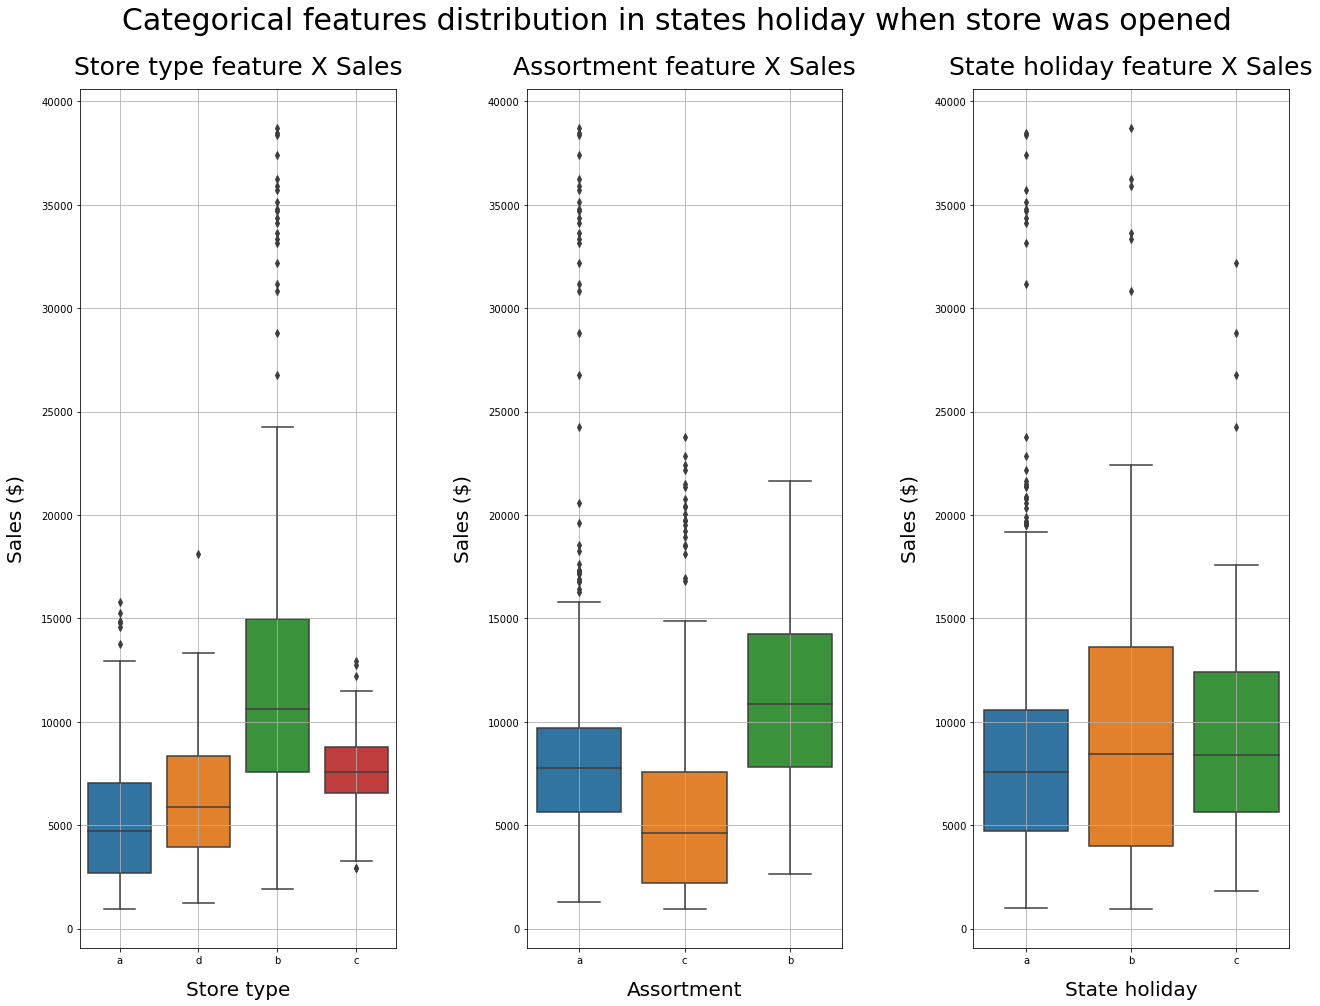

In [23]:
# creating a figure with 3 horizontal axis
fig, axes = plt.subplots(1, 3, figsize= (20, 15))
fig.tight_layout(pad= 10)

# setting the figure title and size
fig.suptitle("Categorical features distribution in states holiday when store was opened", size=30)

# creating an auxiliar dataset
aux = df1[(df1['state_holiday'] != 0) & (df1['state_holiday'] != "0") & (df1['sales'] > 0)]

# setting first axe's graph, title and labels
sns.boxplot(ax= axes[0], x=aux['store_type'], y= aux['sales']);
axes[0].set_title("Store type feature X Sales", size= 25, pad= 15)
axes[0].set_xlabel("Store type", size= 20, labelpad= 15)
axes[0].set_ylabel("Sales ($)", size= 20, labelpad= 15)
axes[0].grid()

# setting second axe's graph, title and labels
sns.boxplot(ax= axes[1], x=aux['assortment'], y= aux['sales']);
axes[1].set_title("Assortment feature X Sales", size= 25, pad= 15)
axes[1].set_xlabel("Assortment", size= 20, labelpad= 15)
axes[1].set_ylabel("Sales ($)", size= 20, labelpad= 15)
axes[1].grid()

# setting thirth axe's graph, title and labels
sns.boxplot(ax= axes[2], x=aux['state_holiday'], y= aux['sales']);
axes[2].set_title("State holiday feature X Sales", size= 25, pad= 15)
axes[2].set_xlabel("State holiday", size= 20, labelpad= 15)
axes[2].set_ylabel("Sales ($)", size= 20, labelpad= 15)
axes[2].grid()

***
**As seen above:**

- **`Store_type`** **b** have a better sales than the others.
- **`Assortment`** type **b**, which is the *extra* type, have a better sales than the others. 
- Christmas and Easter holidays have almost the same median sales values, with Easter having a higher quartis and outliers.

# <font color=green size= 6> <b>3. FEATURES ENGINEERING </font></b>
***

In [24]:
# creating a dataframe's copy to work, from the original 'df1' dataframe
df2 = df1.copy()

# displaying the first 5 dataframe's registers 
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month,is_promo2_active
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


## <font color=green size= 5>3.1 MIND MAP AND HYPOTESES </font>
***

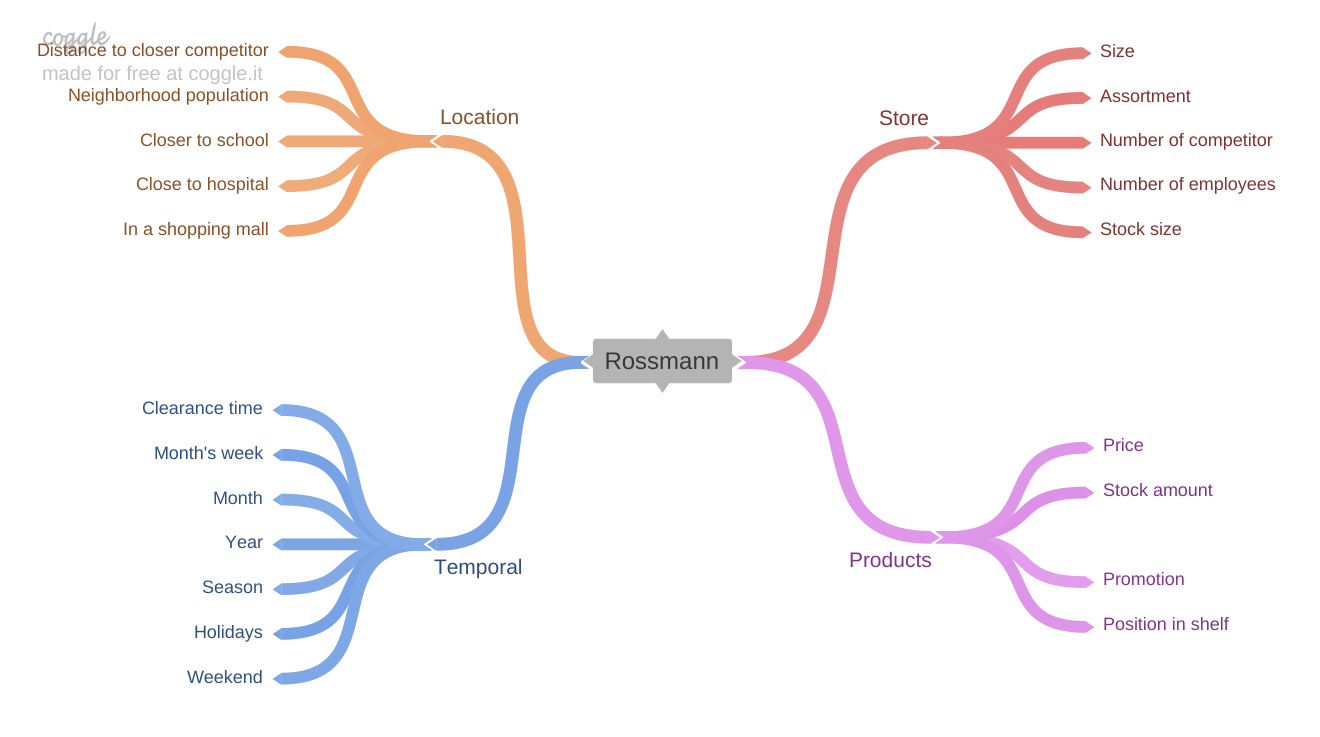

In [25]:
Image('../images/mind_map.png')

***
- **HYPOTHESIS  1 (H1):** The closer the closest competitor's store is, the less the Rossmann store sells.

- **HYPOTHESIS  2 (H2):** Stores with more customers are more likely to sell more.

- **HYPOTHESIS  3 (H3):** Stores are more likely sell more in the month's first 10 days than the rest. 

- **HYPOTHESIS  4 (H4):** Stores are more likely to sell more in a weekend day than work week days.

- **HYPOTHESIS  5 (H5):** Stores are more likely to increase their daily sales in the winter than any other season. 

- **HYPOTHESIS  6 (H6):** Stores are more likely to have their best daily sales in Christmas holiday.

- **HYPOTHESIS  7 (H7):** Stores daily sales are more likely to increase at the second semester.

- **HYPOTHESIS  8 (H8):** The total stores revenue increases year over year.

- **HYPOTHESIS  9 (H9):** Stores sales are more likely to increase the longer is it promotion 2 running time.

- **HYPOTHESIS  10 (H10):** Stores sales increases the more consecutive promotions it has.

- **HYPOTHESIS  11 (H11):** Stores sales increases the more variate its assortment level is.

- **HYPOTHESIS  12 (H12):** Stores sales increases the longer its closest competitor exists.

- **HYPOTHESIS  13 (H13):** Stores sales increases during the schools holidays.

## <font color=green size= 5>3.2 FEATURES TRANSFORMATION </font>
***

In [26]:
# creating a dataset's column indicating the register's day number
df2['day'] = df2['date'].dt.day

# creating a dataset's column indicating if the register's day is a weekend or a work week
df2['weekend'] = df2.apply(lambda x:
                          1 if (x['day_of_week']== 6) or (x['day_of_week']== 7) else
                          0, axis= 1)

# creating a dataset's column indicating if the register's day is in the first month's 10 days or not
df2['month_first_10_days'] = df2['day'].apply(lambda x:
                                         0 if x > 10 else
                                         1)

# creating a dataset's column with the register's week of year number
df2['week_of_year'] = df2['date'].dt.weekofyear


# creating a dataset's column indicating the register's season
df2['season'] = df2['date'].apply(lambda x: 
                                                 'Summer' if 7 <= x.month <= 9 else
                                                 'Fall'   if 10 <= x.month <= 12 else
                                                 'Winter' if 1 <= x.month <= 3 else
                                                 'Spring')

# creating a dataset's column indicating the register's semester
df2['semester'] = df2['date'].apply(lambda x: 
                                                 1 if 1 <= x.month <= 6 else
                                                 2)

# creating a dataset's column indicating the register's year
df2['year'] = df2['date'].dt.year

# creating a dataset's column indicating the date the the competition with the competitor store started or will start
df2['competition_start'] = df2.apply(lambda x: 
           datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day= 1), axis= 1)

# creating a dataset's column indicating the month that started the competition
df2['competition_time_month'] = ((df2['date'] - df2['competition_start']) / 31).apply(lambda x: x.days).astype(int)

# creating a dataset's column indicating the date that started the promotion 2
df2['promo2_start'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

# manipulating the 'promo2_start' column values
df2['promo2_start'] = df2['promo2_start'].apply(lambda x:
                                              datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

# creating a dataset's column indicating how long the store's is adept to promotion 2
df2['promo2_time_week'] = ((df2['date'] - df2['promo2_start']) / 7).apply(lambda x: x.days).astype(int)

# manipulating the 'assortment' column values
df2['assortment'] = df2['assortment'].apply(lambda x: 
                                            'basic' if x == 'a' else 
                                            'extra' if x == 'b' else 
                                            'extended')

# manipulating the 'state_holiday' column values
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 
                                                  'public' if x == 'a' else 
                                                  'easter' if x == 'b' else 
                                                  'christmas' if x == 'c' else 
                                                  'regular')

In [27]:
# removing the unnecessaries dataset's columns
df2.drop(columns= ['competition_open_since_month', 
                   'competition_open_since_year', 
                   'promo2_since_week', 
                   'promo2_since_year', 
                   'competition_start', 
                   'promo2_start', 
                   'promo_interval'], axis= 1, inplace= True)

# removing the unnecessaries dataset's registers
df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]

# # removing the unnecessaries dataset's columns, again
df2.drop(columns= ['open'], axis= 1, inplace= True)

# displaying the first 5 transposed dataframe's registers
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
promo,1,1,1,1,1
state_holiday,regular,regular,regular,regular,regular
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic


## <font color=green size= 5>3.3 OUTLIERS MANIPULATION </font>
***

There will be no outliers manipulation. This because the outliers are part of the information. 

For example, we can't delete **`Sales`** outliers, because probably they are referring to a holiday period and we will lose the bias of the period.

# <font color=green size= 6> <b>4. EXPLORATORY DATA ANALYSIS </font></b>
***

In [28]:
# creating a dataframe's copy to work, from the original 'df2' dataframe
df3 = df2.copy()

# displaying the first 5 dataframe's registers 
df3.head()

,store,day_of_week,date,sales,customers,promo,state_holiday,school_holiday,store_type,assortment,...,is_promo2_active,day,weekend,month_first_10_days,week_of_year,season,semester,year,competition_time_month,promo2_time_week
0,1,5,2015-07-31,5263,555,1,regular,1,c,basic,...,0,31,0,0,31,Summer,2,2015,81,0
1,2,5,2015-07-31,6064,625,1,regular,1,a,basic,...,1,31,0,0,31,Summer,2,2015,91,279
2,3,5,2015-07-31,8314,821,1,regular,1,a,basic,...,1,31,0,0,31,Summer,2,2015,102,226
3,4,5,2015-07-31,13995,1498,1,regular,1,c,extended,...,0,31,0,0,31,Summer,2,2015,69,0
4,5,5,2015-07-31,4822,559,1,regular,1,a,basic,...,0,31,0,0,31,Summer,2,2015,3,0


## <font color=green size= 5>4.1 UNIVARIATE ANALYSIS </font>
***

### <font color=green size= 4>4.1.1 CATEGORICAL VARIABLES </font>
***

For this sub section, I will analyze only the categorical features related to the store and holidays.

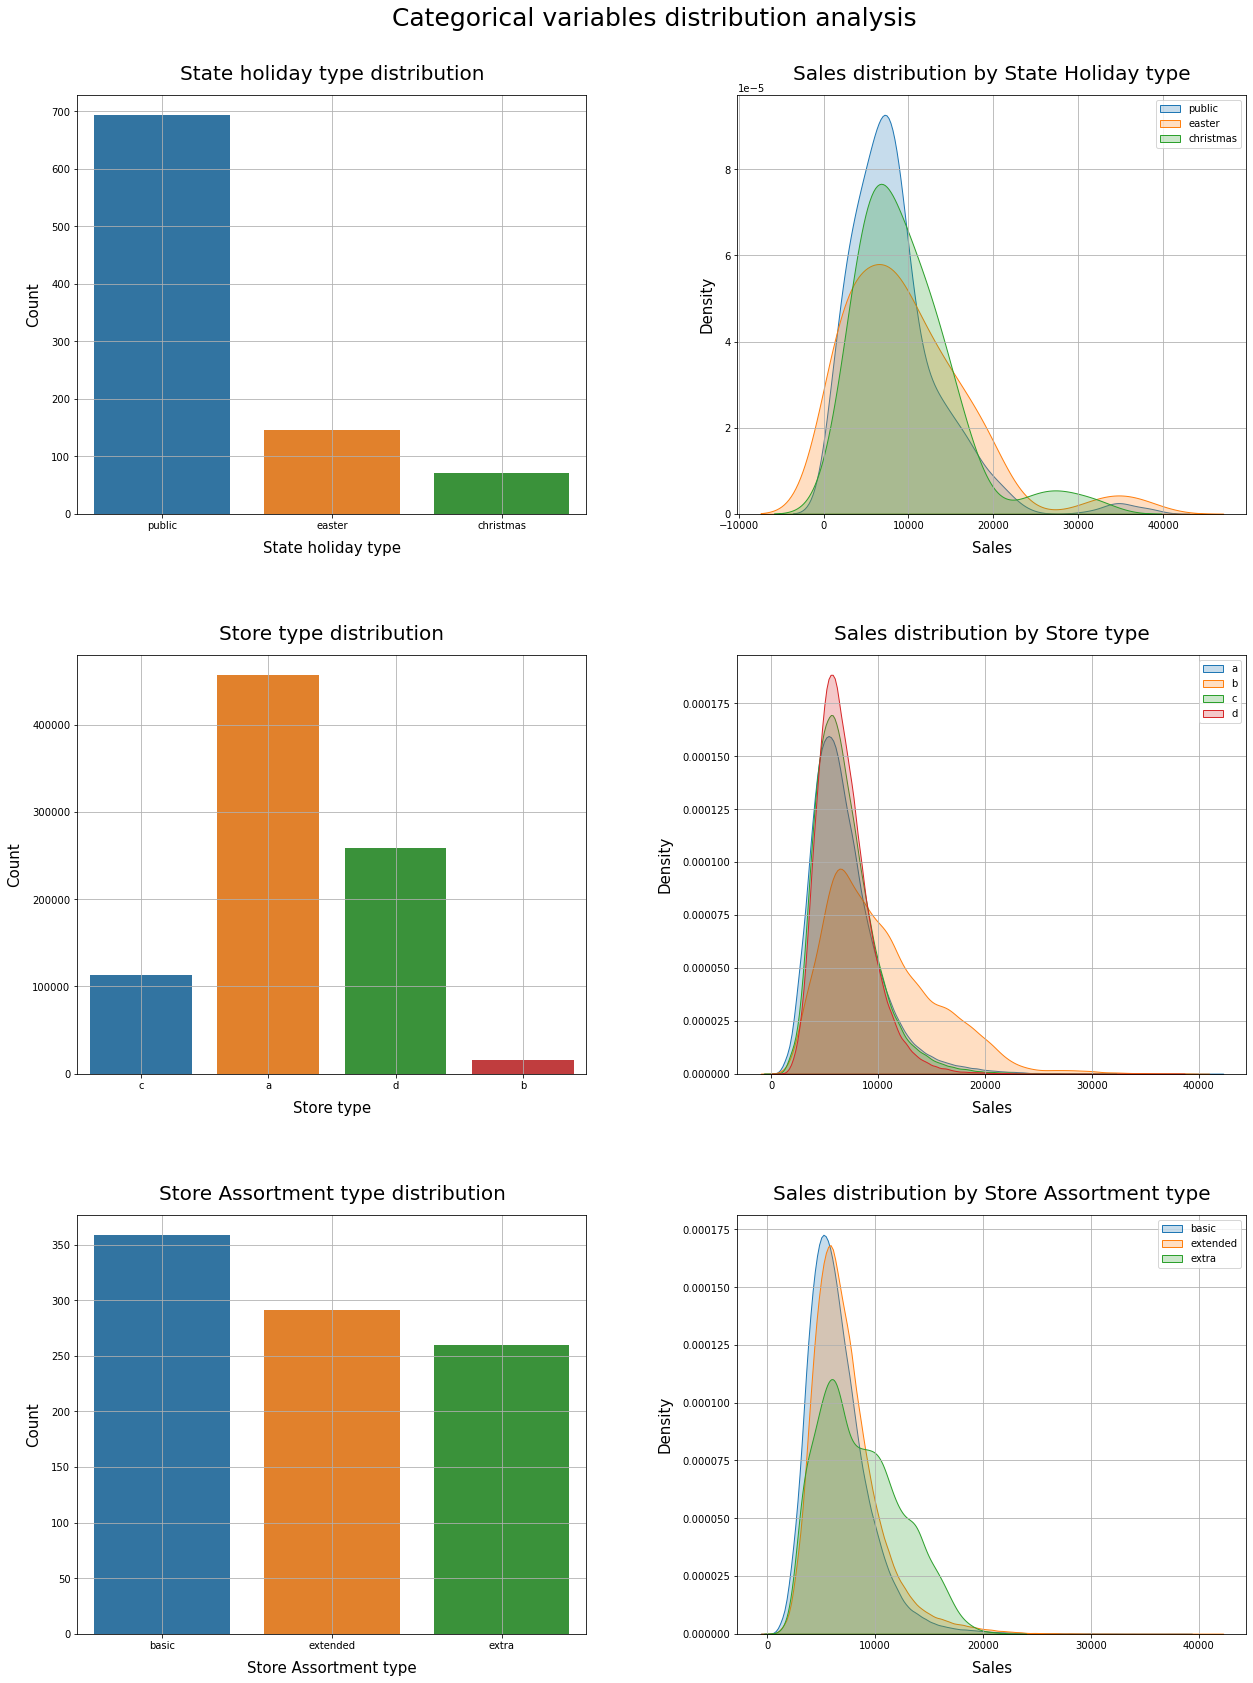

In [29]:
# creating a figure with 3 rows and 3 columns of axes
fig, axes = plt.subplots(3, 2, figsize= (20, 25))
fig.tight_layout(pad= 12)

# setting the figure title and size
fig.suptitle('Categorical variables distribution analysis', size= 25)

# creating an auxilar dataset, without the regular days
aux = df3[df3['state_holiday'] != 'regular']

# setting 0,0 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[0,0], x= aux['state_holiday'])
axes[0,0].set_title('State holiday type distribution', size= 20, pad= 15)
axes[0,0].set_xlabel('State holiday type', size= 15, labelpad= 10)
axes[0,0].set_ylabel('Count', size= 15, labelpad= 10)
axes[0,0].grid()

# setting 0,1 axes graph, title, labels, ticks and sizes
sns.kdeplot(ax= axes[0,1], x= df3[df3['state_holiday'] == 'public']['sales'], label= 'public', shade= True)
sns.kdeplot(ax= axes[0,1], x= df3[df3['state_holiday'] == 'easter']['sales'], label= 'easter', shade= True)
sns.kdeplot(ax= axes[0,1], x= df3[df3['state_holiday'] == 'christmas']['sales'], label= 'christmas', shade= True)
axes[0,1].set_title('Sales distribution by State Holiday type', size= 20, pad= 15)
axes[0,1].set_xlabel('Sales', size= 15, labelpad= 10)
axes[0,1].set_ylabel('Density', size= 15, labelpad= 10)
axes[0,1].legend()
axes[0,1].grid()


# setting 1,0 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[1,0], x= df3['store_type'])
axes[1,0].set_title('Store type distribution', size= 20, pad= 15)
axes[1,0].set_xlabel('Store type', size= 15, labelpad= 10)
axes[1,0].set_ylabel('Count', size= 15, labelpad= 10)
axes[1,0].grid()

# setting 1,1 axes graph, title, labels, ticks and sizes
sns.kdeplot(ax= axes[1,1], x= df3[df3['store_type'] == 'a']['sales'], label= 'a', shade= True)
sns.kdeplot(ax= axes[1,1], x= df3[df3['store_type'] == 'b']['sales'], label= 'b', shade= True)
sns.kdeplot(ax= axes[1,1], x= df3[df3['store_type'] == 'c']['sales'], label= 'c', shade= True)
sns.kdeplot(ax= axes[1,1], x= df3[df3['store_type'] == 'd']['sales'], label= 'd', shade= True)
axes[1,1].set_title('Sales distribution by Store type', size= 20, pad= 15)
axes[1,1].set_xlabel('Sales', size= 15, labelpad= 10)
axes[1,1].set_ylabel('Density', size= 15, labelpad= 10)
axes[1,1].legend()
axes[1,1].grid()


# setting 2,0 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[2,0], x= aux['assortment'])
axes[2,0].set_title('Store Assortment type distribution', size= 20, pad= 15)
axes[2,0].set_xlabel('Store Assortment type', size= 15, labelpad= 10)
axes[2,0].set_ylabel('Count', size= 15, labelpad= 10)
axes[2,0].grid()

# setting 2,1 axes graph, title, labels, ticks and sizes
sns.kdeplot(ax= axes[2,1], x= df3[df3['assortment'] == 'basic']['sales'], label= 'basic', shade= True)
sns.kdeplot(ax= axes[2,1], x= df3[df3['assortment'] == 'extended']['sales'], label= 'extended', shade= True)
sns.kdeplot(ax= axes[2,1], x= df3[df3['assortment'] == 'extra']['sales'], label= 'extra', shade= True)
axes[2,1].set_title('Sales distribution by Store Assortment type', size= 20, pad= 15)
axes[2,1].set_xlabel('Sales', size= 15, labelpad= 10)
axes[2,1].set_ylabel('Density', size= 15, labelpad= 10)
axes[2,1].legend()
axes[2,1].grid()

# saving the figure as in the storytelling folder as 'cat_features_distribution'
fig.savefig('../storytelling/cat_features_distribution.png')

***
**As seen above:**

- There are more registers at public holidays than any other holiday. But its important to notice that even with only a few register at Christmas holiday, its **`sales`** distribution indicates that its daily sales are high.
<br>

- There are more registers with stores **type a**, followed by **c, d and b**. The stores types **b, d, c** have almost the same sales distribution. Even with more stores **type a**, they have a wide sales distribution (not so concentrated distribution) and with the dataset restrict informations we can't find the reason.
<br>

- There are more **basic** assortment type's stores than **extended** and **extra**. The sales distribution for **basic** and **extended** types are almost the same. **The extra assortment sales distribution being to wide is probably because it has a larger variety of products.**

### <font color=green size= 4>4.1.2 NUMERICAL VARIABLES </font>
***

For this sub section, I will analyze only some of the numerical features. The others will be evaluated at the bivariate analysis.

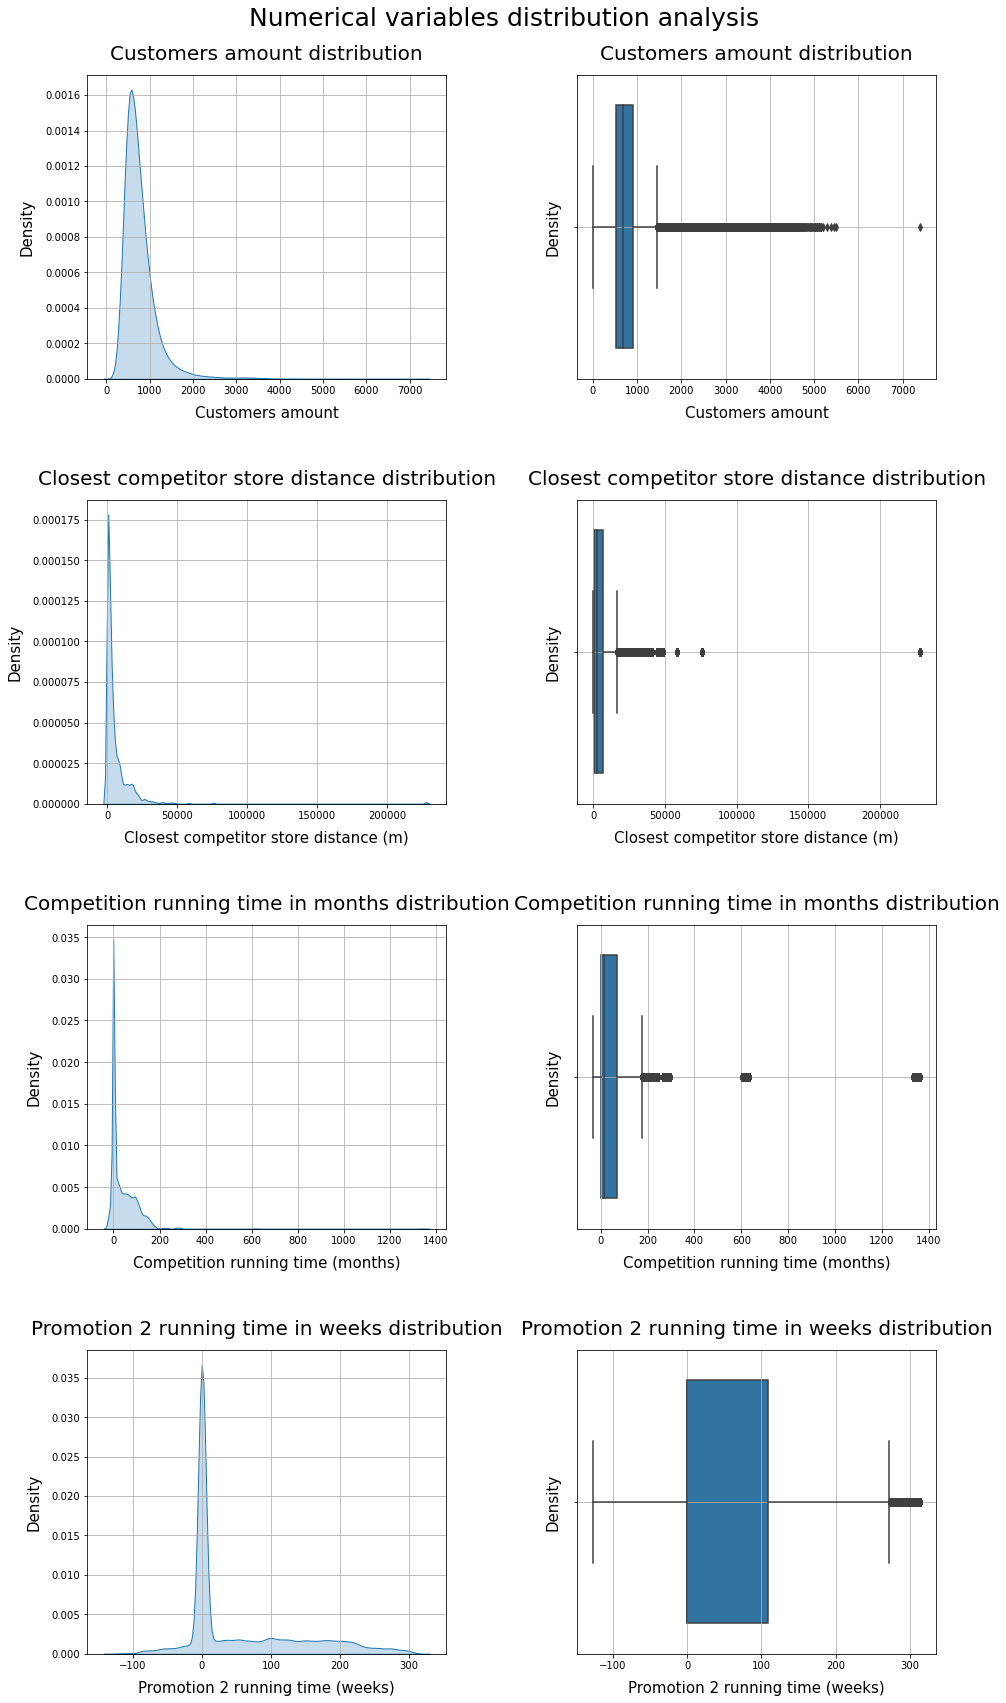

In [30]:
# creating a figure with 2 rows and 3 columns of axes
fig, axes = plt.subplots(4, 2, figsize= (15, 25))
fig.tight_layout(pad=10)

# setting the figure title and size
fig.suptitle('Numerical variables distribution analysis', size= 25)

# setting 0,0 axes graph, title, labels, ticks and sizes
sns.kdeplot(ax= axes[0,0], x= df3['customers'], shade= True)
axes[0,0].set_title('Customers amount distribution', size= 20, pad= 15)
axes[0,0].set_xlabel('Customers amount', size= 15, labelpad= 10)
axes[0,0].set_ylabel('Density', size= 15, labelpad= 10)
axes[0,0].grid()

# setting 0,1 axes graph, title, labels, ticks and sizes
sns.boxplot(ax= axes[0,1], x= df3['customers'])
axes[0,1].set_title('Customers amount distribution', size= 20, pad= 15)
axes[0,1].set_xlabel('Customers amount', size= 15, labelpad= 10)
axes[0,1].set_ylabel('Density', size= 15, labelpad= 10)
axes[0,1].grid()


# setting 1,0 axes graph, title, labels, ticks and sizes
sns.kdeplot(ax= axes[1,0], x= df3['competition_distance'], shade= True)
axes[1,0].set_title('Closest competitor store distance distribution', size= 20, pad= 15)
axes[1,0].set_xlabel('Closest competitor store distance (m)', size= 15, labelpad= 10)
axes[1,0].set_ylabel('Density', size= 15, labelpad= 10)
axes[1,0].grid()

# setting 1,1 axes graph, title, labels, ticks and sizes
sns.boxplot(ax= axes[1,1], x= df3['competition_distance'])
axes[1,1].set_title('Closest competitor store distance distribution', size= 20, pad= 15)
axes[1,1].set_xlabel('Closest competitor store distance (m)', size= 15, labelpad= 10)
axes[1,1].set_ylabel('Density', size= 15, labelpad= 10)
axes[1,1].grid()


# setting 2,0 axes graph, title, labels, ticks and sizes
sns.kdeplot(ax= axes[2,0], x= df3['competition_time_month'], shade= True)
axes[2,0].set_title('Competition running time in months distribution', size= 20, pad= 15)
axes[2,0].set_xlabel('Competition running time (months)', size= 15, labelpad= 10)
axes[2,0].set_ylabel('Density', size= 15, labelpad= 10)
axes[2,0].grid()

# setting 2,1 axes graph, title, labels, ticks and sizes
sns.boxplot(ax= axes[2,1], x= df3['competition_time_month'])
axes[2,1].set_title('Competition running time in months distribution', size= 20, pad= 15)
axes[2,1].set_xlabel('Competition running time (months)', size= 15, labelpad= 10)
axes[2,1].set_ylabel('Density', size= 15, labelpad= 10)
axes[2,1].grid()


# setting 3,0 axes graph, title, labels, ticks and sizes
sns.kdeplot(ax= axes[3,0], x= df3['promo2_time_week'], shade= True)
axes[3,0].set_title('Promotion 2 running time in weeks distribution', size= 20, pad= 15)
axes[3,0].set_xlabel('Promotion 2 running time (weeks)', size= 15, labelpad= 10)
axes[3,0].set_ylabel('Density', size= 15, labelpad= 10)
axes[3,0].grid()

# setting 3,1 axes graph, title, labels, ticks and sizes
sns.boxplot(ax= axes[3,1], x= df3['promo2_time_week'])
axes[3,1].set_title('Promotion 2 running time in weeks distribution', size= 20, pad= 15)
axes[3,1].set_xlabel('Promotion 2 running time (weeks)', size= 15, labelpad= 10)
axes[3,1].set_ylabel('Density', size= 15, labelpad= 10)
axes[3,1].grid()

# saving the graph as 'num_features_distribution' in the storytelling folder     
fig.savefig('../storytelling/num_features_distribution.png')

***
**As seen above:**

- The **`customers`** distribution concentrates approximately at 600 clients, considering all stores. **There are only a few stores with over 1000 `customers`.**
<br>

- The **`competition_time_month`** distribution concentrates at 0 months, considering all stores. It indicates that, as we saw in section 2.5, a lot of the register's didn't have the information about the closest competitor store inaugural date.
<br>

- The **`promo2_time_week`** distribution concentrates at 0 weeks, considering all stores. It indicates that, as we saw in section 2.5, a significant amount of stores aren't adept of Promotion 2. There are some negative values, this is because probably some registers knew the future day that their competitor store would open.
<br>

- The **`promo2_time_week`** is the only one without an enormous amount of outliers, compared to the others features.

There are some techniques, that we will see in the next sections, that allow us to transform all these distributions into a shape closer to a normal distribution.

### <font color=green size= 4>4.1.3 RESPONSE VARIABLE </font>
***

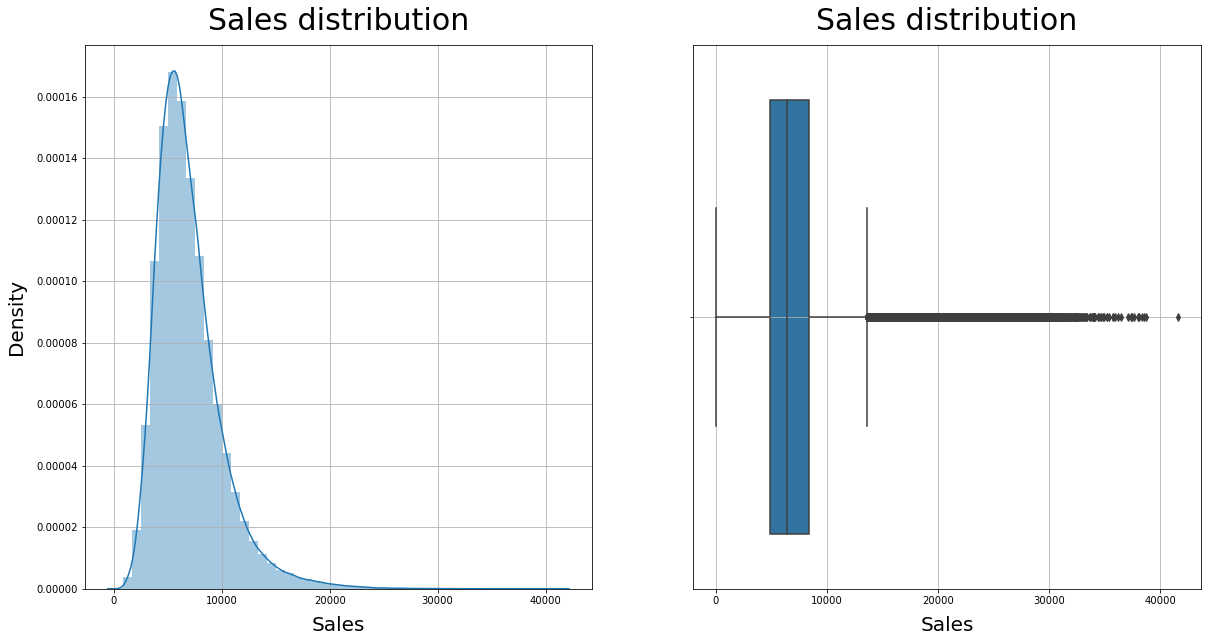

In [31]:
# creating a figure
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# setting first graph, title, labels, ticks and sizes
sns.distplot(ax= axes[0], x= df3['sales'], kde= True)
axes[0].set_title('Sales distribution', size= 30, pad= 15)
axes[0].set_xlabel('Sales', size= 20, labelpad= 10)
axes[0].set_ylabel('Density', size= 20, labelpad= 10)
axes[0].grid()

# setting second graph, title, labels, ticks and sizes
sns.boxplot(ax= axes[1], x= df3['sales'])
axes[1].set_title('Sales distribution', size= 30, pad= 15)
axes[1].set_xlabel('Sales', size= 20, labelpad= 10)
axes[1].grid()

***
**As seen above:**

- The **`sales`** label distribution isn't a normal curve. It was expected, as we discussed at section 2.7.1. 

- The **`sales`** label have a considerable amount of higher outliers.

There are some techniques, that we will see in the next sections, that allow us to transform this distribution into a shape closer to a normal distribution.

## <font color=green size= 5>4.2 BIVARIATE ANALYSIS </font>
***


### <font color=green size= 4>4.2.1 **HYPOTHESIS 1 (H1):** The closer the closest the competitor's store is, the less the Rossmann store sells daily  </font> - **FALSE**
***

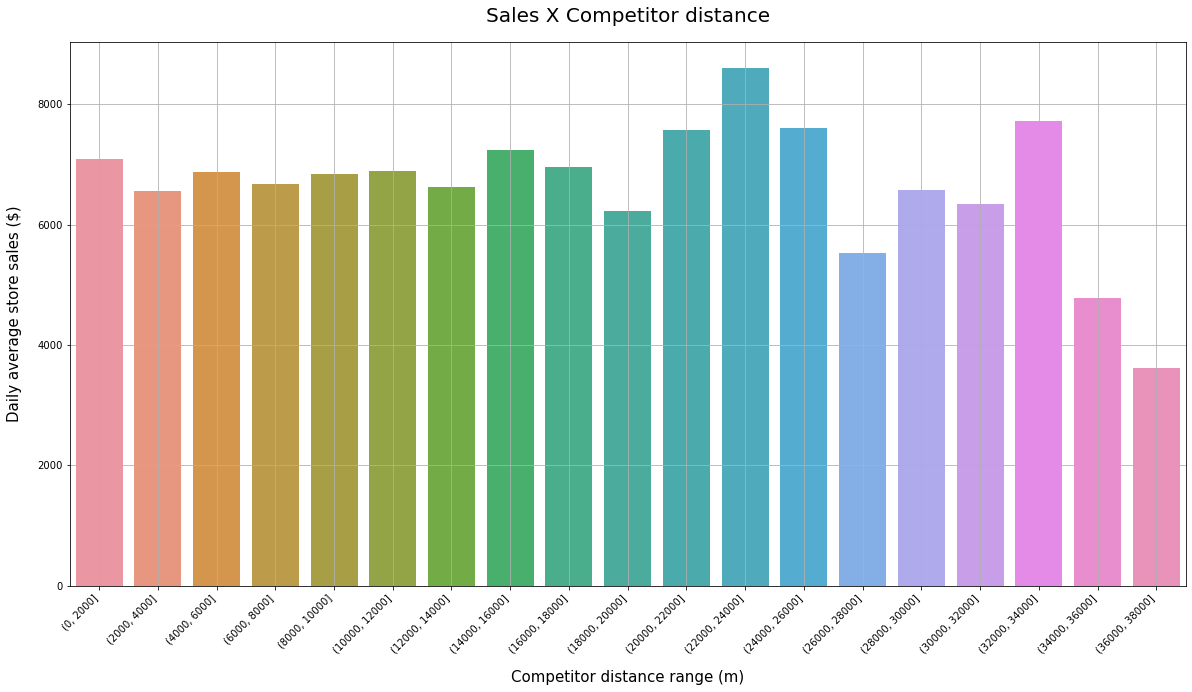

In [110]:
# creating an auxilar dataset
aux = df3[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

# creating the 'groups_competition_distance' column
aux['groups_competition_distance'] = pd.cut(aux['competition_distance'], bins= list(np.arange(0, 40000, 2000)))

# grouping the some auxilar dataset's columns
aux = aux[['groups_competition_distance', 'sales']].groupby('groups_competition_distance').mean().reset_index()

# removing the NaN values in the auxilar dataset
aux.dropna(inplace= True)

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['groups_competition_distance'], y= aux['sales'])
ax.set_title('Sales X Competitor distance', size= 20, pad= 20)
ax.set_ylabel('Daily average store sales ($)', size= 15, labelpad= 15)
ax.set_xlabel('Competitor distance range (m)', size= 15, labelpad= 15)
ax.grid()

# rotating the x axis labels
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
    
# saving the graph as 'H1' in the storytelling folder     
plt.savefig('../storytelling/H1.png')

***
**As seen above:**

- There is no pattern that indicates that the daily average sale decreases as closer the competitor store is. 
<br> 

- Also, the behavior varies a lot through the competitor distance range, which sometimes increases the store sales, and sometimes decreases the store sales.

### <font color=green size= 4>4.2.2 **HYPOTHESIS 2 (H2):** Stores with more customers are more likely to sell more daily  </font> - **TRUE**
***

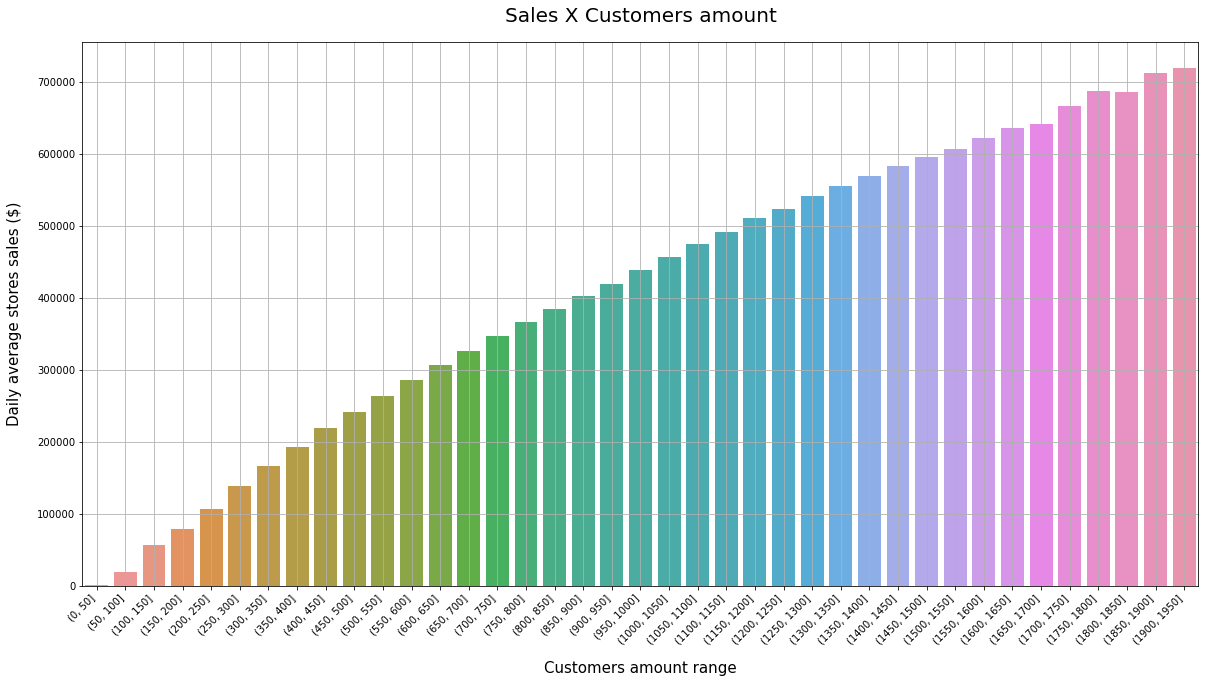

In [109]:
# creating an auxilar dataset
aux = df3[['customers', 'sales']].groupby('customers').mean().reset_index()

# creating the 'groups_customers' column
aux['groups_customers'] = pd.cut(aux['customers'], bins= list(np.arange(0, 2000, 50)))

# grouping the some auxilar dataset's columns
aux = aux[['groups_customers', 'sales']].groupby('groups_customers').sum().reset_index()

# removing the NaN values in the auxilar dataset
aux.dropna(inplace= True)

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['groups_customers'], y= aux['sales'])
ax.set_title("Sales X Customers amount", size= 20, pad= 20)
ax.set_ylabel('Daily average stores sales ($)', size= 15, labelpad= 15)
ax.set_xlabel("Customers amount range", size= 15, labelpad= 15)
ax.grid()

# rotating the x axis labels
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
    
    
# saving the graph as 'H2_1' in the storytelling folder     
plt.savefig('../storytelling/H2_1.png')

***
**As seen above:**

- By looking the big picture (cumulative sales), the more customers the store has, the more it sells daily.
<br> 

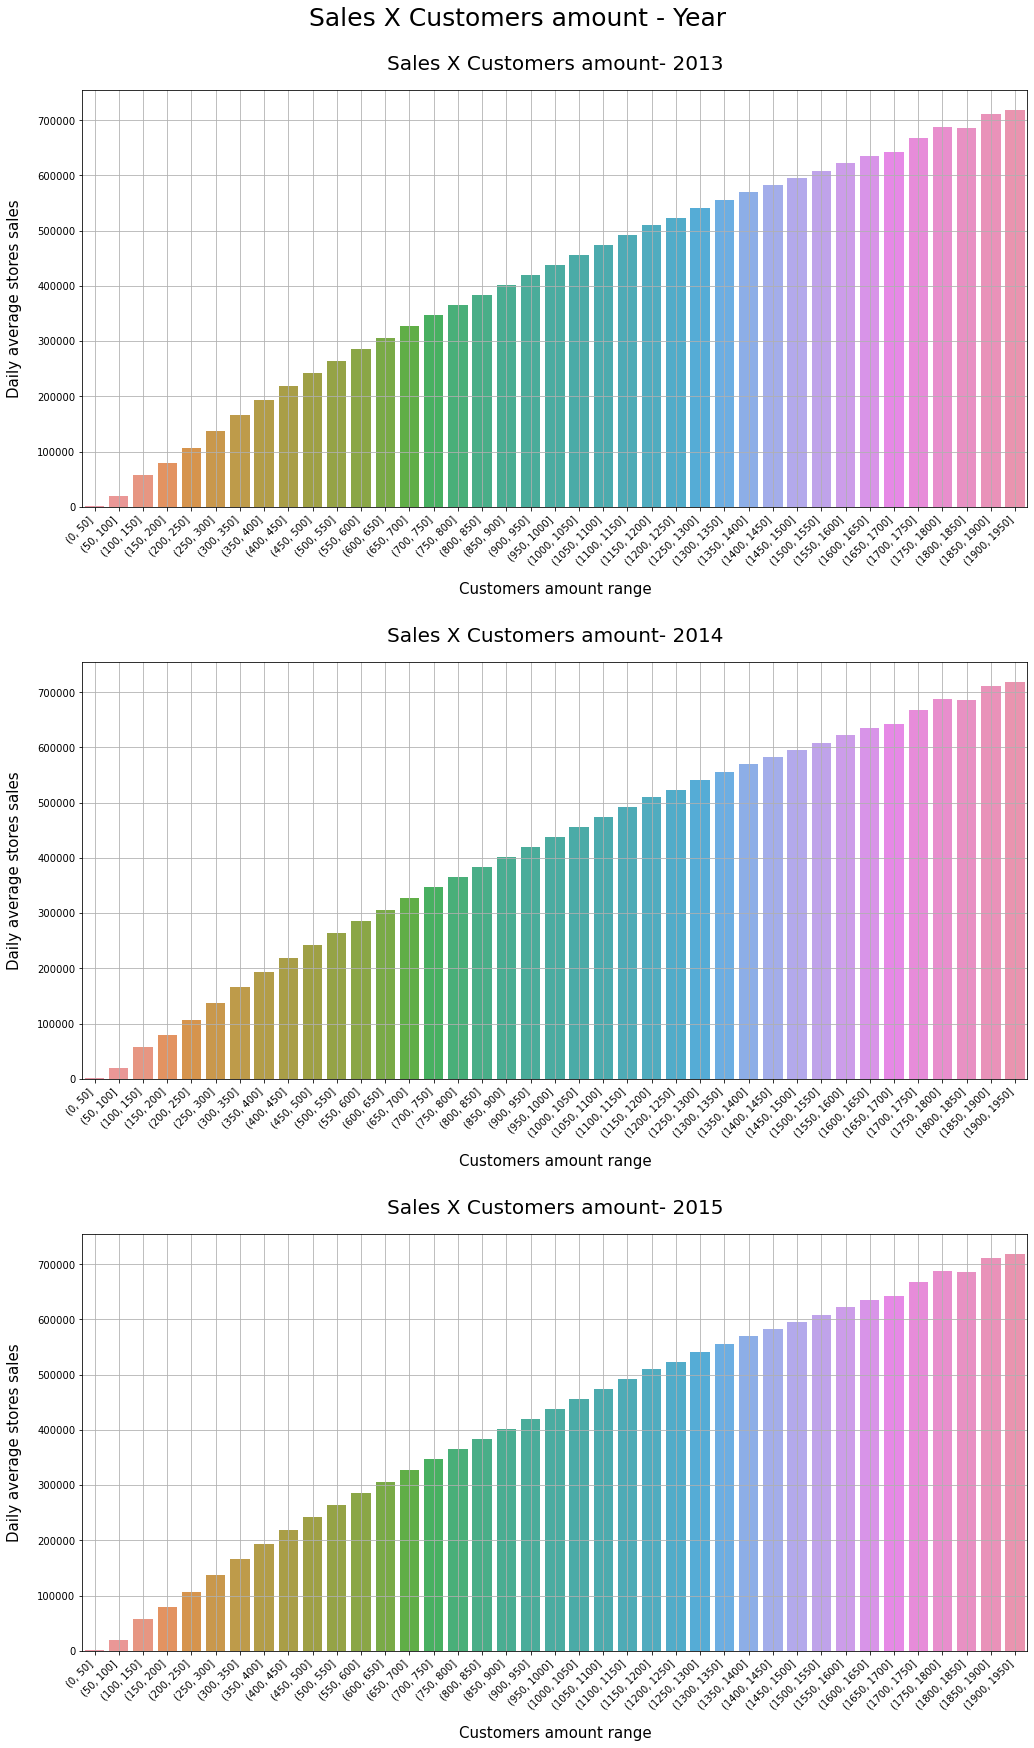

In [108]:
# creating a list with the unique values in the 'df3' 'year' column
year = list(df3['year'].unique())

# sorting the list by ascending values
year = sorted(year)

# creating a figure with 'n_rows' rows and 'n_cols' columns with n_rows*n_cols axes
fig, ax = plt.subplots(3, 1, figsize= (15, 25))

# setting the figure title and size
fig.suptitle("Sales X Customers amount - Year", size= 25)

# returning model, with its axe and its enumerate value
for ax, n, year in zip(ax.flatten(), list(range(3*1)), year):

    # creating a subplot for the selected model
    plt.subplot(3, 1, n+1)  
    
    # creating an auxilar dataset
    aux = df3[df3['year'] == year]
    
    # grouping the some auxilar dataset's columns
    aux = df3[['customers', 'sales']].groupby('customers').mean().reset_index()

    # creating the 'groups_customers' column
    aux['groups_customers'] = pd.cut(aux['customers'], bins= list(np.arange(0, 2000, 50)))

    # grouping the some auxilar dataset's columns
    aux = aux[['groups_customers', 'sales']].groupby('groups_customers').sum().reset_index()

    # removing the NaN values in the auxilar dataset
    aux.dropna(inplace= True)

    # setting ax graph, title, labels, ticks and sizes
    ax = sns.barplot(x= aux['groups_customers'], y= aux['sales'])
    ax.set_title(f"Sales X Customers amount- {year}", size= 20, pad= 20)
    ax.set_ylabel('Daily average stores sales', size= 15, labelpad= 15)
    ax.set_xlabel('Customers amount range', size= 15, labelpad= 15)
    ax.grid()
    
    # rotating the x axis labels
    for label in ax.get_xticklabels():
        label.set_ha("right")
        label.set_rotation(45)

# adjusting subplot
plt.tight_layout(pad= 3)

# saving the graph as 'H2_2' in the storytelling folder     
plt.savefig('../storytelling/H2_2.png')

# displaying the plot
plt.show()

***
**As seen above:**

- By looking the daily average sales trough the years, the pattern seen in the cumulative sales is the same, indicating that this behavior - which the stores are more likely to sells more by increasing the customers, is solid and atemporal.

### <font color=green size= 4>4.2.3 **HYPOTHESIS 3 (H3):** Stores are more likely sell more in the month's first 10 days than the rest of it</font> - **FALSE**
***

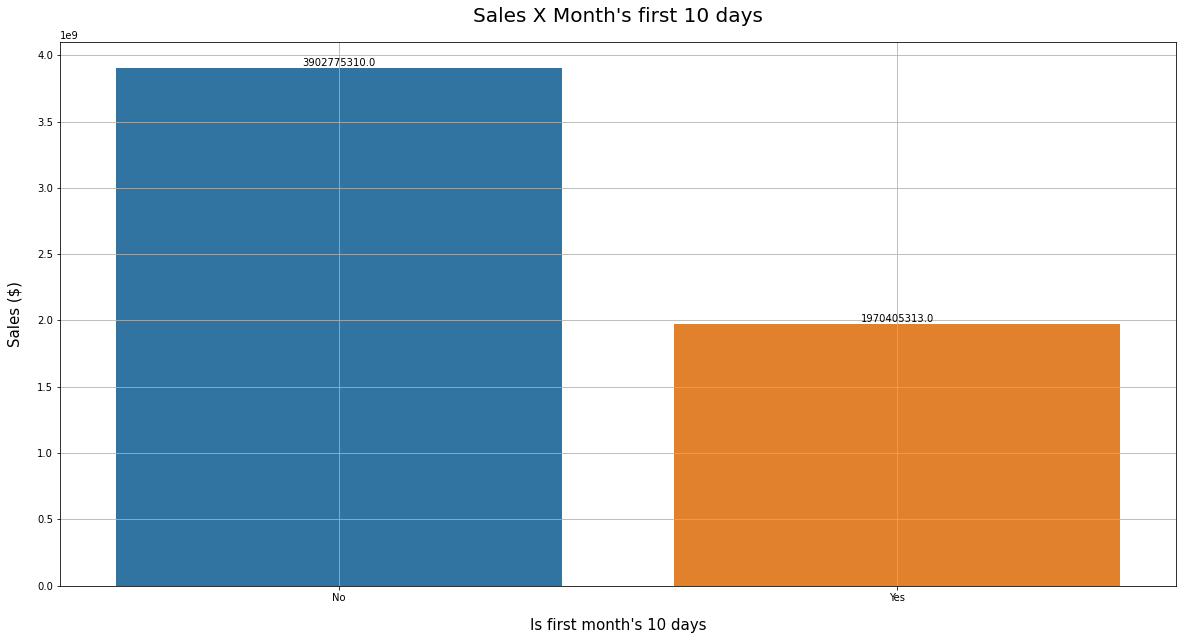

In [107]:
# creating an auxilar dataset
aux = df3[['month_first_10_days', 'sales']].groupby('month_first_10_days').sum().reset_index()

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['month_first_10_days'], y= aux['sales'])
ax.set_title("Sales X Month's first 10 days", size= 20, pad= 20)
ax.set_ylabel('Sales ($)', size= 15, labelpad= 15)
ax.set_xlabel("Is first month's 10 days", size= 15, labelpad= 15)
ax.set_xticklabels(labels= ['No', 'Yes'])
ax.grid()

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
           (p.get_x() + p.get_width() / 2., p.get_height()), 
           ha = 'center', va = 'center', 
           xytext = (0, 5), 
           textcoords = 'offset points')

# saving the graph as 'H3_1' in the storytelling folder  
plt.savefig('../storytelling/H3_1.png')

***
**As seen above:**

- By looking the big picture (cumulative sales), the store's don't sell more in the first month's 10 days than the rest of the month.

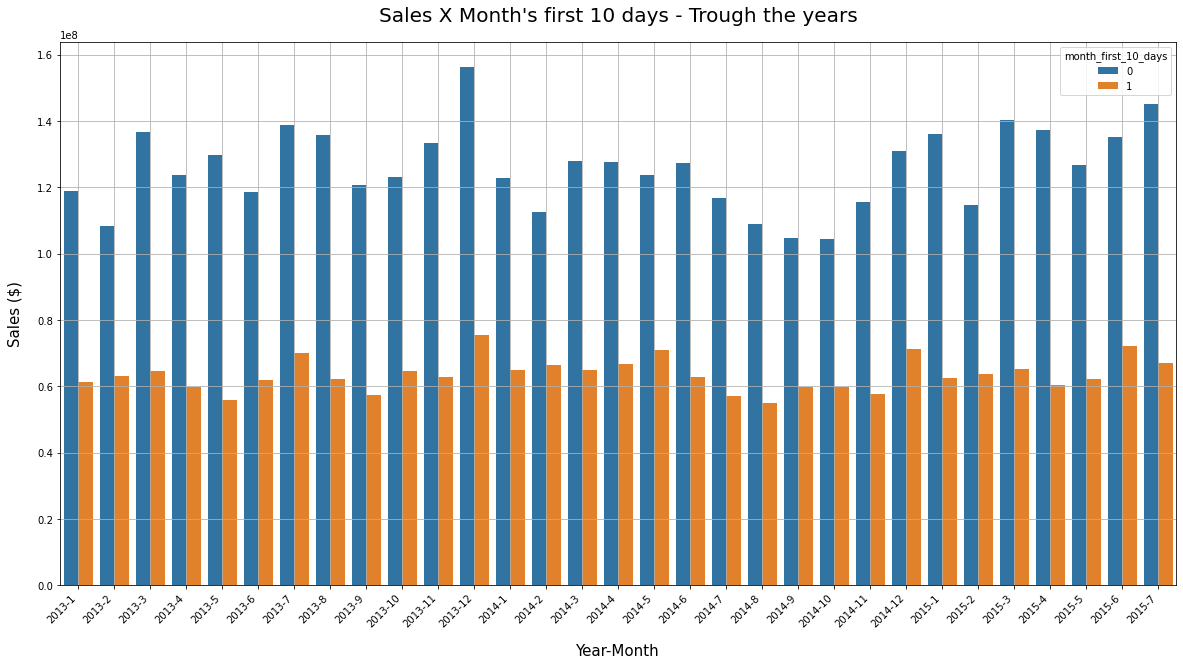

In [106]:
# creating an auxilar dataset
aux = df3[['year', 'month', 'month_first_10_days', 'sales']].groupby(['year', 'month', 'month_first_10_days']).sum().reset_index()

# creating a dictionary with the months numeral relations
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# creating the 'month_num' column, by mapping the 'month' column
aux['month_num'] = aux['month'].map(month_map)

# creating the 'year-month' column, concatenating the 'year' and 'month_num' column infos
aux['year-month'] = aux['year'].astype(str) + '-' + aux['month_num'].astype(str)

# sorting the auxilar dataset by 'year' and 'month_num' columns
aux.sort_values(['year', 'month_num'], ascending= [True, True], inplace= True)

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['year-month'], y= aux['sales'], hue= aux['month_first_10_days']);
ax.set_title("Sales X Month's first 10 days - Trough the years", size = 20, pad= 20)
ax.set_ylabel('Sales ($)', size= 15, labelpad= 15)
ax.set_xlabel('Year-Month', size= 15, labelpad= 15)
ax.grid()

# rotating the x axis labels
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

# saving the graph as 'H3_2' in the storytelling folder     
plt.savefig('../storytelling/H3_2.png')

***
**As seen above:**

- By looking the daily average sales trough the years, month by month, the pattern seen in the cumulative sales is the same, indicating that this behavior - which the stores are more likely to sells more after the month's 10 days is higher than the sales before the 10th day, is solid and atemporal.

### <font color=green size= 4>4.2.4 **HYPOTHESIS 4 (H4):** Stores are more likely to sell more daily in a weekend day than a work week day </font> - **FALSE**
***

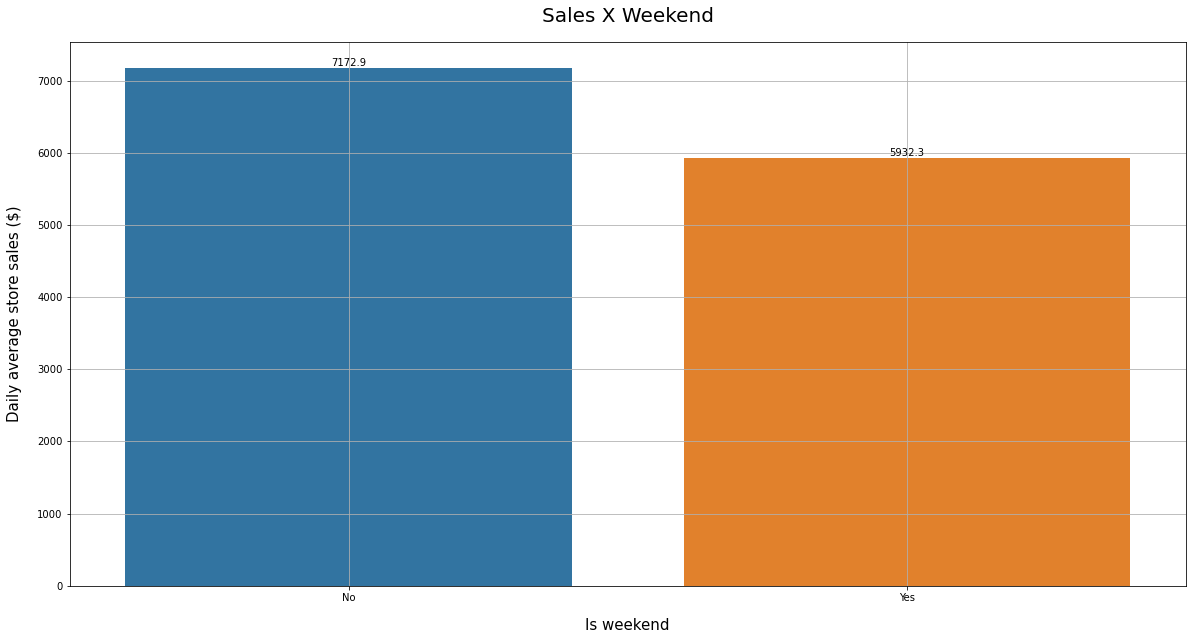

In [105]:
# creating an auxilar dataset
aux = df3[['weekend', 'sales']].groupby('weekend').mean().reset_index()

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['weekend'], y= aux['sales'])
ax.set_title("Sales X Weekend", size= 20, pad= 20)
ax.set_ylabel("Daily average store sales ($)", size= 15, labelpad= 15)
ax.set_xlabel("Is weekend", size= 15, labelpad= 15)
ax.set_xticklabels(labels= ['No', 'Yes'])
ax.grid()

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
           (p.get_x() + p.get_width() / 2., p.get_height()), 
           ha = 'center', va = 'center', 
           xytext = (0, 5), 
           textcoords = 'offset points')
    
# saving the graph as 'H4_1' in the storytelling folder  
plt.savefig('../storytelling/H4_1.png')

***
**As seen above:**

- By looking the big picture (cumulative sales), the stores don't sell more in a weekend day than a work week day. 

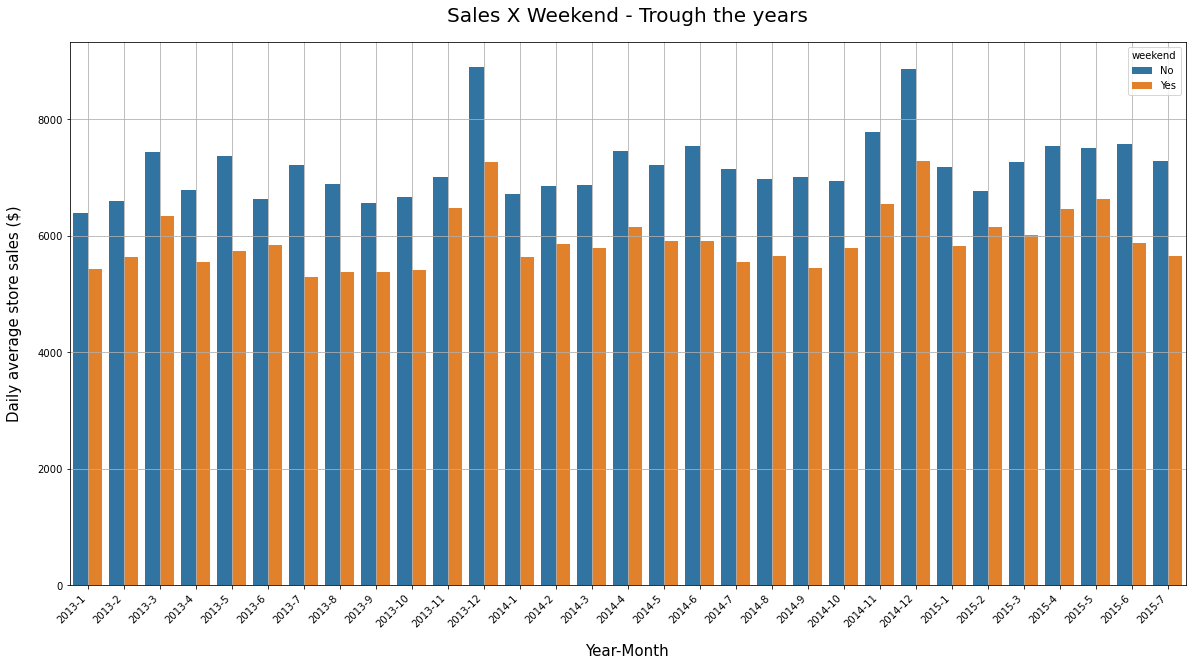

In [104]:
# creating an auxilar dataset
aux = df3[['year', 'month', 'weekend', 'sales']].groupby(['year', 'month', 'weekend']).mean().reset_index()

# creating a dictionary with the months numeral relations    
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# creating the 'month_num' column, by mapping the 'month' column
aux['month_num'] = aux['month'].map(month_map)

# creating a dictionary with the week yes or no
weekend_map = {0: 'No', 1: 'Yes'}

# manipulating the auxilar dataset's 'weekend' column
aux['weekend'] = aux['weekend'].map(weekend_map)

# creating the 'year-month' column, concatenating the 'year' and 'month_num' column infos
aux['year-month'] = aux['year'].astype(str) + '-' + aux['month_num'].astype(str)

# sorting the auxilar dataset by 'year' and 'month_num' columns
aux.sort_values(['year', 'month_num'], ascending= [True, True], inplace= True)

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['year-month'], y= aux['sales'], hue= aux['weekend']);
ax.set_title("Sales X Weekend - Trough the years", size = 20, pad= 20)
ax.set_ylabel('Daily average store sales ($)', size= 15, labelpad= 15)
ax.set_xlabel('Year-Month', size= 15, labelpad= 15)
ax.grid()

# rotating the x axis labels
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

# saving the graph as 'H4_2' in the storytelling folder     
plt.savefig('../storytelling/H4_2.png')

***
**As seen above:**

- By looking the daily average sales trough the years, month by month, the pattern seen in the cumulative sales is the same, indicating that this behavior - which the stores are more likely to sells more in a work week day than a weekend day, is solid and atemporal.

### <font color=green size= 4>4.2.5 **HYPOTHESIS 5 (H5):** Stores are more likely to increase their daily sales in the winter than any other season </font> - **FALSE**
***

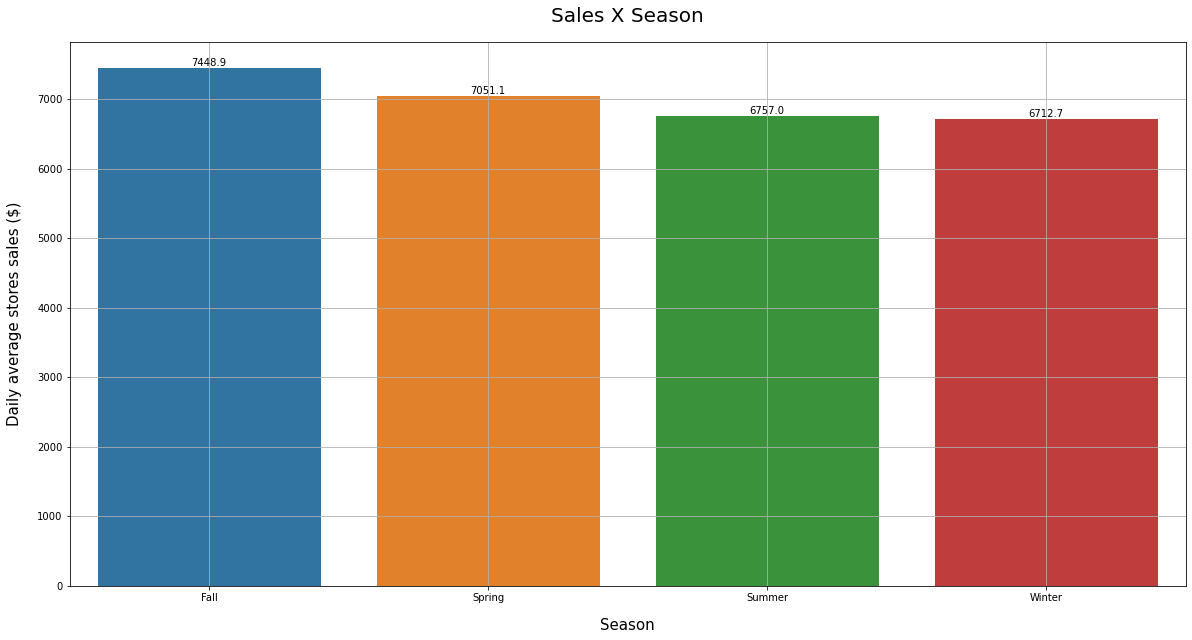

In [103]:
# creating an auxilar dataset
aux = df3[['season', 'sales']].groupby('season').mean().reset_index()

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['season'], y= aux['sales'])
ax.set_title("Sales X Season", size= 20, pad= 20)
ax.set_ylabel("Daily average stores sales ($)", size= 15, labelpad= 15)
ax.set_xlabel("Season", size= 15, labelpad= 15)
ax.grid()

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
           (p.get_x() + p.get_width() / 2., p.get_height()), 
           ha = 'center', va = 'center', 
           xytext = (0, 5), 
           textcoords = 'offset points')

    
# saving the graph as 'H5_1' in the storytelling folder  
plt.savefig('../storytelling/H5_1.png')

***
**As seen above:**

- By looking the big picture (cumulative sales), the stores increases their daily average sales on fall, followed by spring, summer and winter, respectively. 

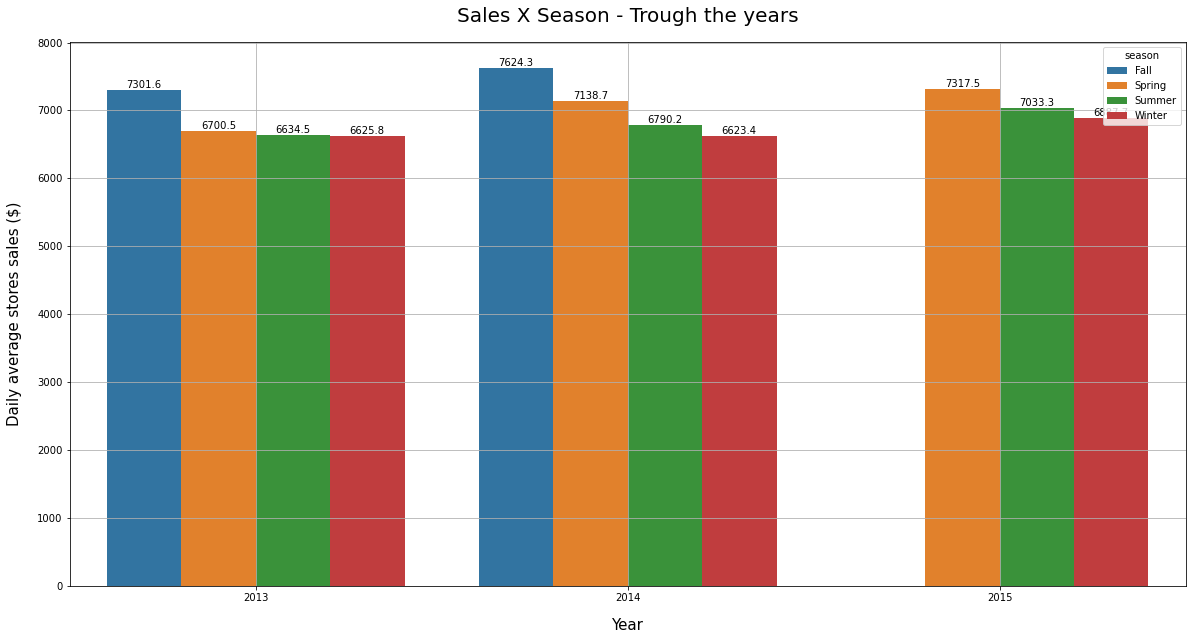

In [102]:
# creating an auxilar dataset
aux = df3[['year', 'season', 'sales']].groupby(['year', 'season']).mean().reset_index()

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['year'], y= aux['sales'], hue= aux['season']);
ax.set_title("Sales X Season - Trough the years", size = 20, pad= 20)
ax.set_ylabel('Daily average stores sales ($)', size= 15, labelpad= 15)
ax.set_xlabel('Year', size= 15, labelpad= 15)
ax.grid()

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
           (p.get_x() + p.get_width() / 2., p.get_height()), 
           ha = 'center', va = 'center', 
           xytext = (0, 5), 
           textcoords = 'offset points')
    
# saving the graph as 'H5_2' in the storytelling folder     
plt.savefig('../storytelling/H5_2.png')

***
**As seen above:**

- By looking the daily average sales trough the years, month by month, the pattern seen in the cumulative sales is the same, indicating that this behavior - which the stores are more likely to sells more on fall followed by spring, summer and winter, is solid and atemporal.
<br>

- Is important to notice that the last date in the dataset is 31/07/2015, so there was no fall season at that year. Thats why there is no fall season bar column for 2015 in the graph above.

### <font color=green size= 4>4.2.6 **HYPOTHESIS 6 (H6):** Stores are more likely to have their best daily sales in Christmas holiday </font> - **FALSE**
***

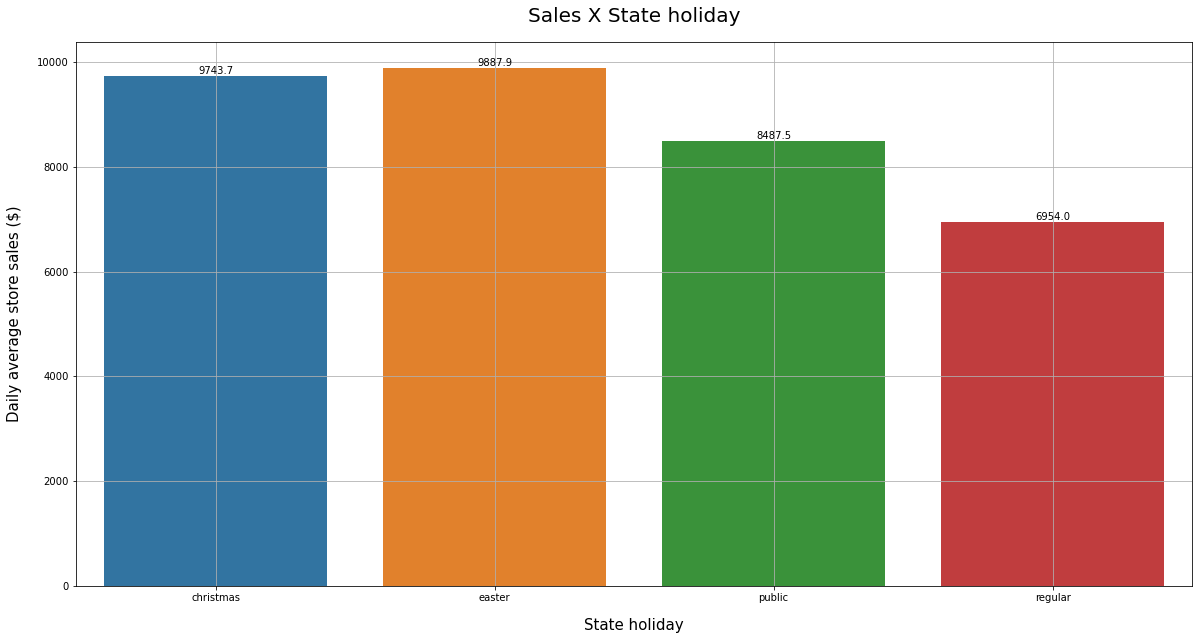

In [101]:
# creating an auxilar dataset
aux = df3[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['state_holiday'], y= aux['sales'])
ax.set_title("Sales X State holiday", size= 20, pad= 20)
ax.set_ylabel("Daily average store sales ($)", size= 15, labelpad= 15)
ax.set_xlabel("State holiday", size= 15, labelpad= 15)
ax.grid()

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
           (p.get_x() + p.get_width() / 2., p.get_height()), 
           ha = 'center', va = 'center', 
           xytext = (0, 5), 
           textcoords = 'offset points')

    
# saving the graph as 'H6_1' in the storytelling folder  
plt.savefig('../storytelling/H6_1.png')

***
**As seen above:**

- By looking the big picture (cumulative sales), the stores increases their daily average sales on easter, followed by christmas and public holidays, respectively. 
<br>

- The difference between the daily average sales during easter holiday and christmas holiday is very low, something that is needed to be check through all the years.

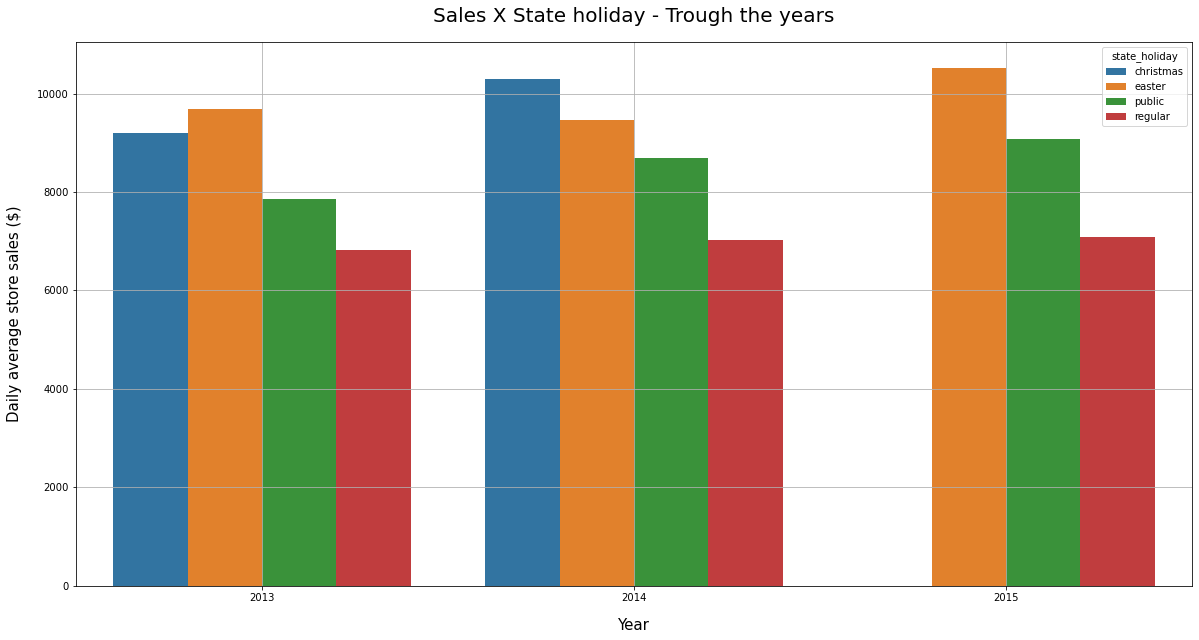

In [100]:
# creating an auxilar dataset
aux = df3[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['year'], y= aux['sales'], hue= aux['state_holiday']);
ax.set_title("Sales X State holiday - Trough the years", size = 20, pad= 20)
ax.set_ylabel('Daily average store sales ($)', size= 15, labelpad= 15)
ax.set_xlabel('Year', size= 15, labelpad= 15)
ax.grid()

# saving the graph as 'H6_2' in the storytelling folder     
plt.savefig('../storytelling/H6_2.png')

***
**As seen above:**

- By looking the daily average sales trough the years, month by month, the pattern seen in the cumulative sales diverges through the years, indicating that this behavior - which the stores are more likely to sells more at Easter holiday than Christmas holiday, isn't solid and atemporal.
<br>

- Is important to notice that the last date in the dataset is 31/07/2015, so there was no christmas holiday at that year. Thats why there is no christmas holiday bar column for 2015 in the graph above.

### <font color=green size= 4>4.2.7 **HYPOTHESIS 7 (H7):** Stores daily sales are more likely to increase at the second semester </font> - **TRUE**
***

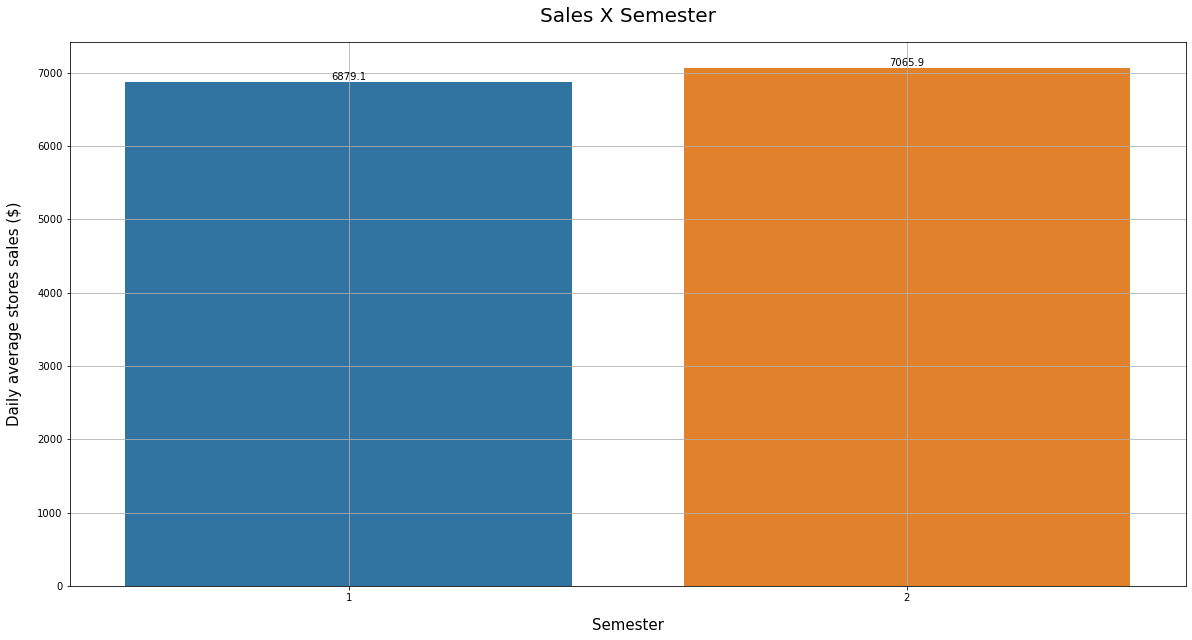

In [99]:
# creating an auxilar dataset
aux = df3[['semester', 'sales']].groupby('semester').mean().reset_index()

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['semester'], y= aux['sales'])
ax.set_title("Sales X Semester", size= 20, pad= 20)
ax.set_ylabel("Daily average stores sales ($)", size= 15, labelpad= 15)
ax.set_xlabel("Semester", size= 15, labelpad= 15)
ax.grid()

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
           (p.get_x() + p.get_width() / 2., p.get_height()), 
           ha = 'center', va = 'center', 
           xytext = (0, 5), 
           textcoords = 'offset points')

    
# saving the graph as 'H7_1' in the storytelling folder  
plt.savefig('../storytelling/H7_1.png')

***
**As seen above:**

- By looking the big picture (cumulative sales), the stores increases their daily average sales at the second semester.
<br>

- The difference between the daily average sales at the first and second semester is very low, something that is needed to be check through all the years.

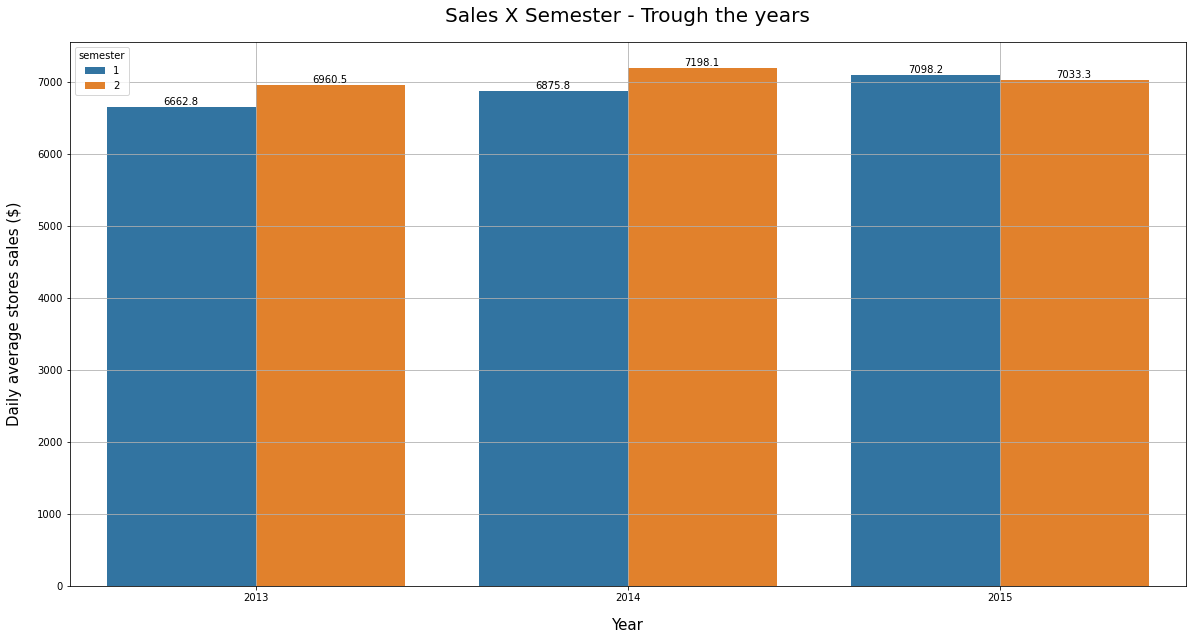

In [98]:
# creating an auxilar dataset
aux = df3[['year', 'semester', 'sales']].groupby(['year', 'semester']).mean().reset_index()

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['year'], y= aux['sales'], hue= aux['semester']);
ax.set_title("Sales X Semester - Trough the years", size = 20, pad= 20)
ax.set_ylabel('Daily average stores sales ($)', size= 15, labelpad= 15)
ax.set_xlabel('Year', size= 15, labelpad= 15)
ax.grid()

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
           (p.get_x() + p.get_width() / 2., p.get_height()), 
           ha = 'center', va = 'center', 
           xytext = (0, 5), 
           textcoords = 'offset points')
    
# saving the graph as 'H_2' in the storytelling folder     
plt.savefig('../storytelling/H7_2.png')

***
**As seen above:**

- By looking the daily average sales trough the years, month by month, the pattern seen in the cumulative sales is the same, indicating that this behavior - which the stores are more likely to sells more at the second semester, is solid and atemporal.
<br>

- Is important to notice that the last date in the dataset is 31/07/2015, so there wasn't enough sales at second semester's sales yet. Thats why the second semester for 2015 bar column is smaller than the first semesters column, in the graph above.

### <font color=green size= 4>4.2.8 **HYPOTHESIS 8 (H8):** The total stores revenue increases year over year </font> - **FALSE**
***

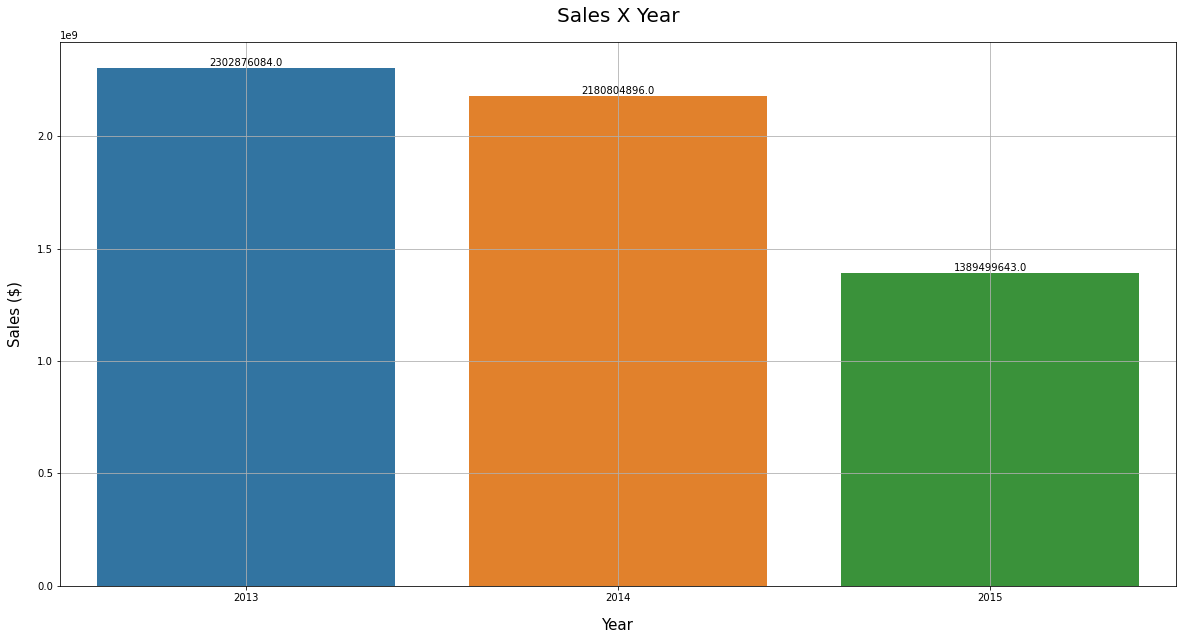

In [97]:
# creating an auxilar dataset
aux = df3[['year', 'sales']].groupby('year').sum().reset_index()

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['year'], y= aux['sales'])
ax.set_title("Sales X Year", size= 20, pad= 20)
ax.set_ylabel("Sales ($)", size= 15, labelpad= 15)
ax.set_xlabel("Year", size= 15, labelpad= 15)
ax.grid()

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
           (p.get_x() + p.get_width() / 2., p.get_height()), 
           ha = 'center', va = 'center', 
           xytext = (0, 5), 
           textcoords = 'offset points')

    
# saving the graph as 'H8' in the storytelling folder  
plt.savefig('../storytelling/H8.png')

***
**As seen above:**

- The 2015 bar column is so much lower than the others because the last date in the dataset was 31/07/2015, so this total year revenue wasn't complete.
<br>

- By looking the graph above, the total Rossmann store's revenue trough the years is going down. But there are just 2 valid year's samples, and more other year's informations are needed to conclude such an affirmative.

### <font color=green size= 4>4.2.9 **HYPOTHESIS 9 (H9):** Stores sales are more likely to increase the longer is its promotion 2 running time </font> - **FALSE**
***

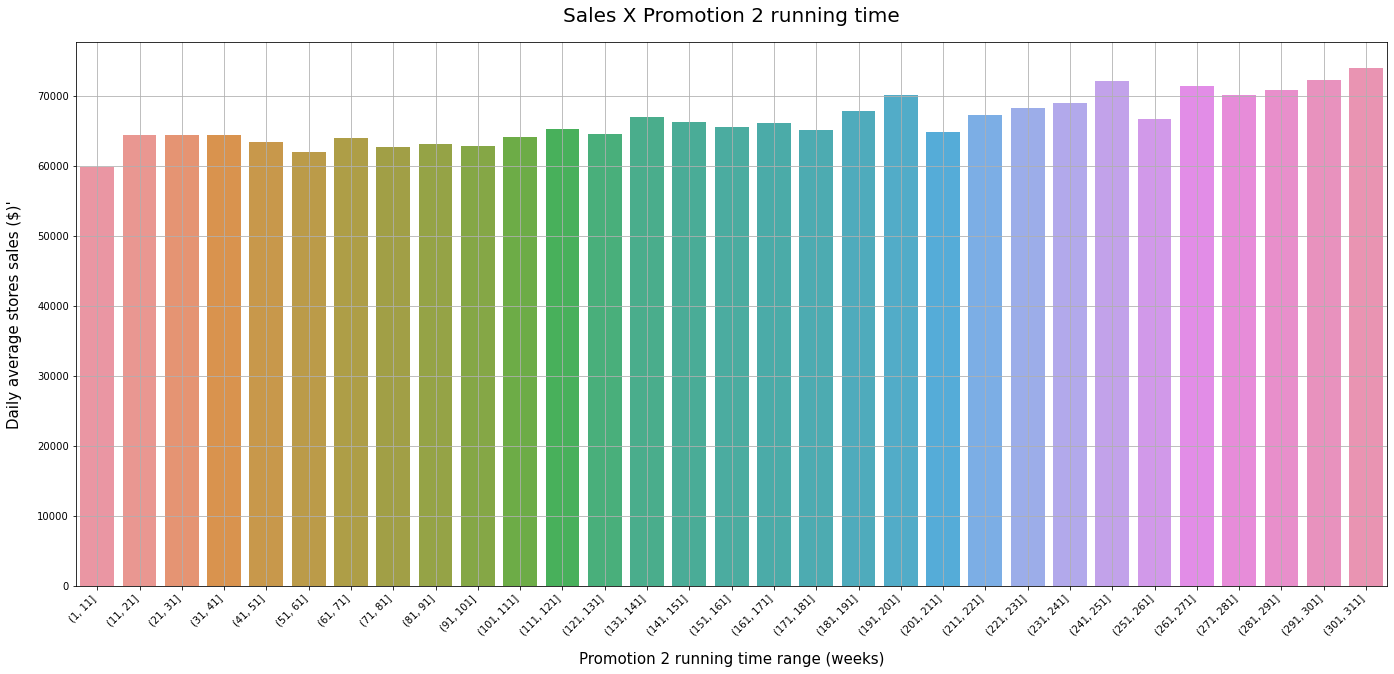

In [96]:
# creating an auxilar dataset
aux = df3[df3['promo2_time_week'] > 0][['promo2_time_week', 'sales']].groupby('promo2_time_week').mean().reset_index()

# creating the 'groups_customers' column
aux['groups_promo2_time_week'] = pd.cut(aux['promo2_time_week'], bins= list(np.arange(1, 315, 10)))

# grouping some 
aux = aux[['groups_promo2_time_week', 'sales']].groupby('groups_promo2_time_week').sum().reset_index()

# grouping the some auxilar dataset's columns
aux.dropna(inplace= True)  
    
# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['groups_promo2_time_week'], y= aux['sales'])
ax.set_title("Sales X Promotion 2 running time", size= 20, pad= 20)
ax.set_ylabel("Daily average stores sales ($)'", size= 15, labelpad= 15)
ax.set_xlabel("Promotion 2 running time range (weeks)", size= 15, labelpad= 15)
ax.grid()

for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

# adjusting subplot
plt.tight_layout(pad= 3)

# saving the graph as 'H9' in the storytelling folder  
plt.savefig('../storytelling/H9.png')

***
**As seen above:**

- There is no pattern that indicates that the daily average sale increases as longer is the promotion 2 running time. 
<br> 

- Also, the behavior varies a lot through the promotion 2 running time range, which sometimes increases the store sales, and sometimes decreases the store sales.

### <font color=green size= 4>4.2.10 **HYPOTHESIS 10 (H10):** Stores daily sales increases the more consecutive promotions it has </font> - **FALSE**
***

In [47]:
# creating an auxilar dataset
aux = df3[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index()

# displaying the auxilar dataset
aux

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


***
**As seen above:**

- Stores with only promotion **`promo`** running, in the big picture (cumulative sales), are more likely to sell more than the others.
<br>

- Stores with both promotions running, in the big picture (cumulative sales), have a significant daily average sales too.

Then, we are going to verify if this behavior is continuous trough the time serie.

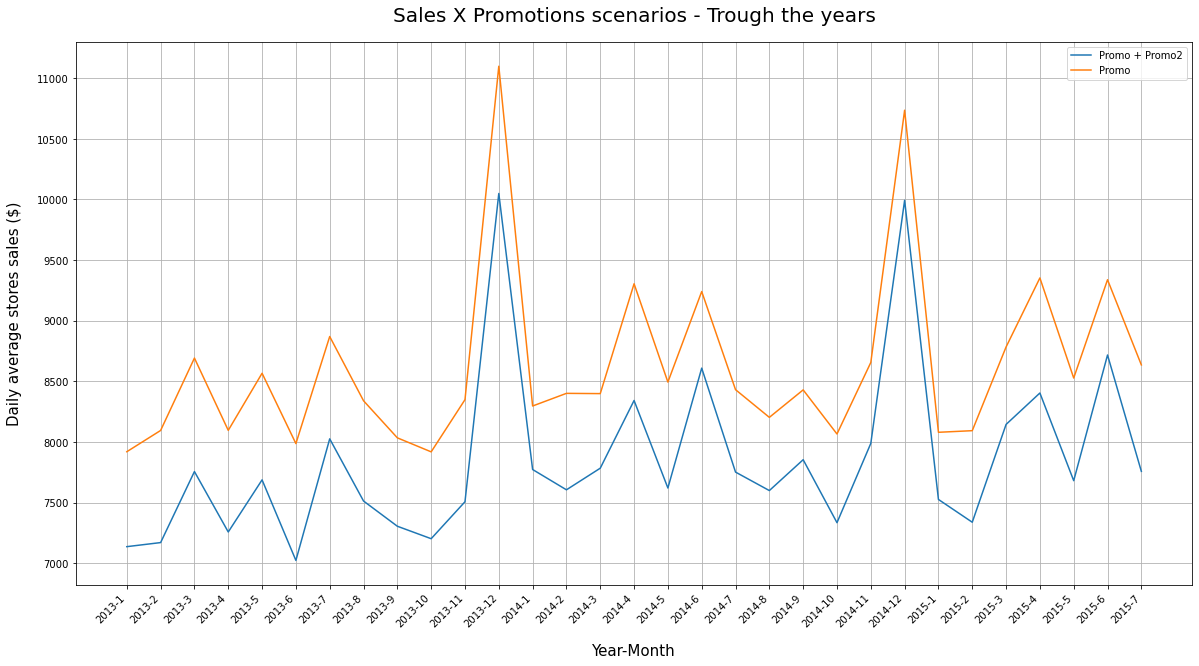

In [48]:
# creating an auxilar dataset
aux_2_prom = df3[(df3['promo']==1) & (df3['promo2']==1)][['year', 'month', 'sales']].groupby(['year', 'month']).mean().reset_index()

# creating an auxilar dataset
aux_1_prom = df3[(df3['promo']==1) & (df3['promo2']==0)][['year', 'month', 'sales']].groupby(['year', 'month']).mean().reset_index()

# creating a dictionary with the months numeral relations       
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# creating the 'month_num' in the 'aux_2_prom' dataset
aux_2_prom['month_num'] = aux_2_prom['month'].map(month_map)

# creating the 'month_num' in the 'aux_1_prom' dataset
aux_1_prom['month_num'] = aux_1_prom['month'].map(month_map)

# sorting the 'aux_2_prom' dataset by 'year' and 'month_num' columns
aux_2_prom.sort_values(['year', 'month_num'], ascending= [True, True], inplace= True)

# sorting the 'aux_1_prom' dataset by 'year' and 'month_num' columns
aux_1_prom.sort_values(['year', 'month_num'], ascending= [True, True], inplace= True)

# creating the 'year-month' column, concatenating the 'year' and 'month_num' column infos, in the 'aux_2_prom' dataset
aux_2_prom['year-month'] = aux_2_prom['year'].astype(str) + '-' + aux_2_prom['month_num'].astype(str)

# creating the 'year-month' column, concatenating the 'year' and 'month_num' column infos, in the 'aux_1_prom' dataset
aux_1_prom['year-month'] = aux_1_prom['year'].astype(str) + '-' + aux_1_prom['month_num'].astype(str)

# creating a figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# setting ax graph, title, labels, ticks and sizes
sns.lineplot(ax= ax, x= aux_2_prom['year-month'], y= aux_2_prom['sales'])
sns.lineplot(ax= ax, x= aux_1_prom['year-month'], y= aux_1_prom['sales'])
ax.set_title("Sales X Promotions scenarios - Trough the years", size= 20, pad= 20)
ax.set_ylabel("Daily average stores sales ($)", size= 15, labelpad= 15)
ax.set_xlabel("Year-Month", size= 15, labelpad= 15)
ax.legend(labels=['Promo + Promo2', 'Promo'])
ax.grid()

#
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
    
# saving the graph as 'H10' in the storytelling folder  
plt.savefig('../storytelling/H10.png')

***
**As seen above:**

- By looking the daily average sales trough the years, month by month, the pattern seen in the cumulative sales is the same, indicating that this behavior - which the stores are more likely to sells more daily running only promotion **`promo`** than running two promotions, is solid and atemporal.

### <font color=green size= 4>4.2.11 **HYPOTHESIS 11 (H11):** Stores daily sales increases the more variate its assortment level is </font> - **TRUE**
***

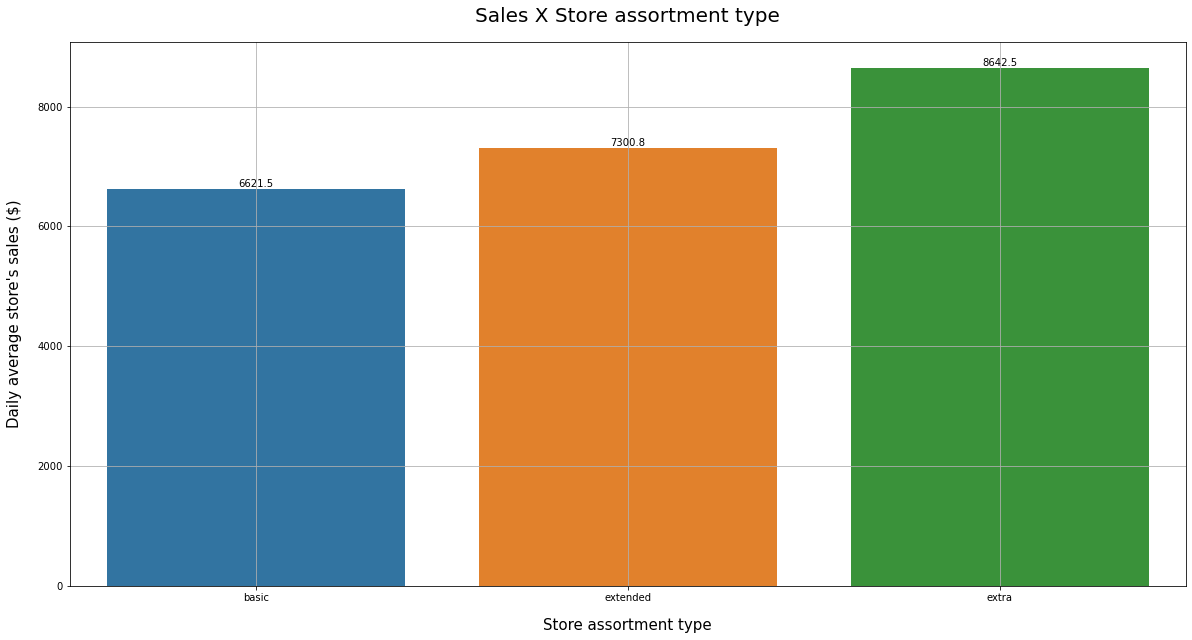

In [95]:
# creating an auxilar dataset
aux = df3[['assortment', 'sales']].groupby('assortment').mean().reset_index()

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['assortment'], y= aux['sales'])
ax.set_title("Sales X Store assortment type", size= 20, pad= 20)
ax.set_ylabel("Daily average store's sales ($)", size= 15, labelpad= 15)
ax.set_xlabel("Store assortment type", size= 15, labelpad= 15)
ax.grid()

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
           (p.get_x() + p.get_width() / 2., p.get_height()), 
           ha = 'center', va = 'center', 
           xytext = (0, 5), 
           textcoords = 'offset points')

# saving the graph as 'H11_1' in the storytelling folder  
plt.savefig('../storytelling/H11_1.png')

***
**As seen above:**

- By looking the big picture (cumulative sales), the stores increases their daily average sales by selling more assorted products.
<br>

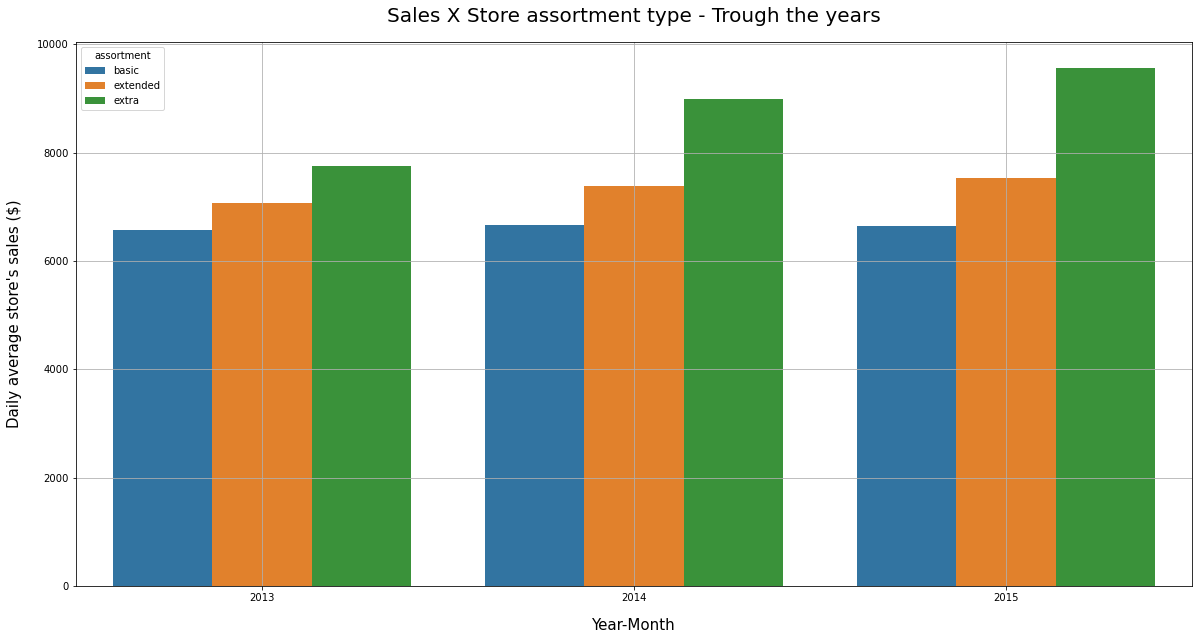

In [94]:
# creating an auxilar dataset
aux = df3[['year', 'assortment', 'sales']].groupby(['year', 'assortment']).mean().reset_index()

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['year'], y= aux['sales'], hue= aux['assortment']);
ax.set_title("Sales X Store assortment type - Trough the years", size = 20, pad= 20)
ax.set_ylabel("Daily average store's sales ($)", size= 15, labelpad= 15)
ax.set_xlabel('Year-Month', size= 15, labelpad= 15)
ax.grid()

# saving the graph as 'H11_2' in the storytelling folder     
plt.savefig('../storytelling/H11_2.png')

***
**As seen above:**

- By looking the daily average sales trough the years, month by month, the pattern seen in the cumulative sales is the same, indicating that this behavior - which the stores are more likely to sells more daily when selling more assorted products, is solid and atemporal.
<br>

### <font color=green size= 4>4.2.12 **HYPOTHESIS 12 (H12):** Stores sales increases the longer its closest competitor exists </font> - **TRUE**
***

In [51]:
print(f"Max months in competition: {df3['competition_time_month'].unique().max()}")
print(f"Min months in competition: {df3['competition_time_month'].unique().min()}")

Max months in competition: 1361
Min months in competition: -31


***
**As seen above:**

There are negative and positive values, and we will consider them as the follow: 

- **Stores with negative competition months** are store that already knew when they competitor was going to inaugurate their store in the future.
<br>

- **Stores with positive competition months** are store that are already in a competition.

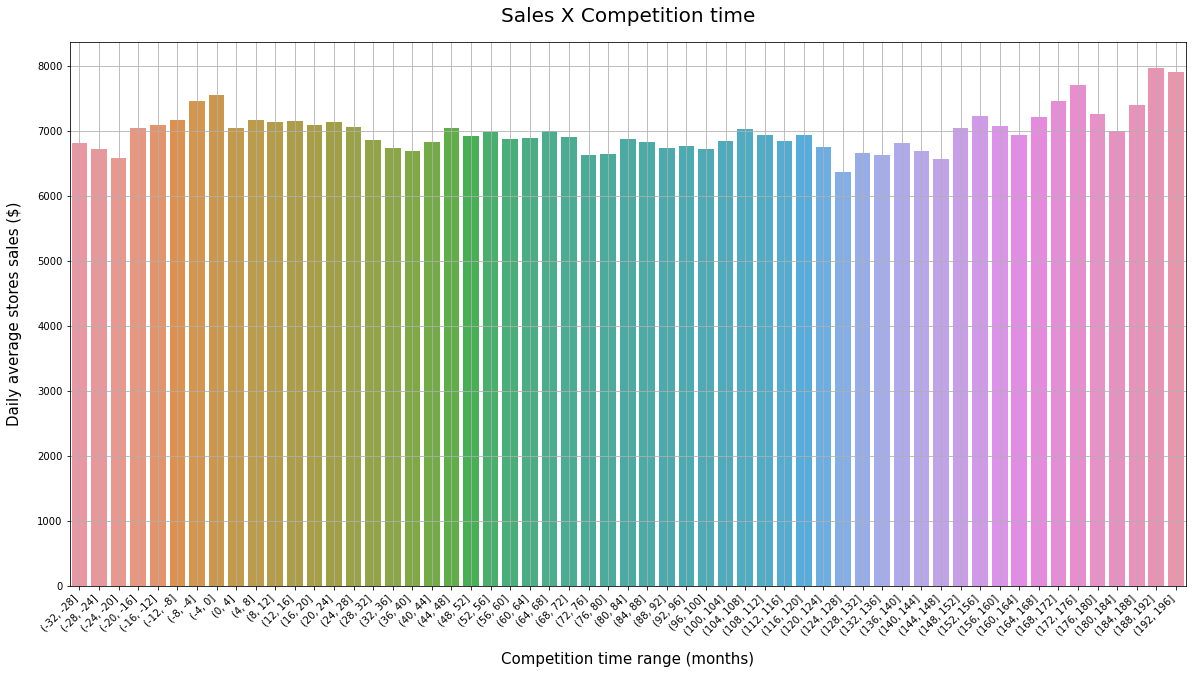

In [93]:
# creating an auxilar dataset
aux = df3[df3['competition_time_month'] !=0]

# grouping the some auxilar dataset's columns
aux = aux[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()

# creating the 'groups_competition_time_month' column
aux['groups_competition_time_month'] = pd.cut(aux['competition_time_month'], bins= list(np.arange(-32, 200, 4)))

# grouping the some auxilar dataset's columns
aux = aux[['groups_competition_time_month', 'sales']].groupby('groups_competition_time_month').mean().reset_index()

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['groups_competition_time_month'], y= aux['sales'])
ax.set_title("Sales X Competition time", size= 20, pad= 20)
ax.set_ylabel("Daily average stores sales ($)", size= 15, labelpad= 15)
ax.set_xlabel("Competition time range (months)", size= 15, labelpad= 15)
ax.grid()

# rotating the x axis labels
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
    
# saving the graph as 'H12_1' in the storytelling folder  
plt.savefig('../storytelling/H12.png')

***
**As seen above:**

- As seen in section 4.2.1, there isn't a clearly visible sales behavior when considering the competitor's influence, over the Rossmann stores.
<br>

- Also, the behavior varies a lot through the competition time range, with sometimes increases the store sales, and sometime decreases the store sales.

### <font color=green size= 4>4.2.13 **HYPOTHESIS 13 (H13):** Stores sales increases during the schools holidays </font> - **TRUE**
***

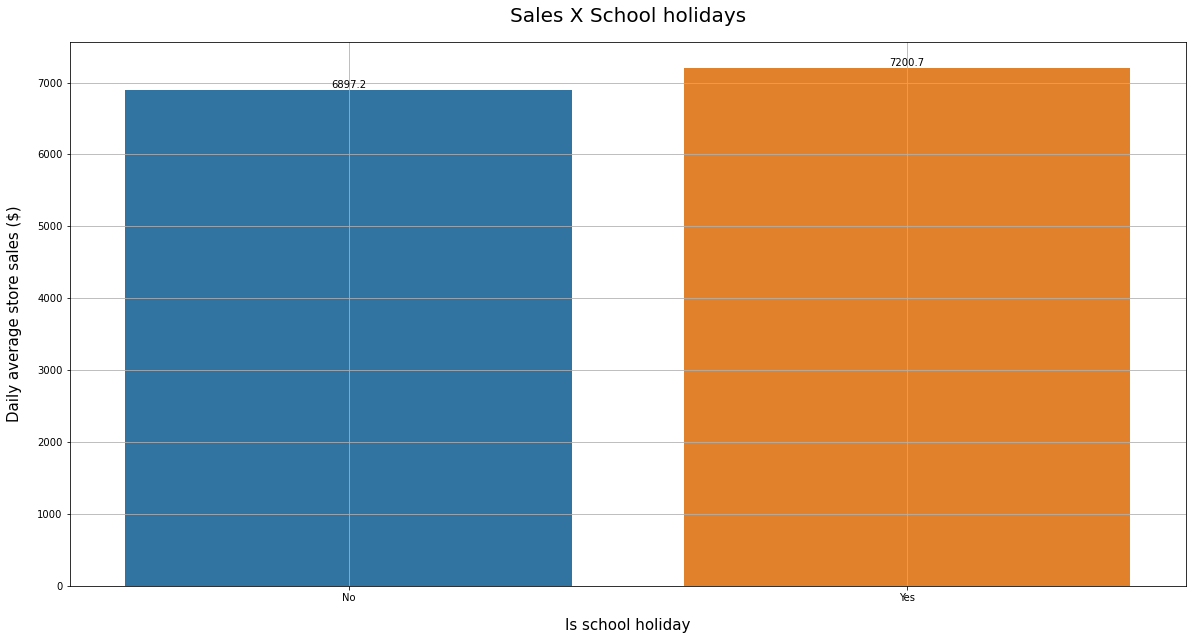

In [92]:
# creating an auxiliar dataset
aux = df3[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['school_holiday'], y= aux['sales'])
ax.set_title("Sales X School holidays", size= 20, pad= 20)
ax.set_ylabel("Daily average store sales ($)", size= 15, labelpad= 15)
ax.set_xlabel("Is school holiday", size= 15, labelpad= 15)
ax.set_xticklabels(labels= ['No', 'Yes'])
ax.grid()

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
           (p.get_x() + p.get_width() / 2., p.get_height()), 
           ha = 'center', va = 'center', 
           xytext = (0, 5), 
           textcoords = 'offset points')

# saving the graph as 'H13_1' in the storytelling folder  
plt.savefig('../storytelling/H13_1.png')

***
**As seen above:**

- By looking the big picture (cumulative sales), the stores increases their daily average sales on school holidays.
<br>

- The difference between the daily average sales on school holidays and daily average sales not on school holidays is very low, something that is needed to be check through all the years.

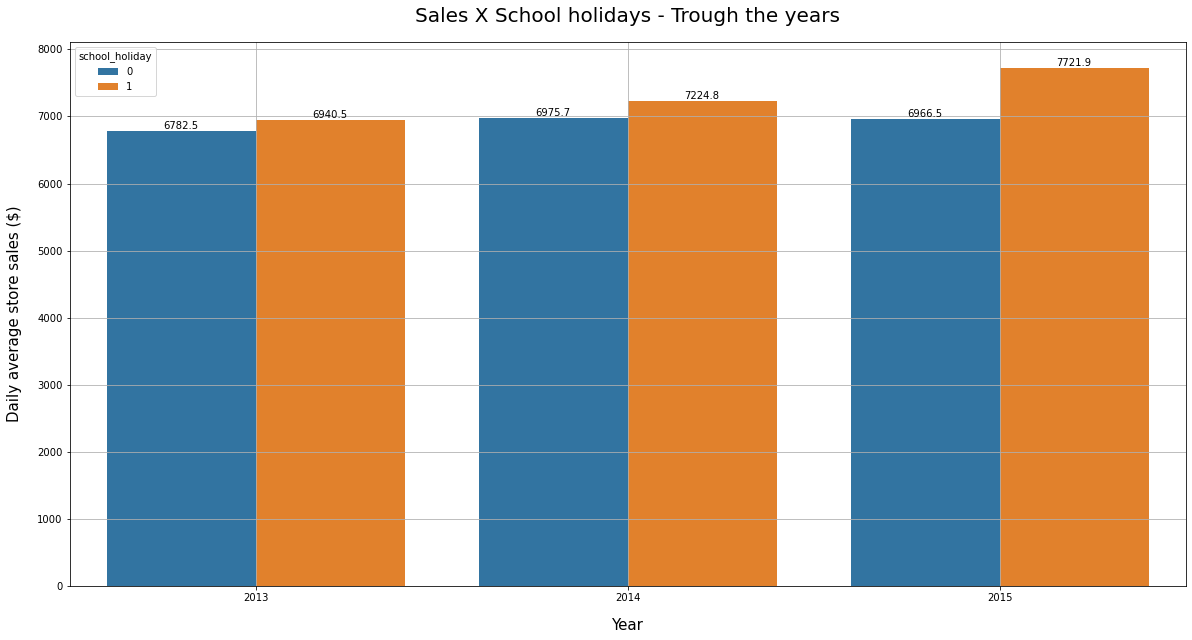

In [91]:
# creating an auxiliar dataset
aux = df3[['year', 'school_holiday', 'sales']].groupby(['year', 'school_holiday']).mean().reset_index()

# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.barplot(x= aux['year'], y= aux['sales'], hue= aux['school_holiday'])
ax.set_title("Sales X School holidays - Trough the years", size= 20, pad= 20)
ax.set_ylabel("Daily average store sales ($)", size= 15, labelpad= 15)
ax.set_xlabel("Year", size= 15, labelpad= 15)
ax.grid()

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
           (p.get_x() + p.get_width() / 2., p.get_height()), 
           ha = 'center', va = 'center', 
           xytext = (0, 5), 
           textcoords = 'offset points')

    
# saving the graph as 'H13_2' in the storytelling folder  
plt.savefig('../storytelling/H13_2.png')

***
**As seen above:**

- By looking the daily average sales trough the years, month by month, the pattern seen in the cumulative sales is the same, indicating that this behavior - which the stores are more likely to sells more on school holidays than not on school holidays, is solid and atemporal.

## <font color=green size= 5>4.3 MULTIVARIATE ANALYSIS </font>
***

### <font color=green size= 4>4.3.1 NUMERICAL FEATURES CORRELATION </font>
***

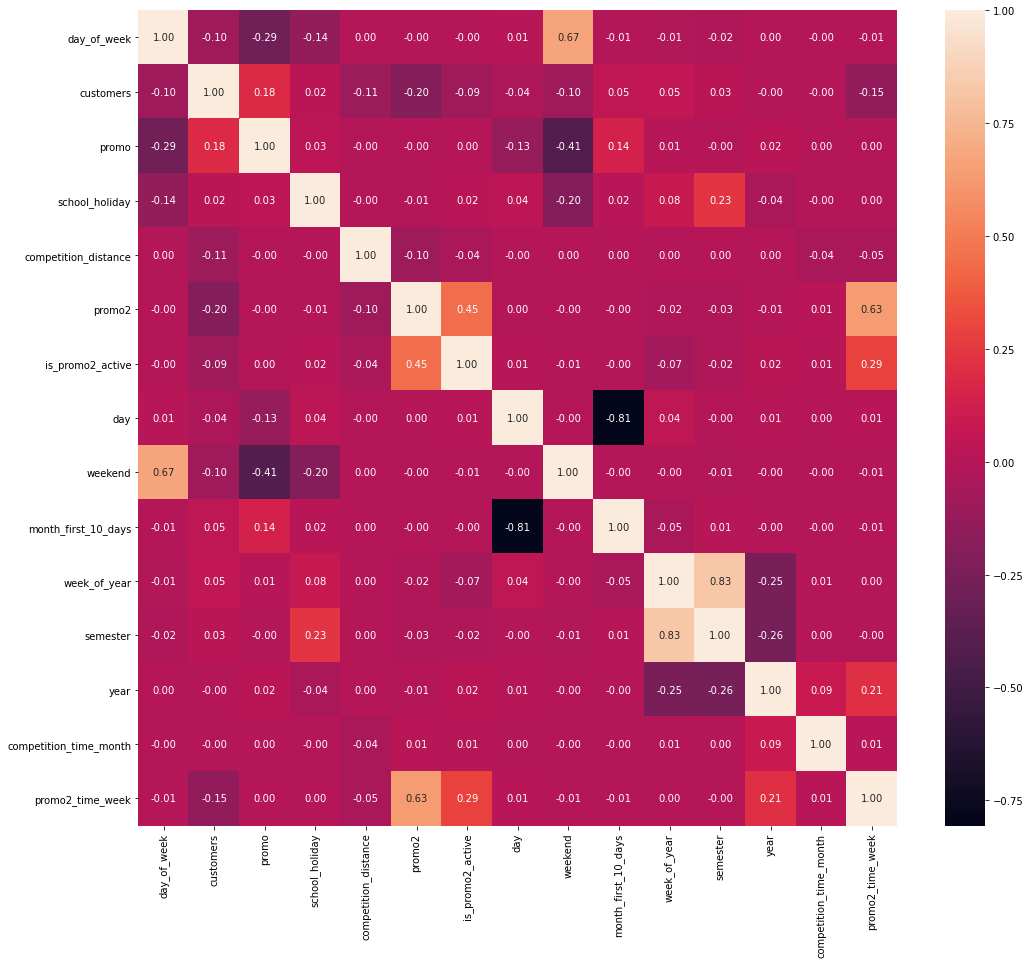

In [55]:
# creating a dataset with only the numerical values from 'df3' dataset
df3_num = df3.select_dtypes(include= ['float64', 'int64', 'int32'])

# removing the 'sales' and 'store' columns, which we are not interesed now
df3_num.drop(columns = ['sales', 'store'], axis= 1, inplace= True)

# creating a figure and adjusting its size
plt.figure(figsize= (17, 15))

# creating a correlation matrix from 'df3_num' dataframe
corre_num = df3_num.corr(method = 'pearson')

# creating a heatmap graph using the correlation matrix 'corre_num' as data
ax = sns.heatmap(corre_num, annot = True, fmt= '.2f')

# plotting the heat map
ax;

# saving the graph as 'num_features_relations_1' in the storytelling folder  
plt.savefig('../storytelling/num_features_relations_1.png')

***
**As seen above:**

There aren't variables that have a strong correlation between them, so we don't need to bother to delete them for now.

**There are a few correlated variables, which are:**

- **`weekend`**                and   **`day`**                  (67% correlation)
- **`promo2`**                 and   **`promo2_time_week`**     (63% correlation)
- **`is_promo2_active`**       and   **`promo2`**               (45% correlation)
- **`promo2_time_week`**       and   **`is_promo2_active`**     (45% correlation)

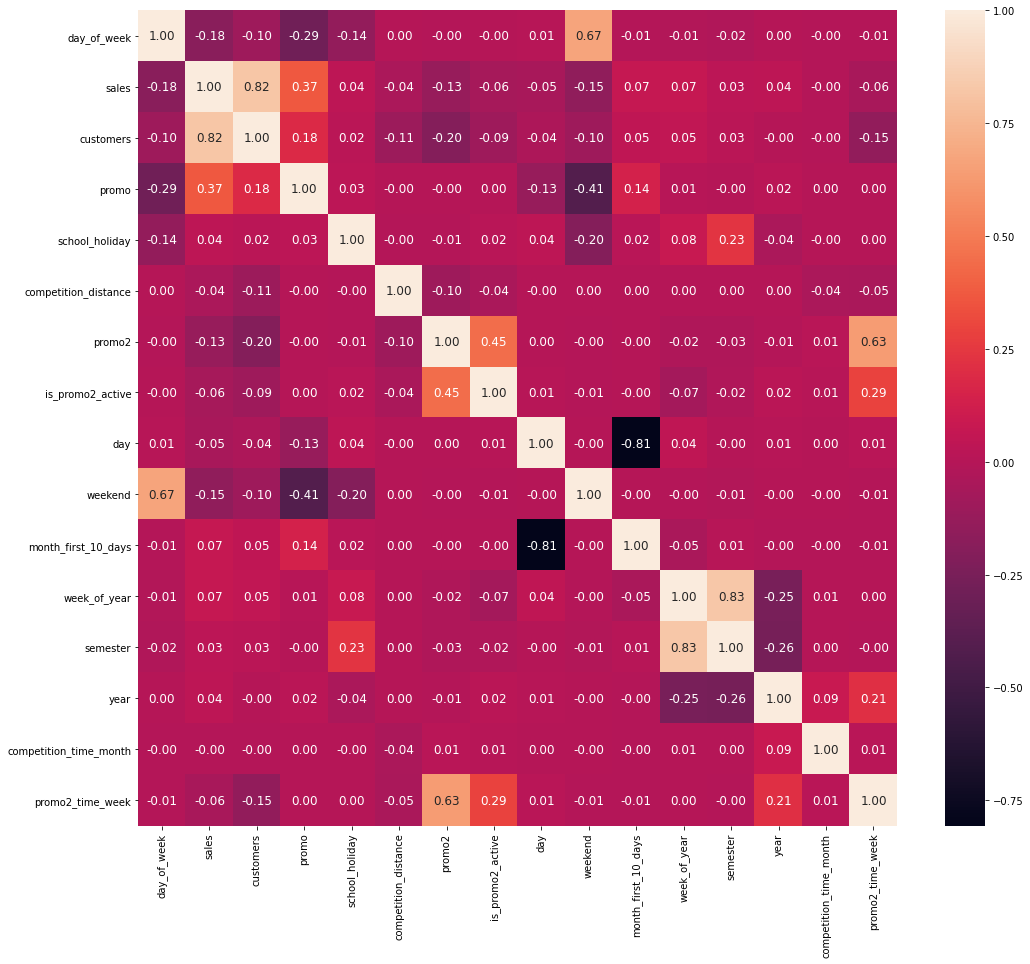

In [56]:
# creating a dataset with only the numerical values from 'df3' dataset
df3_num = df3.select_dtypes(include= ['float64', 'int64', 'int32'])

# removing the 'store' column, which we are not interesed now
df3_num.drop(columns = ['store'], axis= 1, inplace= True)

# creating a correlation matrix from 'df3_num' dataset
corre_num = df3_num.corr()

# creating a figure and adjusting its size
plt.figure(figsize= (17, 15))

# creating a heatmap graph using the correlation matrix 'corre_num' as data
ax= sns.heatmap(corre_num, annot= True, fmt= ".2f", annot_kws= {"size":12})

# plotting the heat map
ax;

# saving the graph as 'num_features_relations_2' in the storytelling folder  
plt.savefig('../storytelling/num_features_relations_2.png')

***
**As seen above:** 
<br>

**There are some numerical variables that have considerable impact over `sales` label value:**

- **`customers`** (82% correlation)
- **`promo`** (37% correlation)
- **`day_of_week`** (-18% correlation)
- **`weekend`** (-15% correlation)
- **`promo2`** (-13% correlation)

### <font color=green size= 4>4.3.2 CATEGORICAL FEATURES CORRELATION </font>
***

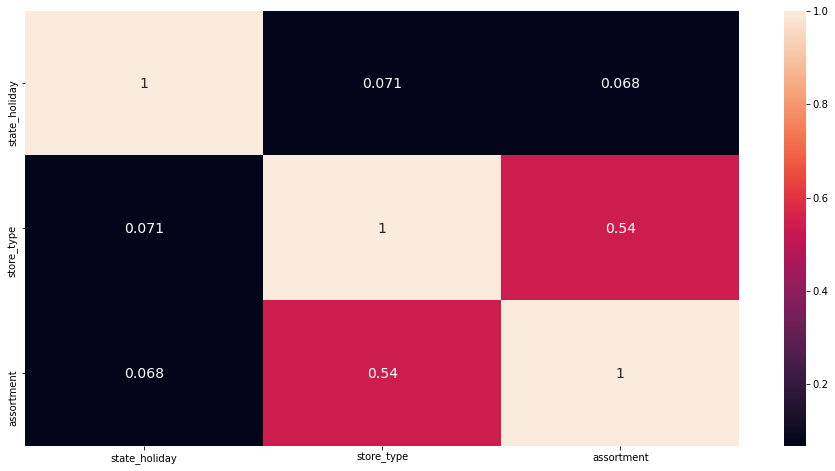

In [57]:
# creating a dataset with only the categorical values from 'df3' dataset
df3_cat = df3.select_dtypes(exclude= ['float64', 'int64', 'int32', 'datetime64[ns]'])

# making all the possible combinations between categorical variables
a1 = cramer_v(df3_cat['state_holiday'], df3_cat['state_holiday'])
a2 = cramer_v(df3_cat['state_holiday'], df3_cat['store_type'])
a3 = cramer_v(df3_cat['state_holiday'], df3_cat['assortment'])

a4 = cramer_v(df3_cat['store_type'], df3_cat['state_holiday'])
a5 = cramer_v(df3_cat['store_type'], df3_cat['store_type'])
a6 = cramer_v(df3_cat['store_type'], df3_cat['assortment'])

a7 = cramer_v(df3_cat['assortment'], df3_cat['state_holiday'])
a8 = cramer_v(df3_cat['assortment'], df3_cat['store_type'])
a9 = cramer_v(df3_cat['assortment'], df3_cat['assortment'])

# building the dataset to make the correlations
corre_cat = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

# setting index equal to columns
corre_cat = corre_cat.set_index(corre_cat.columns)

# using the variable ax for single a axes
fig, ax = plt.subplots()

# setting the figure size in inches
ax.figure.set_size_inches(16, 8)

# plotting the heatmap
sns.heatmap(corre_cat, annot=True, annot_kws={"fontsize":14})

# displaying the plot
plt.show()

# saving the graph as 'cat_features_relations' in the storytelling folder  
fig.savefig('../storytelling/cat_features_relations.png')

***
**As seen above:**

There aren't variables that have a strong correlation between them, so we don't need to bother to delete them for now.

**There are a few correlated variables, which are:**

- **`assortment`**                and   **`store_type`**                  (54% correlation)

Which makes sense. The larger the store, probably more assorted products it offers.

# <font color=green size= 6> <b>5. DATA PREPARATION </font></b>
***

In [58]:
# creating a dataframe's copy to work, from the original 'df3' dataframe
df4 = df3.copy()

# displaying the first 5 dataframe's registers 
df4.head()

,store,day_of_week,date,sales,customers,promo,state_holiday,school_holiday,store_type,assortment,...,is_promo2_active,day,weekend,month_first_10_days,week_of_year,season,semester,year,competition_time_month,promo2_time_week
0,1,5,2015-07-31,5263,555,1,regular,1,c,basic,...,0,31,0,0,31,Summer,2,2015,81,0
1,2,5,2015-07-31,6064,625,1,regular,1,a,basic,...,1,31,0,0,31,Summer,2,2015,91,279
2,3,5,2015-07-31,8314,821,1,regular,1,a,basic,...,1,31,0,0,31,Summer,2,2015,102,226
3,4,5,2015-07-31,13995,1498,1,regular,1,c,extended,...,0,31,0,0,31,Summer,2,2015,69,0
4,5,5,2015-07-31,4822,559,1,regular,1,a,basic,...,0,31,0,0,31,Summer,2,2015,3,0


## <font color=green size= 5>5.1 RESCALE AND NORMALIZE NUMERICAL FEATURES </font>
***

In the section we will executed the numerical variables rescaling and normalization. For this, these variables outliers must be known, to choose the best method to be applied.

**The techniques that will be used:**

- **RobustScaler:** Robust in the presence of outliers, will be applied at variables that have a significant amount of outliers 

- **MinMaxScaler:** Sensitive in the presence of outliers, will be applied at variables that have a significant amount of outliers 

As seen on section 4.1.2, all important numerical variables have significant amount of outliers, even with some outliers removal (on section 3.3), except the **`promo2_time_week`** feature.

In [59]:
# instantiating MinMaxScaler method as 'mms'
mms = MinMaxScaler()

# instantiating RobustScaler method as 'rs'
rs = RobustScaler()


# rescaling the dataset's 'promo2_time_week' feature 
df4['promo2_time_week'] = mms.fit_transform(df4[['promo2_time_week']].values)

# saving the 'promo2_time_week' feature rescaling method
pickle.dump(mms, open('../parameters/promo2_time_week_scaler.pkl', 'wb'))



# rescaling the dataset's 'competition_time_month' feature       
df4['competition_time_month'] = rs.fit_transform(df4[['competition_time_month']].values)

# saving the 'competition_time_month' feature rescaling method
pickle.dump(rs, open('../parameters/competition_time_month_scaler.pkl', 'wb'))



# rescaling the dataset's 'competition_distance' feature 
df4['competition_distance'] = rs.fit_transform(df4[['competition_distance']].values)

# saving the 'competition_distance' feature rescaling method
pickle.dump(rs, open('../parameters/competition_distance_scaler.pkl', 'wb'))



# rescaling the dataset's 'customers' feature 
df4['customers'] = rs.fit_transform(df4[['customers']].values)

# saving the 'customers' feature rescaling method
pickle.dump(rs, open('../parameters/customers_scaler.pkl', 'wb'))

## <font color=green size= 5>5.2 ENCODE CATEGORICAL FEATURES </font>
***

### <font color=green size= 4>5.2.1 BINARY CATEGORICAL FEATURES </font>
***

In [60]:
# creating a dictonary to replace the 'semester' column type to a numeral representative
semesters = {1: 0, 2: 1}

# transforming binary categorical's variables
df4['semester'] = df4['semester'].map(semesters)

### <font color=green size= 4>5.2.2 NOMINAL CATEGORICAL FEATURES </font>
***

In [61]:
# instantiating the OneHotEncoder method as 'ohe'
ohe = OneHotEncoder(cols= ['state_holiday'], use_cat_names= True)

# transforming the 'df4' dataset with the 'ohe' method
df4 = ohe.fit_transform(df4)

# saving the OneHotEncoder trained method
pickle.dump(ohe, open('../parameters/onehotencoder_state_holiday.pkl', 'wb'))

# renaming the columns created by the OneHotEncoder method
df4.rename(columns = {'state_holiday_regular': 'regular', 
                           'state_holiday_public': 'public', 
                           'state_holiday_easter': 'easter', 
                           'state_holiday_christmas': 'christmas'}, inplace= True)


# instantiating the OneHotEncoder method as 'ohe'
ohe = OneHotEncoder(cols= ['season'], use_cat_names= True)

# transforming the 'df4' dataset with the 'ohe' method
df4 = ohe.fit_transform(df4)

# saving the OneHotEncoder trained method
pickle.dump(ohe, open('../parameters/onehotencoder_season.pkl', 'wb'))

# renaming the columns created by the OneHotEncoder method
df4.rename(columns = {'season_Winter': 'winter', 
                      'season_Summer': 'summer', 
                      'season_Spring': 'spring',
                      'season_Fall':   'fall'}, inplace= True)

### <font color=green size= 4>5.2.3 ORDINAL CATEGORICAL FEATURES </font>
***

In [62]:
# Creating a dictionary with the assortment values relation. This because, as seen on section 4.2.11, there is a ordinal relation 
# between them
assortments = {'basic': 0, 'extended': 1, 'extra': 2}

# transforming the assortment column's objects into numerical values
df4['assortment'] = df4['assortment'].map(assortments)


# We could mapping the 'store_type' column as we did with 'assortment' column. But the column is already in a, b, c, d... values.
# Considering that it could have more than 15 possible values, it would be a waste of time to create a dictionary mapping 20 
# elements, and for this the label encoder fit perfectly.

# # instantiating the LabelEncoder method as 'le'
le = LabelEncoder()

# transforming the 'df4' dataset column 'store_type' with the 'le' method
df4['store_type'] = le.fit_transform(df4['store_type'])

# saving the LabelEncoder trained method
pickle.dump(le, open('../parameters/labelencoder_store_type.pkl', 'wb'))

## <font color=green size= 5>5.3 DATE FEATURES TRANSFORMATION  </font>
***

In the section we will executed the date variables transformation. This because date in general (days, weeks, months, years...) are cyclical and we are dealing this a regression method. So, for an example, if we let **`month`** column values between 1 and 12, we are saying that 12th month is 12 times farer from the 1st month than the 2nd month to the 1st month, which is a false affirmative. When analyzing it as a cyclical event, both have the same 'distance' to the 1st month.

So, to avoid this behavior, we will transform all date features into a sine and cosine values, creating two cyclical date features to replace the original one.

In [63]:
# transforming the 'day' column values into sine and cosine values and creating the new features
df4['day_sin'] = df4['day'].apply(lambda x: np.sin(x *(2. * np.pi / 30)))
df4['day_cos'] = df4['day'].apply(lambda x: np.cos(x *(2. * np.pi / 30)))

# transforming the 'day_of_week' column values into sine and cosine values and creating the new features
df4['day_of_week_sin'] = df4['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi / 7)))
df4['day_of_week_cos'] = df4['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi / 7)))

# creating a dictionary with the months numerical values            
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 
             'Oct': 10, 'Nov': 11, 'Dec': 12}

# creating a 'month' column with the 'date' column's month and transforming it by maping the 'month_map' dictionary
df4['month'] = df4['month'].map(month_map)

# transforming the 'month' column values into sine and cosine values and creating the new features
df4['month_sin'] = df4['month'].apply(lambda x: np.sin(x *(2. * np.pi / 12)))
df4['month_cos'] = df4['month'].apply(lambda x: np.cos(x *(2. * np.pi / 12)))

# transforming the 'week_of_year' column values into sine and cosine values and creating the new features
df4['week_of_year_sin'] = df4['week_of_year'].apply(lambda x: np.sin(x *(2. * np.pi / 52)))
df4['week_of_year_cos'] = df4['week_of_year'].apply(lambda x: np.cos(x *(2. * np.pi / 52)))

# removing the original date columns from the dataset
df4.drop(columns= ['day', 'day_of_week', 'month', 'week_of_year'], inplace= True)

## <font color=green size= 5>5.4 TRANSFORM RESPONSE FEATURE  </font>
***

As seen in section 4.1.3, the **`sales`** label have a significant amount of outliers, and we couldn't treat it by deleting them, explained in section 3.3.

Then, we will apply a logarithm transformation over the **`sales`** label, trying to approximate its distribution to a normal curve.

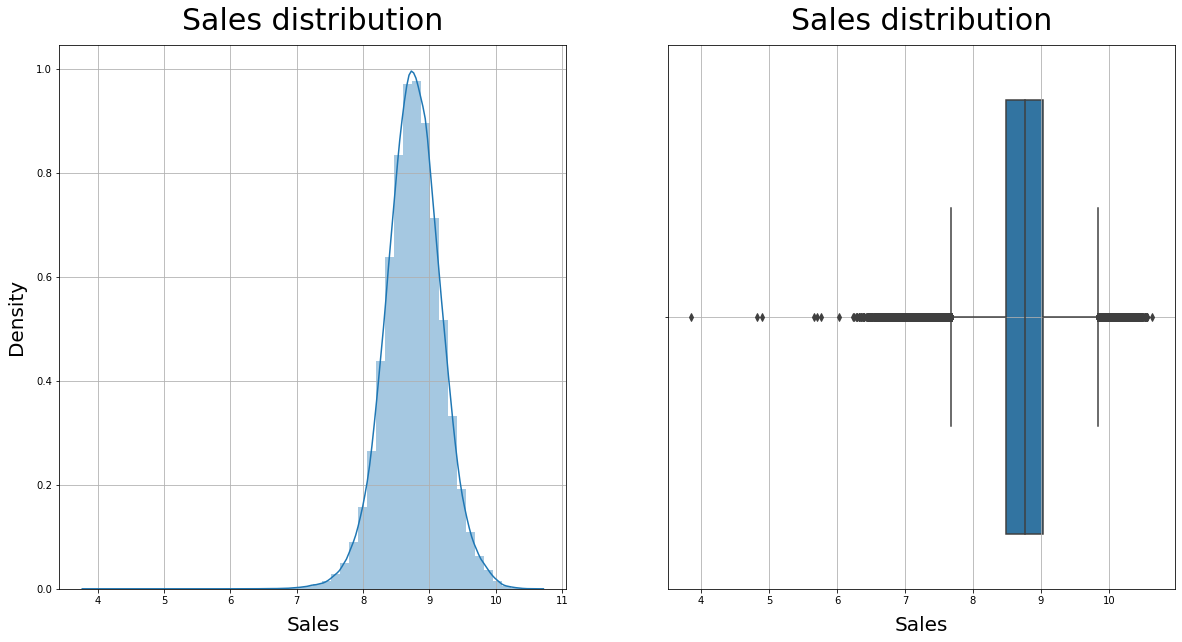

In [64]:
# transforming the 'sales' column original values into logarithmic values
df4['sales'] = np.log1p(df4['sales'])

# creating a figure
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# setting first graph, title, labels, ticks and sizes
sns.distplot(ax= axes[0], x= df4['sales'], kde= True)
axes[0].set_title('Sales distribution', size= 30, pad= 15)
axes[0].set_xlabel('Sales', size= 20, labelpad= 10)
axes[0].set_ylabel('Density', size= 20, labelpad= 10)
axes[0].grid()

# setting second graph, title, labels, ticks and sizes
sns.boxplot(ax= axes[1], x= df4['sales'])
axes[1].set_title('Sales distribution', size= 30, pad= 15)
axes[1].set_xlabel('Sales', size= 20, labelpad= 10)
axes[1].grid()

***
**As seen above:**

The **`sales`** logarithmic distribution is now closer to a normal distribution, which is a premise for the regressive models that we will apply to work and predict properly.
<br>

# <font color=green size= 6> <b>6. FEATURE SELECTION </font></b>
***

In [65]:
# creating a dataframe's copy to work, from the original 'df4' dataframe
df5 = df4.copy()

# displaying the first 5 dataframe's registers 
df5.head()

,store,date,sales,customers,promo,regular,public,easter,christmas,school_holiday,...,competition_time_month,promo2_time_week,day_sin,day_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.568646,-0.323529,1,1,0,0,0,1,...,0.915493,0.287016,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984
1,2,2015-07-31,8.710290,-0.136364,1,1,0,0,0,1,...,1.056338,0.922551,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984
2,3,2015-07-31,9.025816,0.387701,1,1,0,0,0,1,...,1.211268,0.801822,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984
3,4,2015-07-31,9.546527,2.197861,1,1,0,0,0,1,...,0.746479,0.287016,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984
4,5,2015-07-31,8.481151,-0.312834,1,1,0,0,0,1,...,-0.183099,0.287016,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984


## <font color=green size= 5>6.1 SPLIT TRAIN & TEST DATASET BY TIME SERIE </font>
***

In [66]:
# priting the maximum and minimum date values
print(f"The max date is: {df5['date'].max()}")
print(f"The min date is: {df5['date'].min()}")

The max date is: 2015-07-31 00:00:00
The min date is: 2013-01-01 00:00:00


In [67]:
# splitting the 'df5' dataset by the date into two arrays (train) then splitting again by the features and labels columns
x_train_time = df5[df5['date'] < (df5['date'].max() - datetime.timedelta(days=42))]
y_train_time = df5[df5['date'] < (df5['date'].max() - datetime.timedelta(days=42))]['sales']

# splitting the 'df5' dataset by the date into two arrays (test) then splitting again by the features and labels columns
x_test_time = df5[df5['date'] >= (df5['date'].max() - datetime.timedelta(days=42))]
y_test_time = df5[df5['date'] >= (df5['date'].max() - datetime.timedelta(days=42))]['sales']

# printing the train and test arrays maximum's and minimum's date values
print('Traning Min Date: {}'.format(x_train_time['date'].min()))
print('Traning Max Date: {}'.format(x_train_time['date'].max()))
print('\nTest Min Date: {}'.format(x_test_time['date'].min()))
print('Test Max Date: {}'.format(x_test_time['date'].max()))

Traning Min Date: 2013-01-01 00:00:00
Traning Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## <font color=green size= 5>6.2 BORUTA BEST FEATURES SELECTION </font>
***

**Boruta library:** <a href="https://pypi.org/project/Boruta/">Here</a></font>

In [68]:
# defining model that will be checked by the boruta method
rfr_model = RandomForestRegressor(n_jobs = -1, random_state= 301)

# defining the train arrays
x_train_boruta = x_train_time.drop(columns= ['date', 'sales']).values
y_train_boruta = y_train_time.values.ravel()

# instantiating the boruta method
boruta = BorutaPy(rfr_model, n_estimators= 'auto', verbose= 2, random_state= 301)

# training the boruta method
boruta.fit(x_train_boruta, y_train_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	14
Tentative: 	0
Rejected: 	17


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	14
Tentative: 	0
Rejected: 	17


BorutaPy(estimator=RandomForestRegressor(n_estimators=78, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x1F33C7CB040),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1F33C7CB040, verbose=2)

In [69]:
# instantiating the dataset selected columns by the boruta method
cols = boruta.support_.tolist()
boruta_selected_features = x_train_time.drop(columns= ['date', 'sales']).iloc[:, cols].columns.to_list()

# displaying the selected features by boruta
print('Boruta selected features:')
boruta_selected_features

Boruta selected features:


['store',
 'customers',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'promo2',
 'competition_time_month',
 'promo2_time_week',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'week_of_year_cos']

## <font color=green size= 5>6.3 MANUAL BEST FEATURES SELECTION </font>
***

In [70]:
# creating a list with the feature that we will add to the boruta selected features, because of its correlation with the 'sales'
features_to_add = ['weekend', 'day_sin', 'month_sin', 'week_of_year_sin']

# creating a list with only the selected variables, by analising the boruta's selected features and the feature correlation at 
#section 4.3
manual_selected_features = boruta_selected_features.copy()
manual_selected_features.extend(features_to_add)

# creating a list with only the selected variables, the 'date' feature and the 'sales' label, for the cross validation method
manual_selected_features_cross = manual_selected_features.copy()
manual_selected_features_cross.extend(['date', 'sales']) 

## <font color=green size= 5>6.4 SPLIT TRAIN & TEST DATASET BY FEATURES </font>
***

In [71]:
# instantiating the train arrays
x_train = x_train_time[manual_selected_features]
y_train = y_train_time.copy()

# instantiating the test arrays
x_test =  x_test_time[manual_selected_features]
y_test =  y_test_time.copy()

# instantiating the cross validation array
x_train_test_cross = df5[manual_selected_features_cross]

### <font color=green size= 5>6.5 CHECKPOINT </font>
***

In [72]:
# saving the manual selected columns for test and cross validation evaluation methods
pickle.dump(manual_selected_features, open('../parameters/manual_selected_features.pkl', 'wb'))
pickle.dump(manual_selected_features_cross, open('../parameters/manual_selected_features_cross.pkl', 'wb'))

# saving all train and test arrays
pickle.dump(x_train_time, open('../parameters/x_train_time.pkl', 'wb'))
pickle.dump(y_train_time, open('../parameters/y_train_time.pkl', 'wb'))
pickle.dump(x_test_time, open('../parameters/x_test_time.pkl', 'wb'))
pickle.dump(y_test_time, open('../parameters/y_test_time.pkl', 'wb'))
pickle.dump(x_train, open('../parameters/x_train.pkl', 'wb'))
pickle.dump(y_train, open('../parameters/y_train.pkl', 'wb'))
pickle.dump(x_test, open('../parameters/x_test.pkl', 'wb'))
pickle.dump(y_test, open('../parameters/y_test.pkl', 'wb'))
pickle.dump(x_train_test_cross, open('../parameters/x_train_test_cross.pkl', 'wb'))

# saving the 'x_test_time' as a .csv file
x_test_time.to_csv("../data/x_test_time.csv", index= False)

In [73]:
# loading the manual selected columns for test and cross validation evaluation methods
manual_selected_features =       pickle.load(open('../parameters/manual_selected_features.pkl', 'rb'))
manual_selected_features_cross = pickle.load(open('../parameters/manual_selected_features_cross.pkl', 'rb'))

# loading all train and test arrays
x_train_time       = pickle.load(open('../parameters/x_train_time.pkl', 'rb'))
y_train_time       = pickle.load(open('../parameters/y_train_time.pkl', 'rb'))
x_test_time        = pickle.load(open('../parameters/x_test_time.pkl', 'rb'))
y_test_time        = pickle.load(open('../parameters/y_test_time.pkl', 'rb'))
x_train            = pickle.load(open('../parameters/x_train.pkl', 'rb'))
y_train            = pickle.load(open('../parameters/y_train.pkl', 'rb'))
x_test             = pickle.load(open('../parameters/x_test.pkl', 'rb'))
y_test             = pickle.load(open('../parameters/y_test.pkl', 'rb'))
x_train_test_cross = pickle.load(open('../parameters/x_train_test_cross.pkl', 'rb'))

# loading the 'x_test_time' as a .csv file
x_test_time = pd.read_csv("../data/x_test_time.csv")

# adjusting the 'x_test_time' dataset to ascending data registers
x_test_time.sort_values('date', ascending= True, inplace= True)

# <font color=green size= 6> <b>7. MACHINE LEARNING </font></b>
***

In [74]:
# creating a dataframe's copy to work, from the original 'df5' dataframe
df6 = df5.copy()

# displaying the first 5 dataframe's registers 
df6.head()

,store,date,sales,customers,promo,regular,public,easter,christmas,school_holiday,...,competition_time_month,promo2_time_week,day_sin,day_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.568646,-0.323529,1,1,0,0,0,1,...,0.915493,0.287016,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984
1,2,2015-07-31,8.710290,-0.136364,1,1,0,0,0,1,...,1.056338,0.922551,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984
2,3,2015-07-31,9.025816,0.387701,1,1,0,0,0,1,...,1.211268,0.801822,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984
3,4,2015-07-31,9.546527,2.197861,1,1,0,0,0,1,...,0.746479,0.287016,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984
4,5,2015-07-31,8.481151,-0.312834,1,1,0,0,0,1,...,-0.183099,0.287016,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984


In this section, we will finally apply the Machine Learning models in which the motivation to use these algorithms is to build an intelligent model to predict the daily sales for the next 6 weeks. For this, we will use following supervised task regressive models:

- Linear Regression
- Linear Regression Regularized model (Lasso)
- Random Forest Regressor 
- XGBoost Regressor
- CatBoost Regressor

## <font color=green size= 5>7.1 INSTANTIATE MODELS </font>
***

In [75]:
# instantiating the 'LinearRegression' model as 'lr'
lr = LinearRegression()

# instantiating the 'Lasso' model as 'lrr'
lrr = Lasso(alpha= 0.01, 
            random_state= 301)

# instantiating the 'RandomForestRegressor' model as 'rf_r'
rf_r = RandomForestRegressor(n_estimators= 100, n_jobs= -1, random_state= 301)

# instantiating the 'XGBRegressor' model as 'xgb_r'
xgb_r = xgb.XGBRegressor(objective= 'reg:squarederror',
                          n_estimators= 100, 
                          eta= 0.01, 
                          max_depth= 10, 
                          subsample= 0.7,
                          colsample_bytree= 0.9,
                          random_state= 301)

# instantiating the 'CatBoostRegressor' model as 'cat_r'
cat_r = CatBoostRegressor(random_state= 301, verbose= False)

## <font color=green size= 5>7.2 MODELS TRAINING AND PERFORMANCE RESULTS </font>
***

For this section, we will create an average model, which will serve as a baseline to compare the regressive models metrics. 

This average model consist in to consider all register's prediction as the mean value of all the register's sales.

In [76]:
# creating an empty dataset
y_test_avg_sales = pd.DataFrame()

# creating the 'sales' column in the dataset with the 'y_test' values
y_test_avg_sales['sales'] = y_test.copy()

# creating the 'predictions' column in the label test array and filling it with mean sales value
y_test_avg_sales['predictions'] = y_test_avg_sales['sales'].mean()

# calculating all evaluated metrics for the average model
MAE   = mean_absolute_error(np.expm1(y_test_avg_sales['sales']), np.expm1(y_test_avg_sales['predictions']))
MAPE  = mean_absolute_percentage_error(np.expm1(y_test_avg_sales['sales']), np.expm1(y_test_avg_sales['predictions']))
RMSE  = np.sqrt(mean_squared_error(np.expm1(y_test_avg_sales['sales']), np.expm1(y_test_avg_sales['predictions'])))
RMSPE = np.sqrt(np.mean(np.square((np.expm1(y_test_avg_sales['sales']) - np.expm1(y_test_avg_sales['predictions'])) / np.expm1(y_test_avg_sales['sales']))))
    
# creating a dataset to display the average model metrics
baseline_model_metrics = pd.DataFrame({'Model': 'Baseline Model',
                                       'MAE':    MAE,
                                       'MAPE':   MAPE,
                                       'RMSE':   RMSE,
                                       'RMSPE':  RMSPE}, index=[0])

# displaying the dataset
baseline_model_metrics

,Model,MAE,MAPE,RMSE,RMSPE
0,Baseline Model,2198.103571,0.346331,3097.311012,0.514285


***
**As seen above:**
    
- The average model has a mean absolute error value of $ 2198, which we don't know the direction.
<br>

- The average model has a mean absolute percentage error value of 34,6%, which we don't know the direction.
<br>

- The average model has a root mean square error value of \$ 3097, which we don't know the direction. It values will always be higher than the MAE, because it penalizes the outliers errors by increasing their coefficient. This is the metric that we will use to validate the evaluated models until we find the final model.
<br>

- The average model has a root mean square percentage error value of 51%, which we don't know the direction. 

In [77]:
# creating a list with the models instances
models =[lr, lrr, rf_r, xgb_r, cat_r]

# getting the models trained performance metrics for 'y_test' array (using the helper functions at section 1.2)
df_models_performance = get_models_performance(x_train, x_test, np.ravel(y_train), np.ravel(y_test), models)   

# resetting the 'df_models_performance' dataset index
df_models_performance.reset_index(inplace= True, drop= True)

# displaying the 'df_models_performance' dataset and hightlight the maximum values for each column
df_models_performance.style.highlight_min(color= 'yellow')

Training LinearRegression...
Training Lasso...
Training RandomForestRegressor...
Training XGBRegressor...
Training CatBoostRegressor...


,model,MAE,MAPE,RMSE,RMSPE
0,LinearRegression,1388.985165,0.185995,3324.580907,0.301171
1,Lasso,1421.068183,0.191061,3188.568197,0.299707
2,RandomForestRegressor,401.032449,0.056180,612.218224,0.073666
3,XGBRegressor,6684.012993,0.951776,7316.789045,0.951834
4,CatBoostRegressor,443.609003,0.062038,652.145048,0.079304


***
**As seen above:**
    
- Linear Regression model has a RMSE value higher than the average model, which means that it predictions are poorer than a dummy model.
<br>

- Lasso model has a RMSE value higher than the average model, which means that it predictions are poorer than a dummy model.
<br>

- XGB Regressor model has a RMSE value higher than the average model, which means that it predictions are poorer than a dummy model.
<br>

- Random Forest Regressor and CatBoost Regressor models apparently have the lower RMSE values, indicating that their are strong candidates to final model.
 
But, to be sure about this, we will submit all models to a cross validation. The cross validation will check the models metrics for different cuts in the dataset, and create intervals for each metric.

Then, we will analyze if the metrics for the 'x_test' and 'y_test' cut above is in agreement with the metrics intervals.

## <font color=green size= 5>7.3 CROSS VALIDATION </font>
***

In [78]:
# creating a list with the models instances
models =[lr, lrr, rf_r, xgb_r, cat_r]

# getting the models performance for a cross validation of 5 folds (using the helper functions at section 1.2)
df_models_crossvalidation_performance = cross_validation_models(x_train_test_cross, 5, models, verbose= False)

# displaying the 'df_models_crossvalidation_performance' dataset
df_models_crossvalidation_performance

,Model Name,MAE CV,MAPE CV,RMSE CV,RMSPE CV
0,LinearRegression,1381.44 +/- 244.6,0.18 +/- 0.0,3272.0 +/- 893.64,0.3 +/- 0.02
2,Lasso,1405.84 +/- 253.46,0.19 +/- 0.0,3119.59 +/- 866.2,0.3 +/- 0.02
4,RandomForestRegressor,386.87 +/- 81.96,0.05 +/- 0.0,574.02 +/- 157.62,0.07 +/- 0.0
6,XGBRegressor,6782.51 +/- 630.46,0.95 +/- 0.0,7392.86 +/- 722.72,0.95 +/- 0.0
8,CatBoostRegressor,435.19 +/- 79.96,0.06 +/- 0.0,631.78 +/- 138.24,0.08 +/- 0.02


***
**As seen above:**


- Linear Regression errors interval is the expected one. Its values are not so different from the 'x_test' and 'y_test' cut's metrics. But its RMSE's interval has a significant deviance and is higher than the Random Forest Regressor and CatBoost Regressor RMSE's intervals.
<br>

- Lasso interval errors is the expected one. Its values are not so different from the 'x_test' and 'y_test' cut's metrics. But its RMSE's interval has a significant deviance and is higher than the Random Forest Regressor and CatBoost Regressor RMSE's intervals.
<br>

- Random Forest Regressor errors interval is the expected one. Its values are not so different from the 'x_test' and 'y_test' cut's metrics. Its RMSE interval's has a low deviance and has the lower mean value between them all, thus being a strong candidate as final model. But, it takes a lot of time to process.
<br>

- XGB Regressor errors interval is the expected one. Its values are not so different from the 'x_test' and 'y_test' cut's metrics. But its RMSE's interval has a significant deviance and is higher than the Random Forest Regressor and CatBoost Regressor RMSE's intervals.
<br>

- CatBoost Regressor errors interval is the expected one. Its values are not so different from the 'x_test' and 'y_test' cut's metrics. Its RMSE interval's has the lower deviance and has the second lower mean value between them all, thus being a strong candidate as final model. Also, it takes a significant less processing time than Random Forest Regressor.
<br>

So, because of its lower processing time and not so discrepant RMSE value than Random Forest Regressor RMSE value, **we will choose the CatBoost Regressor model.**

## <font color=green size= 5>7.4 CHECKPOINT </font>
***

In [79]:
# saving the models comparison and cross validation datasets
pickle.dump(df_models_performance, open('../parameters/df_models_performance.pkl', 'wb'))
pickle.dump(df_models_crossvalidation_performance, open('../parameters/df_models_crossvalidation_performance.pkl', 'wb'))

# saving the 'cat_r' model
pickle.dump(cat_r, open('../models/cat_r_not_tuned.pkl', 'wb'))

In [80]:
# loading the models comparison and cross validation datasets
df_models_performance = pickle.load(open('../parameters/df_models_performance.pkl', 'rb'))
df_models_crossvalidation_performance = pickle.load(open('../parameters/df_models_crossvalidation_performance.pkl', 'rb'))

# loading the 'cat_r' model
cat_r = pickle.load(open('../models/cat_r_not_tuned.pkl', 'rb'))

# <font color=green size= 6>8. HYPERPARAMETERS FINE TUNING </font>
***

## <font color=green size= 5>8.1 RANDOM SEARCH </font>
***

In [81]:
# creating a dictionary with the hyperparameters possible values to apply the randomized search for the best final 
#CatBoost Regressor model
params = {"iterations": list(np.arange(100, 1001, 10)),
          "depth": list(np.arange(2, 13, 2)),
          'learning_rate': [0.01, 0.03, 0.06, 0.1]}

In [82]:
# setting the 'evaluations' variable as 20
evaluations= 20

# creating an empty dataset
final_metrics = pd.DataFrame()

# iterating over all integer values until 'evaluations' value
for i in range(evaluations):
    
    # choosing the hyperparameters values from 'params' dictionary randomly
    hp = {k: random.sample(v, 1)[0] for k, v in params.items()}
       
    # instantiating the 'CatBoostRegressor' as 'cat_r_not_tuned_cv' with the hyperparameters randomly selected before
    cat_r_not_tuned_cv = CatBoostRegressor(iterations= hp['iterations'] ,
                                           depth= hp['depth'],
                                           learning_rate= hp['learning_rate'],
                                           random_state= 301,
                                           verbose= False)
       
    # getting the 'cat_r_not_tuned_cv' performance for a cross validation of 5 folds (using the helper functions at section 1.2)
    cat_r_cross_performance = cross_validation_models(x_train_test_cross, 3, [cat_r_not_tuned_cv], verbose= False)
    
    # creating a 'Hyperparameters' column at the dataset returned from the 'cross_validation_models' function
    cat_r_cross_performance['Hyperparameters'] = str(hp)
    
    # appending the 'cat_r_cross_performance' dataset in the 'final_metrics' dataset
    final_metrics = final_metrics.append(cat_r_cross_performance)

# resetting the 'final_metrics' dataset's index
final_metrics.reset_index(drop= True, inplace= True)

# returning the dataset
final_metrics

,Model Name,MAE CV,MAPE CV,RMSE CV,RMSPE CV,Hyperparameters
0,CatBoostRegressor,589.99 +/- 52.48,0.08 +/- 0.0,848.15 +/- 88.76,0.1 +/- 0.0,"{'iterations': 100, 'depth': 12, 'learning_rat..."
1,CatBoostRegressor,794.17 +/- 54.92,0.11 +/- 0.0,1126.86 +/- 80.88,0.13 +/- 0.0,"{'iterations': 350, 'depth': 6, 'learning_rate..."
2,CatBoostRegressor,513.44 +/- 42.62,0.07 +/- 0.0,745.2 +/- 81.88,0.09 +/- 0.0,"{'iterations': 790, 'depth': 10, 'learning_rat..."
3,CatBoostRegressor,675.37 +/- 45.26,0.09 +/- 0.0,964.35 +/- 72.28,0.11 +/- 0.0,"{'iterations': 540, 'depth': 4, 'learning_rate..."
4,CatBoostRegressor,1076.52 +/- 119.24,0.14 +/- 0.0,1606.99 +/- 184.88,0.18 +/- 0.0,"{'iterations': 510, 'depth': 2, 'learning_rate..."
5,CatBoostRegressor,566.31 +/- 48.22,0.07 +/- 0.0,815.91 +/- 89.34,0.09 +/- 0.0,"{'iterations': 380, 'depth': 12, 'learning_rat..."
6,CatBoostRegressor,755.07 +/- 49.16,0.1 +/- 0.0,1074.4 +/- 72.94,0.13 +/- 0.0,"{'iterations': 950, 'depth': 4, 'learning_rate..."
7,CatBoostRegressor,669.32 +/- 46.98,0.09 +/- 0.0,956.59 +/- 79.22,0.11 +/- 0.0,"{'iterations': 970, 'depth': 4, 'learning_rate..."
8,CatBoostRegressor,564.47 +/- 42.66,0.07 +/- 0.0,813.32 +/- 77.1,0.09 +/- 0.0,"{'iterations': 570, 'depth': 10, 'learning_rat..."
9,CatBoostRegressor,975.61 +/- 102.58,0.13 +/- 0.0,1444.27 +/- 159.96,0.16 +/- 0.0,"{'iterations': 300, 'depth': 6, 'learning_rate..."


In [83]:
# creating a dictionary with the best hyperparameters selected from the 'final_metrics' dataset by looking for the lowest RMSE
# interval
best_params_dict = {'iterations': 970, 'depth': 12, 'learning_rate': 0.1}

# instantiating the 'CatBoostRegressor' as 'cat_r_tuned' with the best hyperparameters
cat_r_tuned = CatBoostRegressor(iterations= best_params_dict['iterations'] ,
                                    depth= best_params_dict['depth'],
                                    learning_rate= best_params_dict['learning_rate'],
                                    random_state= 301,
                                    verbose= False)

# fitting the 'cat_r_tuned' model with the train arrays
cat_r_tuned.fit(x_train, y_train)

# predicting the 'y_pred' values with the 'x_test' array, with the 'cat_r_tuned' model
y_pred = cat_r_tuned.predict(x_test)

## <font color=green size= 5>8.2 CHECKPOINT </font>
***

In [84]:
# saving the model's hyperparameters comparison results dataframe
pickle.dump(final_metrics, open('../parameters/final_metrics.pkl', 'wb'))

# saving the 'y_pred' as a .csv file
pd.DataFrame(y_pred).to_csv("../data/y_pred.csv", index= False)

# saving the 'y_pred' array
pickle.dump(y_pred, open('../parameters/y_pred.pkl', 'wb'))

# saving the 'cat_r_tuned' model
pickle.dump(cat_r_tuned, open('../models/cat_r_tuned.pkl', 'wb'))

In [85]:
# loading the model's hyperparameters comparison results dataframe
final_metrics = pickle.load(open('../parameters/final_metrics.pkl', 'rb'))

# loading the 'y_pred' array
y_pred = pickle.load(open('../parameters/y_pred.pkl', 'rb'))

# loading the 'y_pred' as a .csv file
y_pred = pd.read_csv("../data/y_pred.csv")

# loading the 'cat_r_tuned' model
cat_r_tuned = pickle.load(open('../models/cat_r_tuned.pkl', 'rb'))

# <font color=green size= 6> <b>9. BUSINESS PERFORMANCE </font></b>
***

In this section we will evaluate the metrics for each store.

With this, we will be able to evaluate the following:

- Which are the stores that will probably have a significant divergence between what the model predicted and what they will probably sell, so we can report to the business team.
<br>

- How much the model predicted each store to sell in the expected scenario, in the worst scenario and in the best scenario. 
<br>

- How will be the predicted daily sales distribution behavior in the analyzed period, for all stores sales.

In [86]:
# setting the 'df_comparison' dataset as the 'x_test_time' filtered by the 'manual_selected_features_cross' features
df_comparison = x_test_time[manual_selected_features_cross]

# manipulating the 'sales' column values for the exponential values, returning the real sales values
df_comparison['sales'] = np.expm1(df_comparison['sales'])
df_comparison['predictions'] = np.expm1(y_pred)

# selecting the 'store', 'predictions' and 'sales' columns of 'df_comparison' dataset, grouping them by 'store' column and sum all
# their values, creating the 'df_comparison_sum' dataset
df_comparison_sum = df_comparison[['store', 'predictions', 'sales']].groupby('store').sum().reset_index()

# # selecting the 'store', 'predictions' and 'sales' columns of 'df_comparison' dataset, grouping them by 'store' column and
# applying the 'mean_absolute_error' formula, creating the 'aux_MAE' dataset
aux_MAE  = df_comparison[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})

# # selecting the 'store', 'predictions' and 'sales' columns of 'df_comparison' dataset, grouping them by 'store' column and
# applying the 'mean_absolute_percentage_error' formula, creating the 'aux_MAPE' dataset
aux_MAPE = df_comparison[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merging the 'aux_MAE' and 'aux_MAPE' into the 'aux_MAE_MAPE' dataset, by the 'store' column value
aux_MAE_MAPE = pd.merge(aux_MAE, aux_MAPE, how= 'inner', on= 'store')

# merging the 'aux_MAE', 'aux_MAPE' and 'df_comparison_sum' into the 'df_comparison_sum' dataset, by the 'store' column value
df_comparison_sum = pd.merge(df_comparison_sum, aux_MAE_MAPE, how= 'inner', on= 'store')

# creating the 'worst_scenario' and 'best_scenario' columns with the predictions +/- the store MAE value
df_comparison_sum['worst_scenario'] = df_comparison_sum['predictions']  - df_comparison_sum['MAE']
df_comparison_sum['best_scenario']  = df_comparison_sum['predictions']  + df_comparison_sum['MAE']

# filtering only the important columns in the 'df_comparison_sum' dataset
df_comparison_sum = df_comparison_sum[['store', 'sales', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

print(f"\n Stores with higher MAPE's values:")

# returning the top 5 stores with the highest prediction errors
df_comparison_sum.sort_values('MAPE', ascending= False).head()


 Stores with higher MAPE's values:


,store,sales,predictions,worst_scenario,best_scenario,MAE,MAPE
908,909,360069.0,278057.817777,274045.838291,282069.797263,4011.979486,0.214518
291,292,137966.0,99542.046118,97395.658388,101688.433847,2146.387729,0.166387
875,876,257556.0,210766.608446,208344.949789,213188.267102,2421.658656,0.161120
695,696,337820.0,291380.698885,290125.582638,292635.815131,1255.116246,0.134534
303,304,248644.0,273905.620742,273133.417489,274677.823995,772.203253,0.116988


***
**As seen above:**

The stores with the higher absolute errors, compared to their real sales were:

- Store 909 (21,45% of absolute error)
- Store 292 (16,63% of absolute error)
- Store 876 (16,11% of absolute error)
- Store 696 (13,45% of absolute error)
- Store 304 (11,70% of absolute error)

In [87]:
df_comparison_sum_total = df_comparison_sum[['sales', 'predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis= 0).reset_index().rename(columns= {'index': 'scenario', 0:'values'})

#
df_comparison_sum_total['values'] = df_comparison_sum_total['values'].map('$ {:,.2f}'.format)

#
df_comparison_sum_total

,scenario,values
0,sales,"$ 289,571,750.00"
1,predictions,"$ 280,827,739.50"
2,worst_scenario,"$ 280,408,085.05"
3,best_scenario,"$ 281,247,393.94"


***
**As seen above:**

The total sales predictions are \$ 280,827,739 and the real total sales are \\$ 289,571,750, which represents an error of 3,01%.

This error is lower than the 'y_pred' /' y_test' relation's MAPE value, because this relation calculates the MAPE for each real and prediction sales register. When sum all the predictions registers, and calculate the MAPE for the 'total prediction' / 'total sales' relation, some of them with overrated values will be canceled with those with underrated values, generating a lower MAPE value.

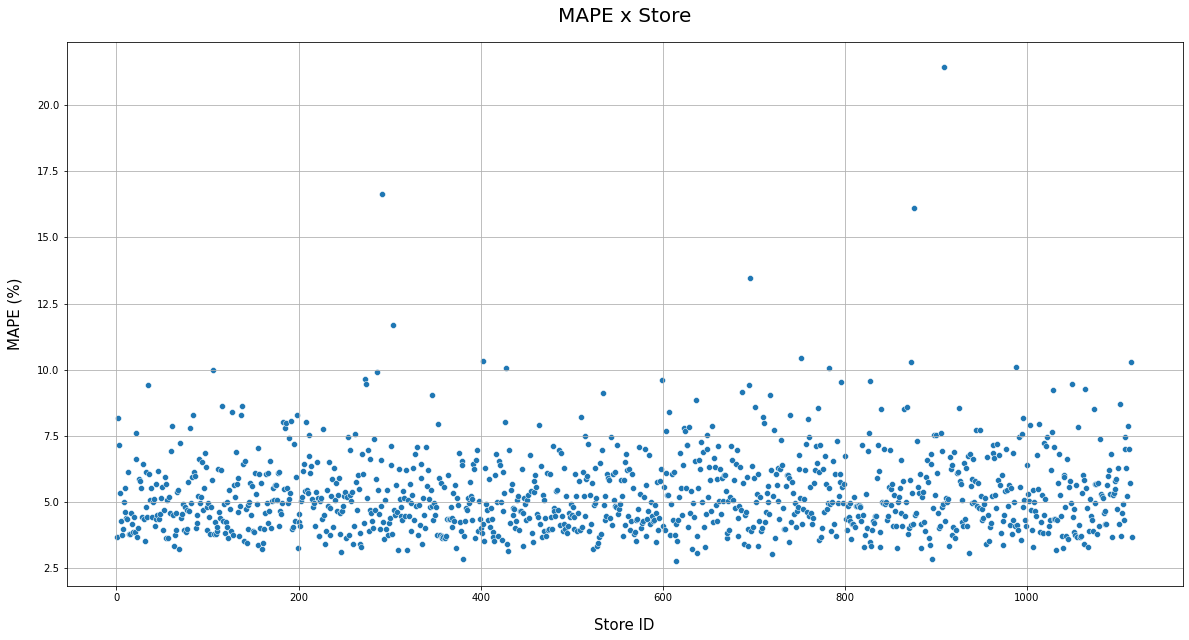

In [88]:
# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.scatterplot(x= df_comparison_sum['store'], y= df_comparison_sum['MAPE'] * 100)
ax.set_title("MAPE x Store", size= 20, pad= 20)
ax.set_ylabel("MAPE (%)", size= 15, labelpad= 15)
ax.set_xlabel("Store ID", size= 15, labelpad= 15)
ax.grid()

# saving the graph as 'mape_x_store' in the storytelling folder  
plt.savefig('../storytelling/mape_x_store.png')

***
**As seen above:**

All MAPE values are concentrated between 10% and 2,5% values, with some higher outliers, which are the stores that we specified before.

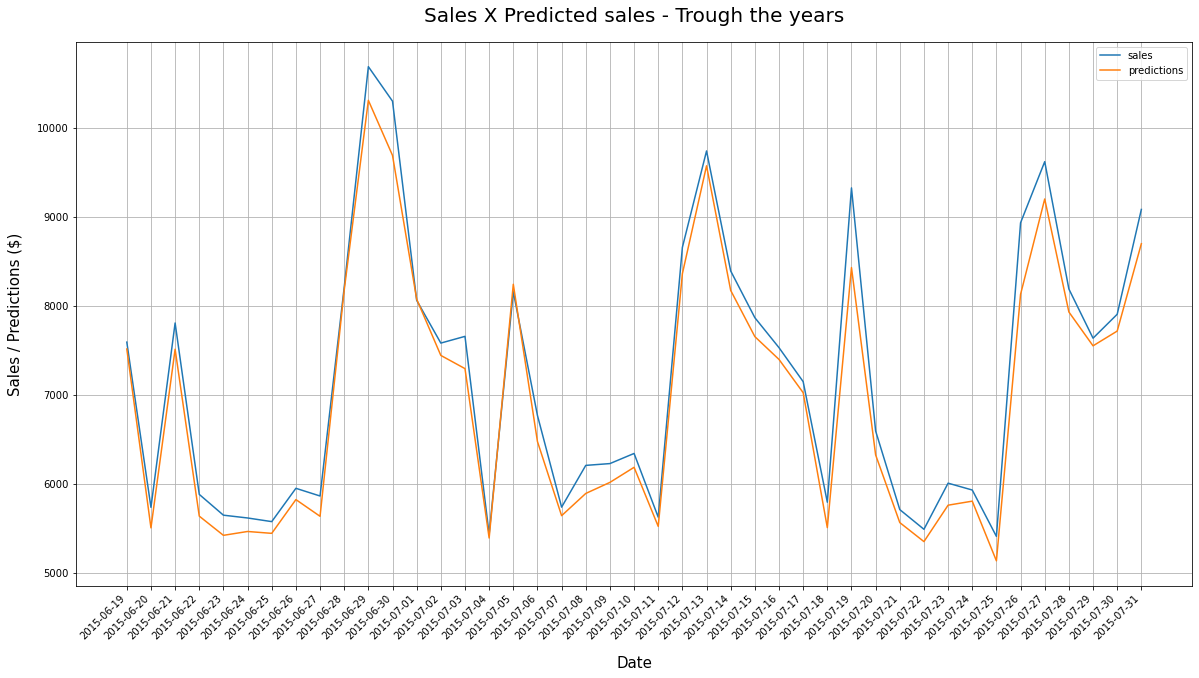

In [90]:
# creating a figure
fig = plt.figure(figsize= (20,10))

# setting ax graph, title, labels, ticks and sizes
ax = sns.lineplot(x= df_comparison['date'], y= df_comparison['sales'], ci= None)
ax = sns.lineplot(x= df_comparison['date'], y= df_comparison['predictions'], ci= None)
ax.set_title("Sales X Predicted sales - Trough the years", size= 20, pad= 20)
ax.set_ylabel("Sales / Predictions ($)", size= 15, labelpad= 15)
ax.set_xlabel("Date", size= 15, labelpad= 15)
ax.legend(labels= ['sales', 'predictions'])
ax.grid()

# rotating the x axis labels
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
    
# saving the graph as 'real_x_predictions' in the storytelling folder  
plt.savefig('../storytelling/real_x_predictions.png')

***
**As seen above:**

The 3,01% overall MAPE value that we found between the 'total prediction' and 'total sales' relation seems to be continuous through all the period. With this information, knowing that the main direction of the absolute error is always dominant, we can search ways to better fit the model.

# <font color=green size= 6> <b>10. DEPLOY </font></b>
***

## <font color=green size= 5>10.1  CHATBOT WITHOUT AWS BUCKET </font>
***

In [ ]:
# imports
import requests
import time
import json
import os
import pickle
import boto3
import warnings
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt
from sklearn.metrics        import mean_absolute_error
from io                     import BytesIO

warnings.filterwarnings('ignore')


# instantiating the 'TelegramBot' class
class TelegramBot:

    # instantiating the 'init' class function
    def __init__(self):

        token = "censored"

        self.url_base = f"https://api.telegram.org/bot{token}/"

    # creating a function that will loop checking for new telegram messages
    def start(self):

        update_id = None

        while True:

            atualize = self.get_new_messages(update_id)

            datas = atualize["result"]

            if datas:

                for data in datas:
                    update_id = data['update_id']

                    is_new_message = int(data["message"]["message_id"])

                    message = str(data["message"]["text"])

                    chat_id = data["message"]["from"]["id"]

                    self.answer(is_new_message, message, chat_id)

    # obtaining new messages from telegram
    def get_new_messages(self, update_id):

        request_link = f'{self.url_base}getUpdates?timeout=100'

        if update_id:
            request_link = f'{request_link}&offset={update_id + 1}'

        result = requests.get(request_link)

        return json.loads(result.content)

    # creating an answer and send it
    def answer(self, is_new_message, message, chat_id):

        if is_new_message == 1 or message in ('menu', 'MENU', 'Menu', 'mENU'):
            text = f"Welcome to the Pedero's Rossmann sales bot!{os.linesep}{os.linesep}This bot predicts the Rossmann stores sales for the next 6 weeks, assuming that today is 19/06/2015.{os.linesep}{os.linesep}For each store's prediction sales, text the store's ID, from 1 to 1115."

            request_link = f'{self.url_base}sendMessage?chat_id={chat_id}&text={text}'

            return requests.get(request_link)

        elif message in [str(num) for num in list(range(1, 1116))]:

            # instantiating the 'store' value as the 'message' variable in string type
            store = int(message)

            # loading the 'y_pred' as a .csv file
            x_test_time = pd.read_csv("parameters/x_test_time.csv")
            x_test_time.sort_values('date', ascending= True, inplace= True)

            # loading the 'y_pred' as a .csv file
            y_pred = pd.read_csv("parameters/y_pred.csv")

            # creating the 'df_comparison' dataset as dataset 'x_test_time' filtering 'store','date' and 'sales' columns
            df_comparison = x_test_time[['store', 'date', 'sales']]

            # transforming the 'sales' column values into exponential values
            df_comparison['sales'] = np.expm1(df_comparison['sales'])

            # transforming the 'predictions' column values into exponential values
            df_comparison['predictions'] = np.expm1(y_pred['0'])

            # filtering the 'df_comparison' with only values equals to 'store' variable in the 'store' column
            df_comparison = df_comparison[df_comparison['store'] == store]

            # calculating the mean absolute error between all 'df_comparison' registers, evaluating the 'sales' and 'predictions' columns
            aux_MAE = df_comparison[['store', 'sales', 'predictions']].groupby('store').apply(
                lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})

            # creating the 'expected_scenario', 'worst_scenario' and 'best_scenario' columns in the dataset
            df_comparison['expected_scenario'] = df_comparison['predictions']
            df_comparison['worst_scenario'] = df_comparison['predictions'] - (aux_MAE['MAE'].iloc[0])
            df_comparison['best_scenario'] = df_comparison['predictions'] + (aux_MAE['MAE'].iloc[0])

            # creating a figure and adjusting its size
            fig = plt.figure(figsize=(20, 10))

            # setting ax graph, title, labels, ticks and sizes
            ax = sns.lineplot(x=df_comparison['date'], y=df_comparison['expected_scenario'], ci=None)
            ax = sns.lineplot(x=df_comparison['date'], y=df_comparison['worst_scenario'], ci=None)
            ax = sns.lineplot(x=df_comparison['date'], y=df_comparison['best_scenario'], ci=None)
            ax.set_title(f"Scenarios sales for store ID {store}", size=20, pad=20)
            ax.set_ylabel("Daily sales predictions ($)", size=15, labelpad=15)
            ax.set_xlabel("Date", size=15, labelpad=15)
            ax.legend(labels=['expected scenario', 'worst scenario', 'best scenario'])
            for label in ax.get_xticklabels():
                label.set_ha("right")
                label.set_rotation(45)
            ax.grid()

            # saving the image 'fig' as bytes
            img_data = BytesIO()
            plt.savefig(img_data, format='png')

            # closing the image plot
            plt.close()

            # setting the cursor to the first character in the 'fig' image's bytes
            img_data.seek(0)

            # loading the figure bytes as a value of a 'file' dictionary
            file = {'photo': img_data}

            # setting the 'text' variable as the text to return to the user
            text = f"- In the expected scenario, for the next 6 weeks, is expected that the store's ID {store} total sales will be: $ {round(df_comparison['expected_scenario'].sum(), 2)}{os.linesep}- In the worst scenario, for the next 6 weeks, is expected that the store's ID {store} total sales will be: $ {round(df_comparison['worst_scenario'].sum(), 2)}{os.linesep}- In the best scenario, for the next 6 weeks, is expected that the store's ID {store} total sales will be: $ {round(df_comparison['best_scenario'].sum(), 2)}{os.linesep}"

            # setting the request formula to return the informations to the user
            request_link = f"{self.url_base}sendPhoto?chat_id={chat_id}&caption={text}"

            return requests.post(request_link, files=file)

        else:

            text = f"Store not found. Please, check if the store's ID was correctly typed.{os.linesep}{os.linesep}If you want, type 'MENU' to go back to the menu."

            request_link = f'{self.url_base}sendMessage?chat_id={chat_id}&text={text}'

            return requests.get(request_link)


# creating bot object and start the bot
bot = TelegramBot()
bot.start()

## <font color=green size= 5>10.2 CHATBOT WITH AWS BUCKET </font>
***

In [ ]:
# imports
import requests
import time
import json
import os
import pickle
import boto3
import warnings
warnings.filterwarnings('ignore')

import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt

from sklearn.metrics        import mean_absolute_error
from io                     import BytesIO


# instantiating the 'TelegramBot' class
class TelegramBot:
    
    # instantiating the 'init' class function
    def __init__(self):
        
        token = "censored"
        
        self.url_base = f"https://api.telegram.org/bot{token}/"

        
    # creating a function that will loop checking for new telegram messages
    def start(self):
        
        update_id = None
        
        while True:
            
            atualize = self.get_new_messages(update_id)
            
            datas = atualize["result"]
            
            if datas:
                
                for data in datas:
                    
                    update_id = data['update_id']
                    
                    is_new_message = int(data["message"]["message_id"])
                    
                    message = str(data["message"]["text"])
                    
                    chat_id = data["message"]["from"]["id"]
                    
                    self.answer(is_new_message, message, chat_id)

                    
    # obtaining new messages from telegram
    def get_new_messages(self, update_id):
        
        request_link = f'{self.url_base}getUpdates?timeout=100'
        
        if update_id:
            
            request_link = f'{request_link}&offset={update_id + 1}'
            
        result = requests.get(request_link)
        
        return json.loads(result.content)

    
    # creating an answer and send it
    def answer(self, is_new_message, message, chat_id):
        
        if is_new_message == 1 or message in ('menu', 'MENU', 'Menu'):
                      
            text = f"Welcome to the Pedero's Rossmann sales bot!{os.linesep}{os.linesep}This bot predicts the Rossmann stores sales for the next 6 weeks, assuming that today is 19/06/2015.{os.linesep}{os.linesep}For each store's prediction sales, text the store's ID, from 1 to 1115."
                        
            request_link = f'{self.url_base}sendMessage?chat_id={chat_id}&text={text}'
        
            return requests.get(request_link)
        
    
        if is_new_message != 1 and message in [str(num) for num in list(range(1, 1116))]:
            
            # instantiating the 'store' value as the 'message' variable in string type
            store = int(message)
            
            # loading the 'y_pred' as a .csv file
            x_test_time = pd.read_csv("../data/x_test_time.csv")
            
            # loading the 'y_pred' as a .csv file
            y_pred = pd.read_csv("../data/y_pred.csv")
            
            # creating the 'df_comparison' dataset as dataset 'x_test_time' filtering 'store','date' and 'sales' columns
            df_comparison = x_test_time[['store','date', 'sales']]
            
            # transforming the 'sales' column values into exponential values
            df_comparison['sales'] = np.expm1(df_comparison['sales'])  
            
            # transforming the 'predictions' column values into exponential values
            df_comparison['predictions'] = np.expm1(y_pred['0'])
            
            # filtering the 'df_comparison' with only values equals to 'store' variable in the 'store' column
            df_comparison = df_comparison[df_comparison['store'] == store]

            # calculating the mean absolute error between all 'df_comparison' registers, evaluating the 'sales' and 'predictions' columns
            aux_MAE  = df_comparison[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})

            # creating the 'expected_scenario', 'worst_scenario' and 'best_scenario' columns in the dataset
            df_comparison['expected_scenario'] = df_comparison['predictions']
            df_comparison['worst_scenario'] = df_comparison['predictions'] - (aux_MAE['MAE'].iloc[0])
            df_comparison['best_scenario'] = df_comparison['predictions']  + (aux_MAE['MAE'].iloc[0])

            # save the plot to a static folder
            image_name = f"graph_store_{store}.png"      
            
            # you need a bucket, make one and put its name here
            bucket = "censored"
            
            # generating the URL to get 'key-name' from 'bucket-name'
            url = "http://" + bucket + ".s3.amazonaws.com/" + image_name
            
            # check if the URL for the image already exists in AWS s3 bucket
            check_url = requests.get(url)
            
            # if it don't, the graph image will be create
            if request.status_code != 200:
            
                # creating a figure and adjusting its size
                fig = plt.figure(figsize= (20,10))

                # setting ax graph, title, labels, ticks and sizes
                ax = sns.lineplot(x= df_comparison['date'], y= df_comparison['expected_scenario'], ci= None)
                ax = sns.lineplot(x= df_comparison['date'], y= df_comparison['worst_scenario'], ci= None)
                ax = sns.lineplot(x= df_comparison['date'], y= df_comparison['best_scenario'], ci= None)
                ax.set_title(f"Scenarios sales for store ID {store}", size= 20, pad= 20)
                ax.set_ylabel("Daily sales predictions ($)", size= 15, labelpad= 15)
                ax.set_xlabel("Date", size= 15, labelpad= 15)
                ax.legend(labels= ['expected scenario', 'worst scenario', 'best scenario'])
                ax.grid()

                # create a connection to s3
                s3 = boto3.resource('s3', 
                                    aws_access_key_id='censored', 
                                    aws_secret_access_key='censored')

                # closing the image plot
                plt.close()

                # saving the image 'fig' as bytes
                img_data = BytesIO()
                plt.savefig(img_data, format='png')

                # setting the cursor to the first character in the 'fig' image's bytes
                img_data.seek(0)

                # saving the image in amazon web service s3
                s3.Bucket(bucket).put_object(Key= image_name, 
                                             Body= img_data, 
                                             ContentType= "image/png", 
                                             ACL= "public-read")

            
            # generating the URL to get 'key-name' from 'bucket-name'
            url = "http://" + bucket + ".s3.amazonaws.com/" + image_name
            
            # getting the image from the 'url'
            response = requests.get(url)
            
            # transforming the image to bytes
            img = BytesIO(response.content)
            
            # loading the figure as 'file'
            file = {'photo': img}            
            
            # setting the 'text' variable as the text to return to the user
            text = f"In the expected scenario, for the next 6 weeks, is expected that the store's ID {store} total sales will be: $ {round(df_comparison['expected_scenario'].sum(), 2)}{os.linesep}In the worst scenario, for the next 6 weeks, is expected that the store's ID {store} total sales will be: $ {round(df_comparison['worst_scenario'].sum(), 2)}{os.linesep}In the best scenario, for the next 6 weeks, is expected that the store's ID {store} total sales will be: $ {round(df_comparison['best_scenario'].sum(), 2)}{os.linesep}"
            
            # setting the request formula to return the informations to the user
            request_link = f"{self.url_base}sendPhoto?chat_id={chat_id}&caption={text}"            
            
            return requests.post(request_link, files = file)
        
        
        else:
            
            text = f"Store not found. Please, check if the store's ID was correctly typed.{os.linesep}{os.linesep}If you want, type 'MENU' to go back to the menu."
            
            request_link = f'{self.url_base}sendMessage?chat_id={chat_id}&text={text}'
            
            return requests.get(request_link)
                
        
# creating bot object and start the bot
bot = TelegramBot()
bot.start()